In [ ]:
# !unzip "/content/drive/Shareddrives/FYP - knk/Datasets/WELFake/sementic+sentiment_welfake.zip" -d "/content/drive/Shareddrives/FYP - knk/Datasets/WELFake"

https://colab.research.google.com/drive/1Vl5YQbDJ8jQGzvLU476mYeGiV-ZUE5NS#scrollTo=pMBi4uWC55Fq

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# import Lib

In [2]:
import torch
import time
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, precision_recall_fscore_support, \
    confusion_matrix
from sklearn.svm import SVC
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [4]:
from tqdm.auto import tqdm
tqdm.pandas()

#def func

In [13]:
# mapping of the labels to 0,1 
def label_map(x): 
  if x in ['true', 'mostly-true', 'half-true', 'real', 'Real', 0, 'REAL',"TRUE"]:
    return 0
  elif x in ['false', 'pants-fire', 'barely-true', 'fake', 'Fake', 1, 'FAKE',"FALSE"]:
    return 1
  else:return x

In [5]:
def compute_metrics(pred,ground_labels):
    labels_all = ground_labels
    preds_all = list(pred)
    
    precision, recall, f1, _ = precision_recall_fscore_support(labels_all, preds_all)
    acc = accuracy_score(labels_all, preds_all)
    confusion_mat = confusion_matrix(labels_all, preds_all)
    # tn, fp, fn, tp = confusiton_mat.ravel()
    out_dict = {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'confusiton_mat': confusion_mat
    }
    return out_dict

# read data

###new 


In [9]:
# field name of id , label , text_column of respective datasets 
id={"codalab":"id", "fakenewsnet":"id_1", "isot":"id", "kaggle":"id","kagglerealfake":"id", "liar":"ID", "politifact":"claim_id", "welfake":"id","FA-KES":"unit_id","Politifact_test":"id","COVID19_test":"id"}
label={"codalab":"label", "fakenewsnet":"label", "isot":"label", "kaggle":"label","kagglerealfake":"label","liar":"label", "politifact":"cred_label", "welfake":"label","FA-KES":"label","Politifact_test":"target","COVID19_test":"label"}
features=["lexicon","sementic","sentiment","embedding"]
text_column={"codalab":"tweet", "fakenewsnet":"title", "isot":"text", "kaggle":"text","kagglerealfake":"text", "liar":"statement", "politifact":"text", "welfake":"text","FA-KES":"article_content","Politifact_test":"statement","COVID19_test":"text"}

In [10]:
# input path of the feature set
# -----------------------------

inputPath = {
    "codalab": [
               "/content/drive/Shareddrives/[FYP] Fake News Detection/Results/CodaLab Covid/CodaLab_with_WELFAKE_Lexicon_Scores_Modified.csv",
               "/content/drive/Shareddrives/[FYP] Fake News Detection/Results/CodaLab Covid/CodaLab Covid_sementic.csv",
               "/content/drive/Shareddrives/[FYP] Fake News Detection/Results/CodaLab Covid/Codalab_emotion_scores_modified.csv",
               "/content/drive/Shareddrives/[FYP] Fake News Detection/Results/Final/CodaLab Covid/CodaLab Covid_embedding_new.csv",
               "/content/drive/Shareddrives/[FYP] Fake News Detection/Datasets/CodaLab Covid/Constraint_English_All.csv" ],
    
    "fakenewsnet" :["/content/drive/Shareddrives/[FYP] Fake News Detection/Results/FakeNewsNet/FakeNewsNet_with_WELFAKE_Lexicon_Scores_Modified.csv",
                    "/content/drive/Shareddrives/[FYP] Fake News Detection/Results/FakeNewsNet/FakeNewsNet_sementic.csv",
                    "/content/drive/Shareddrives/[FYP] Fake News Detection/Results/FakeNewsNet/FakeNewsNet_emotion_scores_modified.csv",
                    "/content/drive/Shareddrives/[FYP] Fake News Detection/Results/Final/FakeNewsNet/FakeNewsNet_embedding_new.csv",
                    "/content/drive/Shareddrives/[FYP] Fake News Detection/Datasets/FakeNewsNet/FakeNewsNet_All.csv"],
           
    "isot":   ["/content/drive/Shareddrives/[FYP] Fake News Detection/Results/ISOT/ISOT_with_WELFAKE_Lexicon_Scores_Modified.csv",
            "/content/drive/Shareddrives/[FYP] Fake News Detection/Results/ISOT/ISOT_sementic.csv",
            "/content/drive/Shareddrives/[FYP] Fake News Detection/Results/ISOT/ISOT_emotion_scores_modified.csv",
            "/content/drive/Shareddrives/[FYP] Fake News Detection/Results/Final/ISOT/ISOT_embedding_new.csv",
            "/content/drive/Shareddrives/[FYP] Fake News Detection/Datasets/ISOT/ISOT.csv"],
           
    "kagglerealfake":["/content/drive/Shareddrives/[FYP] Fake News Detection/Results/Kaggle_real_fake/Kaggle_real_fake_with_WELFAKE_Lexicon_Scores_Modified.csv",
                      "/content/drive/Shareddrives/[FYP] Fake News Detection/Results/Kaggle_real_fake/Kaggle_real_fake_sementic.csv",
                      "/content/drive/Shareddrives/[FYP] Fake News Detection/Results/Kaggle_real_fake/Kaggle_real_fake_emotion_scores_modified.csv",
                      "/content/drive/Shareddrives/[FYP] Fake News Detection/Results/Final/Kaggle_real_fake/Kaggle_real_fake_embedding_new.csv",
                      "/content/drive/Shareddrives/[FYP] Fake News Detection/Datasets/Kaggle_real_fake/fake_or_real_news.csv"] ,
    
    "liar":["/content/drive/Shareddrives/[FYP] Fake News Detection/Results/LIAR/Liar_with_WELFAKE_Lexicon_Scores_Modified.csv",
            "/content/drive/Shareddrives/[FYP] Fake News Detection/Results/LIAR/LIAR_sementic.csv",
            "/content/drive/Shareddrives/[FYP] Fake News Detection/Results/LIAR/LIAR_emotion_scores_modified.csv",
            "/content/drive/Shareddrives/[FYP] Fake News Detection/Results/Final/LIAR/LIAR_embedding_new.csv",
            "/content/drive/Shareddrives/[FYP] Fake News Detection/Datasets/LIAR/Liar_all.csv"],
           
    # "FA-KES" :["/content/drive/Shareddrives/[FYP] Fake News Detection/Datasets/FA-KES/FA-KES_title_with_WELFAKE_Lexicon_Scores_Modified.csv",
    #            "/content/drive/Shareddrives/[FYP] Fake News Detection/Results/FA-KES/FA-KES_title_sementic.csv",
    #            "/content/drive/Shareddrives/[FYP] Fake News Detection/Datasets/FA-KES/FA-KES_title_emotion_scores_modified.csv",
    #            "/content/drive/Shareddrives/[FYP] Fake News Detection/Results/Final/FA-KES/FA-KES_title_embedding_new.csv",
    #            "/content/drive/Shareddrives/[FYP] Fake News Detection/Datasets/FA-KES/FA-KES.csv"         
    # ],

    # "Politifact_test" : ["/content/drive/Shareddrives/[FYP] Fake News Detection/Datasets/Politifact_test/Politifact_test_with_WELFAKE_Lexicon_Scores_Modified.csv",
    #            "/content/drive/Shareddrives/[FYP] Fake News Detection/Results/Politifact_test/Politifact_test_sementic.csv",
    #            "/content/drive/Shareddrives/[FYP] Fake News Detection/Datasets/Politifact_test/Politifact_testset_emotion_scores_modified.csv",
    #            "/content/drive/Shareddrives/[FYP] Fake News Detection/Results/Final/Politifact_test/Politifact_test_embedding_new.csv",
    #            "/content/drive/Shareddrives/[FYP] Fake News Detection/Datasets/Politifact_test/Politifact_test.csv",        
    # ],
    # "COVID19_test" :[
    #             "/content/drive/Shareddrives/[FYP] Fake News Detection/Datasets/COVID19_test/COVID19_title_test_with_WELFAKE_Lexicon_Scores_Modified.csv",
    #            "/content/drive/Shareddrives/[FYP] Fake News Detection/Results/COVID19_test/COVID19_test_title_sementic.csv",
    #            "/content/drive/Shareddrives/[FYP] Fake News Detection/Datasets/COVID19_test/COVID19_test_title_emotion_scores_modified.csv",
    #            "/content/drive/Shareddrives/[FYP] Fake News Detection/Results/Final/COVID19_test/COVID19_test_title_embedding_new.csv",
    #            "/content/drive/Shareddrives/[FYP] Fake News Detection/Datasets/COVID19_test/COVID19_test.csv",     
    # ]


}

In [11]:
sementic_features= [
                    'url_count',
                    'qn_symbol',
                    'num_chars',
                    'num_words',
                    'num_sentences',
                    'num_exclamation',
                    'words_per_sentence',  
                    'characters_per_word',
                    'punctuations_per_sentence', 
                    'get_sentiment_polarity',  
                    'lexical_diversity',
                    'content_word_diversity',
                    'redundancy',
                    'noun',
                    'verb',
                    'adj',
                    'adv',
                    "qn_symbol_per_sentence",
                    "num_exclamation_per_sentence",
                    "url_count_per_sentence"
                    ]
All_features = sementic_features +["source","lang"]

In [14]:
## load all data set in to a dataframe dictionary (UPDATE :NORMALIZED)

all_df={}

# for each dataset 
for key,value in inputPath.items():
  print("----------",key,"--------------")
  error=False
  ID=id[key]
  TEXT=text_column[key]
  LABEL=label[key]


  # read each of the 4 features for the dataset 
  df = pd.read_csv(value[1]) 

  # combine the features using inner join 

  df=df.drop(df.columns[df.columns.str.contains('unnamed',case = False)],axis = 1)

  # df=df.loc[df["lang"]=="en"]    # filter only english text 
  df["label"]=df[LABEL]  #set the label coulmn 
  df["source"]=key
 

  df["label"]=df["label"].apply(label_map)   # converting labels to 0,1 
  df["id"] = df[ID]
  
  # for codalab and liar include split column as well 
  if (key=="codalab" or key=="liar"):  
    df=df[All_features+["label","id","split"]]
  else :
    df=df[All_features+["label","id",]]

  print(df["label"].value_counts())


  df=df.loc[df["label"].isin([0,1])]
  df["label"] = df["label"].astype("int64")
    
  #clean 
  print("null rows : ",df.isnull().any(axis=1).sum())
  df.replace([np.inf, -np.inf], np.nan, inplace=True)
  print("inf rows : ",df.isnull().any(axis=1).sum())
  df.dropna(inplace=True)

  #uncomment below code to create a randome sample with equal call size 

  # df = df.groupby('label').apply(lambda x: x.sample(n=min(df["label"].value_counts().to_list()))).reset_index(drop = True)

  # all_df[key],pdict=normalize(df,Semantic_features+Emotion_features)   # normalize 
  all_df[key]=df.copy(deep=True)         
  # print(df["label"].value_counts())
all_df.keys()

---------- codalab --------------
0    5600
1    5100
Name: label, dtype: int64
null rows :  0
inf rows :  0
---------- fakenewsnet --------------
0    17441
1     5755
Name: label, dtype: int64
null rows :  0
inf rows :  0
---------- isot --------------
1    23481
0    21417
Name: label, dtype: int64
null rows :  0
inf rows :  0
---------- kagglerealfake --------------
0    3171
1    3164
Name: label, dtype: int64
null rows :  0
inf rows :  0
---------- liar --------------
0    7134
1    5657
Name: label, dtype: int64
null rows :  0
inf rows :  0


dict_keys(['codalab', 'fakenewsnet', 'isot', 'kagglerealfake', 'liar'])

In [15]:
dfAll=all_df["fakenewsnet"].append(all_df["isot"],ignore_index = True).append(all_df["kagglerealfake"],ignore_index = True).append(all_df["liar"],ignore_index = True).append(all_df["codalab"],ignore_index = True)

In [16]:
dfAll.source.value_counts()

isot              44898
fakenewsnet       23196
liar              12791
codalab           10700
kagglerealfake     6335
Name: source, dtype: int64

In [17]:
from IPython.display import display, HTML
# CSS = """
# .output {
#     flex-direction: row;
# }
# """

# HTML('<style>{}</style>'.format(CSS))
df_summary={}
for key in all_df:
  print(key,"\n")
  dis=all_df[key].describe()
  df_summary[key]=dis
  display(dis)

codalab 



url_count     qn_symbol     num_chars     num_words  num_sentences  \
count  10700.000000  10700.000000  10700.000000  10700.000000   10700.000000   
mean       0.690467      0.225327    181.894299     26.979439       1.605794   
std        0.906139      1.241467    162.660269     25.415617       1.240469   
min        0.000000      0.000000     18.000000      3.000000       1.000000   
25%        0.000000      0.000000    110.000000     15.000000       1.000000   
50%        1.000000      0.000000    169.000000     25.000000       1.000000   
75%        1.000000      0.000000    255.000000     37.000000       2.000000   
max       52.000000     34.000000  10170.000000   1483.000000      59.000000   

       num_exclamation  words_per_sentence  characters_per_word  \
count     10700.000000        10700.000000         10700.000000   
mean          0.055981           18.489026             5.548363   
std           0.337054            9.349255             0.980490   
min           0.000000            3.000000             3.266667   
25%           0.000000           12.000000             4.866667   
50%           0.000000           16.000000             5.375000   
75%           0.000000           22.000000             6.073397   
max           9.000000           94.000000            12.615385   

       punctuations_per_sentence  get_sentiment_polarity  ...  \
count               10700.000000            10700.000000  ...   
mean                    6.215514                0.013692  ...   
std                     5.627667                0.425638  ...   
min                     0.000000               -0.995500  ...   
25%                     2.000000               -0.296000  ...   
50%                     5.000000                0.000000  ...   
75%                     8.000000                0.340000  ...   
max                    66.000000                0.992900  ...   

       content_word_diversity    redundancy          noun          verb  \
count            10700.000000  10700.000000  10700.000000  10700.000000   
mean                61.209473     32.536628     21.548456     12.844708   
std                 13.721991     11.511905      8.922319      6.737825   
min                 23.529412      0.000000      0.000000      0.000000   
25%                 51.351351     25.000000     15.680369      8.333333   
50%                 59.375000     33.333333     20.930233     12.500000   
75%                 69.565217     40.000000     26.666667     16.666667   
max                125.000000     75.000000    100.000000     50.000000   

                adj           adv  qn_symbol_per_sentence  \
count  10700.000000  10700.000000            10700.000000   
mean       6.747338      2.843509                0.177848   
std        5.508645      3.926997                1.033110   
min        0.000000      0.000000                0.000000   
25%        2.702703      0.000000                0.000000   
50%        6.250000      0.000000                0.000000   
75%       10.000000      5.000000                0.000000   
max       50.000000     37.500000               21.000000   

       num_exclamation_per_sentence  url_count_per_sentence         label  
count                  10700.000000            10700.000000  10700.000000  
mean                       0.035103                0.492875      0.476636  
std                        0.207390                0.594116      0.499477  
min                        0.000000                0.000000      0.000000  
25%                        0.000000                0.000000      0.000000  
50%                        0.000000                0.333333      0.000000  
75%                        0.000000                1.000000      1.000000  
max                        4.000000                4.000000      1.000000  

[8 rows x 21 columns]

fakenewsnet 



url_count     qn_symbol     num_chars     num_words  num_sentences  \
count  23196.000000  23196.000000  23196.000000  23196.000000   23196.000000   
mean       0.000129      0.061519     68.303328     11.084109       1.038196   
std        0.011372      0.246310     23.287987      3.937597       0.196121   
min        0.000000      0.000000     10.000000      1.000000       1.000000   
25%        0.000000      0.000000     55.000000      9.000000       1.000000   
50%        0.000000      0.000000     68.000000     11.000000       1.000000   
75%        0.000000      0.000000     84.000000     14.000000       1.000000   
max        1.000000      3.000000    340.000000     53.000000       4.000000   

       num_exclamation  words_per_sentence  characters_per_word  \
count     23196.000000        23196.000000         23196.000000   
mean          0.059752           10.815579             5.115593   
std           0.255079            3.912452             1.054734   
min           0.000000            1.000000             0.000000   
25%           0.000000            8.000000             4.562500   
50%           0.000000           11.000000             5.000000   
75%           0.000000           13.000000             5.545455   
max           6.000000           53.000000            66.000000   

       punctuations_per_sentence  get_sentiment_polarity  ...    redundancy  \
count               23196.000000            23196.000000  ...  23196.000000   
mean                    1.439950                0.055433  ...     26.178493   
std                     1.589241                0.383081  ...     13.846927   
min                     0.000000               -0.959000  ...      0.000000   
25%                     0.000000                0.000000  ...     16.666667   
50%                     1.000000                0.000000  ...     26.666667   
75%                     2.000000                0.361200  ...     35.714286   
max                    23.000000                0.963800  ...    100.000000   

               noun          verb           adj           adv  \
count  23196.000000  23196.000000  23196.000000  23196.000000   
mean      11.953681     10.080536      3.753059      2.479172   
std       12.273030      8.628776      6.113274      5.021550   
min        0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000   
50%       10.000000     10.000000      0.000000      0.000000   
75%       18.181818     15.384615      7.692308      0.000000   
max      100.000000    100.000000     50.000000     50.000000   

       qn_symbol_per_sentence  num_exclamation_per_sentence  \
count            23196.000000                  23196.000000   
mean                 0.052581                      0.052505   
std                  0.216046                      0.226793   
min                  0.000000                      0.000000   
25%                  0.000000                      0.000000   
50%                  0.000000                      0.000000   
75%                  0.000000                      0.000000   
max                  2.000000                      6.000000   

       url_count_per_sentence         label            id  
count            23196.000000  23196.000000  23196.000000  
mean                 0.000129      0.248103  11597.500000  
std                  0.011372      0.431921   6696.252758  
min                  0.000000      0.000000      0.000000  
25%                  0.000000      0.000000   5798.750000  
50%                  0.000000      0.000000  11597.500000  
75%                  0.000000      0.000000  17396.250000  
max                  1.000000      1.000000  23195.000000  

[8 rows x 22 columns]

isot 



url_count     qn_symbol     num_chars     num_words  num_sentences  \
count  44898.000000  44898.000000  44898.000000  44898.000000   44898.000000   
mean       0.106575      0.678605   2469.109693    404.026972      12.123614   
std        0.480389      1.794833   2171.617091    350.620233      10.596294   
min        0.000000      0.000000      1.000000      0.000000       1.000000   
25%        0.000000      0.000000   1234.000000    202.000000       5.000000   
50%        0.000000      0.000000   2186.000000    361.000000      10.000000   
75%        0.000000      1.000000   3105.000000    511.000000      16.000000   
max       22.000000     94.000000  51794.000000   8122.000000     305.000000   

       num_exclamation  words_per_sentence  characters_per_word  \
count     44898.000000        44898.000000         44898.000000   
mean          0.407635           36.053486             4.903058   
std           1.455699           18.043266             0.985571   
min           0.000000            0.000000             0.000000   
25%           0.000000           26.428571             4.739084   
50%           0.000000           33.000000             4.948302   
75%           0.000000           41.571429             5.141249   
max         133.000000          423.000000            74.000000   

       punctuations_per_sentence  get_sentiment_polarity  ...    redundancy  \
count               44898.000000            44898.000000  ...  44898.000000   
mean                    5.011789               -0.003285  ...     18.751440   
std                     3.512901                0.835936  ...      6.935751   
min                     0.000000               -1.000000  ...      0.000000   
25%                     3.400000               -0.936000  ...     14.676739   
50%                     4.333333                0.000000  ...     17.787419   
75%                     5.714286                0.915300  ...     21.641179   
max                   182.375000                1.000000  ...     81.818182   

               noun          verb           adj           adv  \
count  44898.000000  44898.000000  44898.000000  44898.000000   
mean      14.611841     11.324057      5.604985      3.112447   
std        3.746372      3.123639      2.265798      1.912190   
min        0.000000      0.000000      0.000000      0.000000   
25%       12.764306     10.071942      4.534950      2.051282   
50%       14.541833     11.347076      5.527638      2.951290   
75%       16.538462     12.662942      6.567164      4.034429   
max      100.000000    100.000000    100.000000    100.000000   

       qn_symbol_per_sentence  num_exclamation_per_sentence  \
count            44898.000000                  44898.000000   
mean                 0.055199                      0.045358   
std                  0.170512                      0.163551   
min                  0.000000                      0.000000   
25%                  0.000000                      0.000000   
50%                  0.000000                      0.000000   
75%                  0.052632                      0.000000   
max                 18.800000                      4.000000   

       url_count_per_sentence         label           id  
count            44898.000000  44898.000000  44898.00000  
mean                 0.014684      0.522985  22449.50000  
std                  0.083816      0.499477  12961.08053  
min                  0.000000      0.000000      1.00000  
25%                  0.000000      0.000000  11225.25000  
50%                  0.000000      1.000000  22449.50000  
75%                  0.000000      1.000000  33673.75000  
max                  2.166667      1.000000  44898.00000  

[8 rows x 22 columns]

kagglerealfake 



url_count    qn_symbol      num_chars    num_words  num_sentences  \
count  6335.000000  6335.000000    6335.000000   6335.00000    6335.000000   
mean      0.123441     1.536701    4707.250355    773.58090      20.910655   
std       0.916421     3.988245    5090.956446    851.25714      30.483188   
min       0.000000     0.000000       1.000000      0.00000       1.000000   
25%       0.000000     0.000000    1741.500000    287.50000       6.000000   
50%       0.000000     0.000000    3642.000000    594.00000      14.000000   
75%       0.000000     2.000000    6192.000000   1020.00000      26.000000   
max      31.000000   117.000000  115372.000000  20849.00000    1011.000000   

       num_exclamation  words_per_sentence  characters_per_word  \
count      6335.000000         6335.000000          6335.000000   
mean          0.528966           46.592531             4.852909   
std           2.278884           37.134178             0.772851   
min           0.000000            0.000000             0.000000   
25%           0.000000           27.532563             4.661968   
50%           0.000000           38.750000             4.847967   
75%           0.000000           54.863354             5.038948   
max         104.000000         1096.000000            48.095238   

       punctuations_per_sentence  get_sentiment_polarity  ...   redundancy  \
count                6335.000000             6335.000000  ...  6335.000000   
mean                    7.107162                0.134221  ...    17.308220   
std                     7.603407                0.873148  ...     8.387856   
min                     0.000000               -1.000000  ...     0.000000   
25%                     3.867816               -0.943800  ...    11.951157   
50%                     5.666667                0.573700  ...    15.254237   
75%                     8.369318                0.984100  ...    20.475872   
max                   282.333333                1.000000  ...    72.222222   

              noun         verb          adj          adv  \
count  6335.000000  6335.000000  6335.000000  6335.000000   
mean     14.681343    10.999112     5.733021     3.416462   
std       4.096272     2.823652     2.065874     1.587503   
min       0.000000     0.000000     0.000000     0.000000   
25%      12.542904     9.659091     4.692634     2.593190   
50%      14.195584    10.859729     5.605381     3.349282   
75%      16.026586    12.182825     6.615281     4.185073   
max      50.000000    66.666667    50.000000    16.666667   

       qn_symbol_per_sentence  num_exclamation_per_sentence  \
count             6335.000000                   6335.000000   
mean                 0.073928                      0.038500   
std                  0.169025                      0.154275   
min                  0.000000                      0.000000   
25%                  0.000000                      0.000000   
50%                  0.000000                      0.000000   
75%                  0.090909                      0.000000   
max                  4.888889                      3.000000   

       url_count_per_sentence        label          id  
count             6335.000000  6335.000000  6335.00000  
mean                 0.016367     0.499448  3167.00000  
std                  0.162000     0.500039  1828.90131  
min                  0.000000     0.000000     0.00000  
25%                  0.000000     0.000000  1583.50000  
50%                  0.000000     0.000000  3167.00000  
75%                  0.000000     1.000000  4750.50000  
max                  7.750000     1.000000  6334.00000  

[8 rows x 22 columns]

liar 



url_count     qn_symbol     num_chars     num_words  num_sentences  \
count    12791.0  12791.000000  12791.000000  12791.000000   12791.000000   
mean         0.0      0.007583    107.161520     17.973262       1.136737   
std          0.0      0.096159     63.452113     10.070824       0.417918   
min          0.0      0.000000     11.000000      2.000000       1.000000   
25%          0.0      0.000000     73.000000     12.000000       1.000000   
50%          0.0      0.000000     99.000000     17.000000       1.000000   
75%          0.0      0.000000    133.000000     22.000000       1.000000   
max          0.0      4.000000   3192.000000    464.000000       8.000000   

       num_exclamation  words_per_sentence  characters_per_word  \
count     12791.000000        12791.000000         12791.000000   
mean          0.006723           16.359834             4.928957   
std           0.102898            7.414519             0.685955   
min           0.000000            2.000000             2.500000   
25%           0.000000           11.000000             4.460499   
50%           0.000000           15.000000             4.866667   
75%           0.000000           20.000000             5.333333   
max           5.000000          214.000000            11.200000   

       punctuations_per_sentence  get_sentiment_polarity  ...  \
count               12791.000000            12791.000000  ...   
mean                    2.478884               -0.011110  ...   
std                     1.879612                0.390909  ...   
min                     0.000000               -0.974400  ...   
25%                     1.000000               -0.296000  ...   
50%                     2.000000                0.000000  ...   
75%                     3.000000                0.273200  ...   
max                    62.000000                0.942300  ...   

       content_word_diversity    redundancy          noun          verb  \
count            12791.000000  12791.000000  12791.000000  12791.000000   
mean                57.563570     37.732370     22.374591     13.084330   
std                 12.979144     11.612366      9.892389      7.990959   
min                 11.111111      0.000000      0.000000      0.000000   
25%                 50.000000     30.303030     15.789474      7.692308   
50%                 57.142857     37.500000     21.739130     12.500000   
75%                 66.666667     45.454545     28.571429     18.181818   
max                120.000000     88.888889     75.000000     66.666667   

                adj           adv  qn_symbol_per_sentence  \
count  12791.000000  12791.000000            12791.000000   
mean       6.504705      3.240750                0.004452   
std        6.141069      4.755819                0.058986   
min        0.000000      0.000000                0.000000   
25%        0.000000      0.000000                0.000000   
50%        5.882353      0.000000                0.000000   
75%       10.000000      5.882353                0.000000   
max       60.000000     42.857143                2.000000   

       num_exclamation_per_sentence  url_count_per_sentence         label  
count                  12791.000000                 12791.0  12791.000000  
mean                       0.005577                     0.0      0.442264  
std                        0.088444                     0.0      0.496675  
min                        0.000000                     0.0      0.000000  
25%                        0.000000                     0.0      0.000000  
50%                        0.000000                     0.0      0.000000  
75%                        0.000000                     0.0      1.000000  
max                        5.000000                     0.0      1.000000  

[8 rows x 21 columns]

## Processing data (no run)

In [ ]:
# data=df.drop(columns=["content_word_diversity_and_redundancy","nvaa","14_emo_dict","8_emo_dict"])

In [ ]:
# data.loc[df['punctuations_per_sentence'] >9].shape

In [ ]:
# data1=df.loc[df['url_count'] <5]
# data1=data1.loc[df['qn_symbol'] <10]
# data1=data1.loc[df['num_chars'] <6000]
# data1=data1.loc[df['words_per_sentence'] <100]
# data1=data1.loc[df['characters_per_word'] <6]
# data1=data1.loc[df['punctuations_per_sentence'] <20]
# data1=data1.loc[df['negative'] <10]
# data1=data1.loc[df['positive'] <10]
# data1=df.loc[df['punctuations_per_sentence'] <10]


In [ ]:
# f = pd.melt( data1, id_vars='label', value_vars=features)
# g = sns.FacetGrid( f, hue='label', col="variable", col_wrap=5, sharex=False, sharey=False ,legend_out=True )
# g = g.map( sns.histplot, "value").add_legend() #kde=True to trend line

In [ ]:
# columns=df.columns.drop(["title","text","content","highest_14_emo_label","highest_8_emo_label","lang"]).tolist()
# features=df.columns.drop(["title","text","content","lang","label","highest_14_emo_label","highest_8_emo_label"]).tolist()
# emot=["anger","anticipation","disgust","fear","joy","sadness","surprise","trust"]
# emot_null=['anger_null','anticipation_null','disgust_null','fear_null','joy_null','sadness_null','surprise_null','trust_null']
# sementic=[x for x in features if (x not in emot ) and (x not in emot_null) and (x not in ["negative","positive"] )]

In [ ]:
# data=df[columns]

In [ ]:
# data=data.astype({'label': 'int64'})
# data=data.reset_index(drop=True)
# data=data[sementic+["label"]]

In [ ]:
# for i in emot:
#   df[i+"_null"]=np.where(df[i]==0,1,0)

In [ ]:
# df.head()

In [ ]:
# fake = data.loc[data['label'] == 1]
# true = data.loc[data['label'] == 0]

In [ ]:
# true.describe()

In [ ]:
# fake.describe()

In [ ]:
# data=true.append(fake).sample(frac=1).reset_index(drop=True)

## new features(no run)

In [ ]:
# data["verb_noun_ratio"]=(data["verb"])/(data["noun"])
# data["adj_adv_ratio"]=(data["adj"])/(data["adv"])
# data["verb_noun_ratio"].replace([np.inf, -np.inf,np.nan], 0 ,inplace=True)
# data["adj_adv_ratio"].replace([np.inf, -np.inf,np.nan], 0 ,inplace=True)

In [ ]:
# data.loc[data["adj_adv_ratio"]==np.inf]

In [ ]:
# sementic+=["verb_noun_ratio","adj_adv_ratio"]

In [ ]:
# X=data[sementic]
# Y=data.label

In [ ]:
# data.info()   

In [ ]:
# data.head()

In [ ]:
# data.describe()

In [ ]:
# f = pd.melt( data[emot+["label"]], id_vars='label', value_vars=emot)

# g = sns.catplot(x="label" ,y="value",
#                 col="variable",col_wrap=5,
#                 data=f, kind="violin",sharey=False,sharex=False);

# analyse df

## FakeNewsNet

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3806: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)


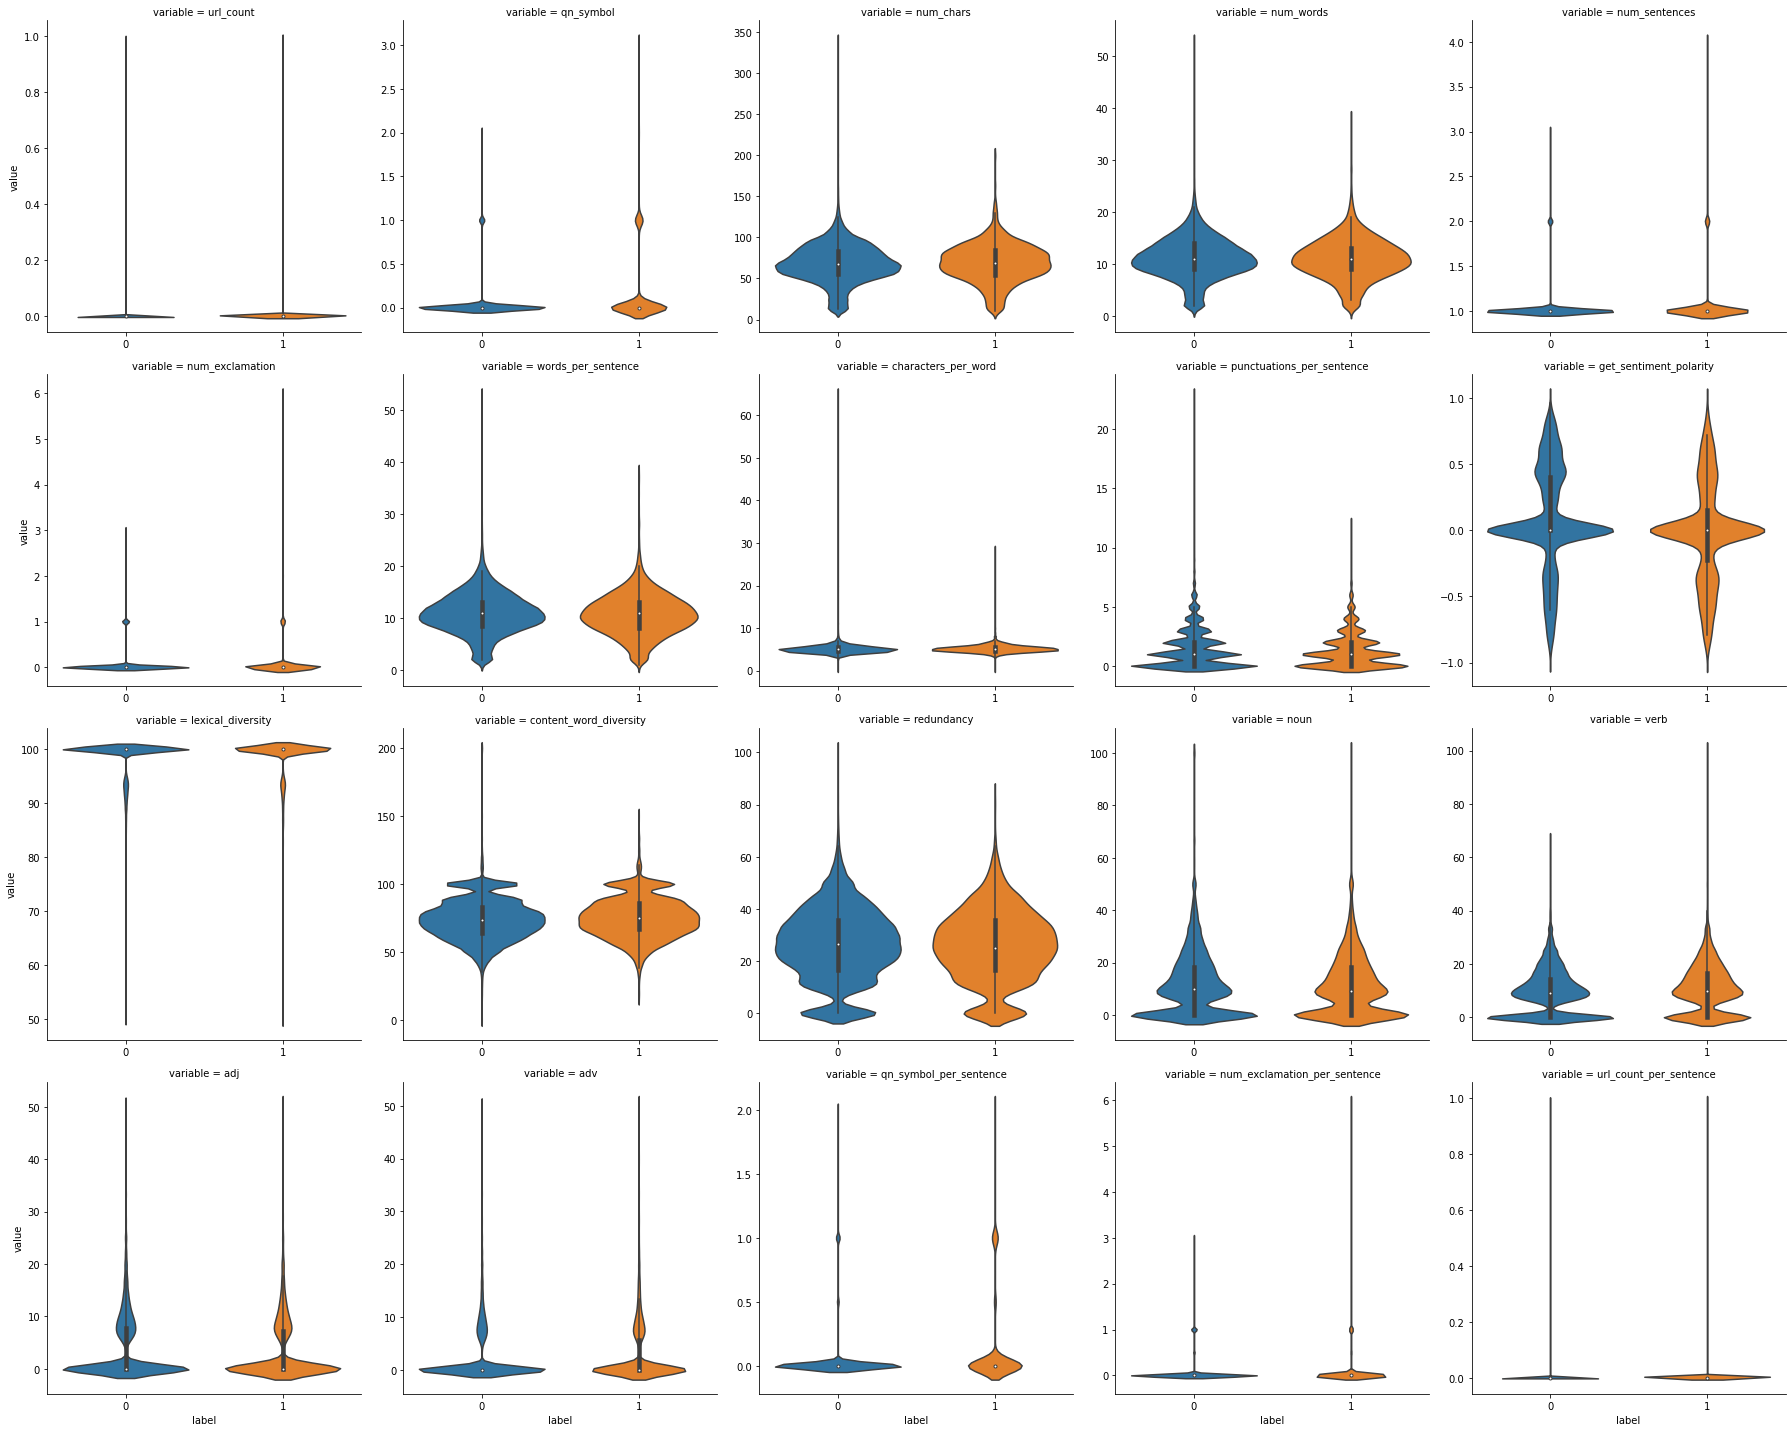

In [19]:
f = pd.melt( all_df["fakenewsnet"], id_vars='label', value_vars=sementic_features)

g = sns.catplot(x="label" ,y="value",
                col="variable",col_wrap=5,
                data=f, kind="violin",sharey=False,sharex=False);

## ISOT

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3806: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)


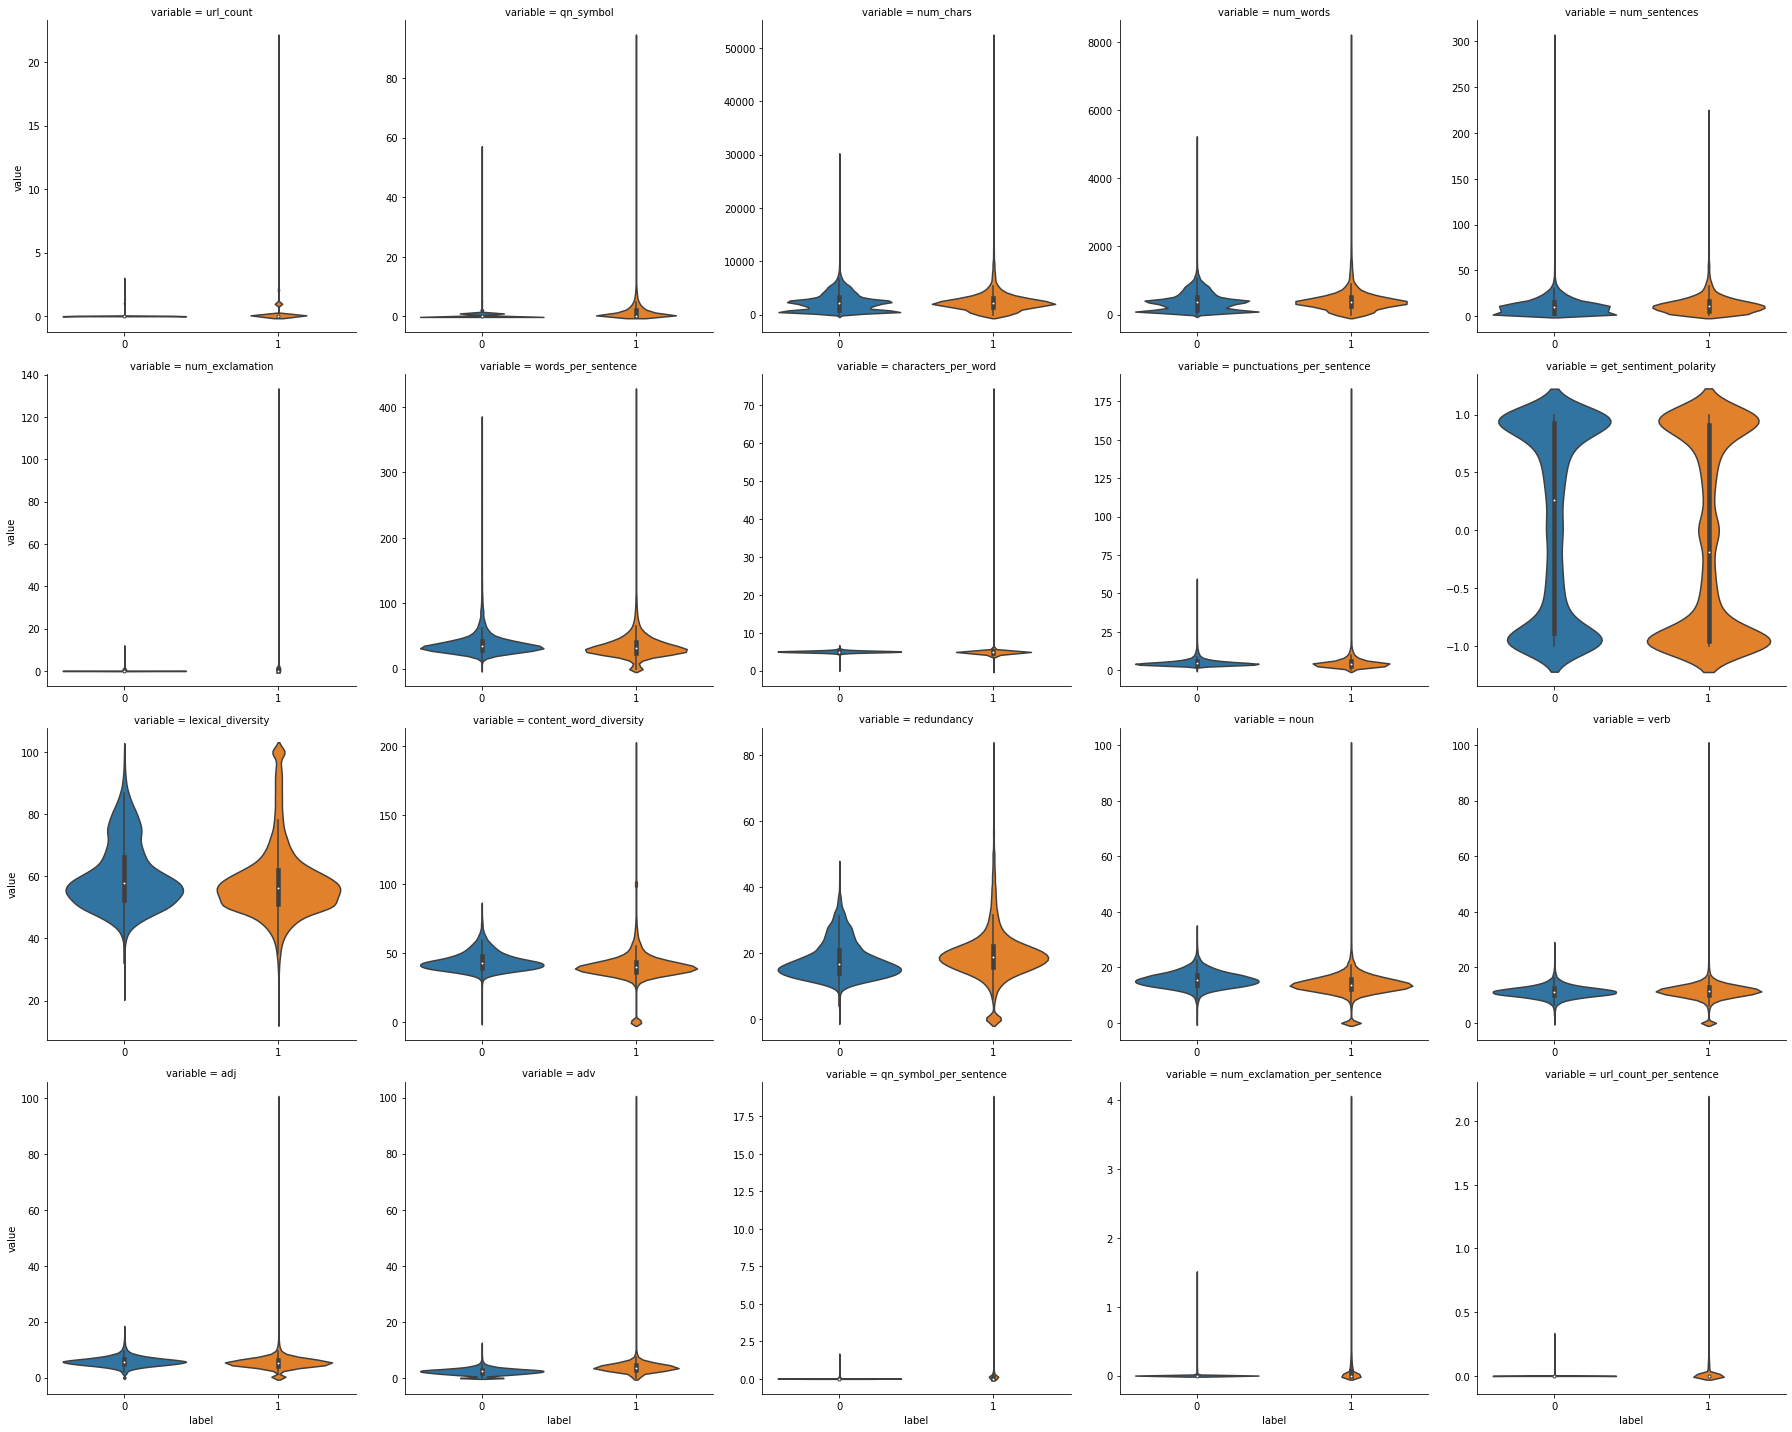

In [20]:
f = pd.melt( all_df["isot"], id_vars='label', value_vars=sementic_features)

g = sns.catplot(x="label" ,y="value",
                col="variable",col_wrap=5,
                data=f, kind="violin",sharey=False,sharex=False);

## Kaggle

In [ ]:
# f = pd.melt( all_df["kaggle"], id_vars='label', value_vars=sementic_features)

# g = sns.catplot(x="label" ,y="value",
#                 col="variable",col_wrap=5,
#                 data=f, kind="violin",sharey=False,sharex=False);

## kaggleRealFake

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3806: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)


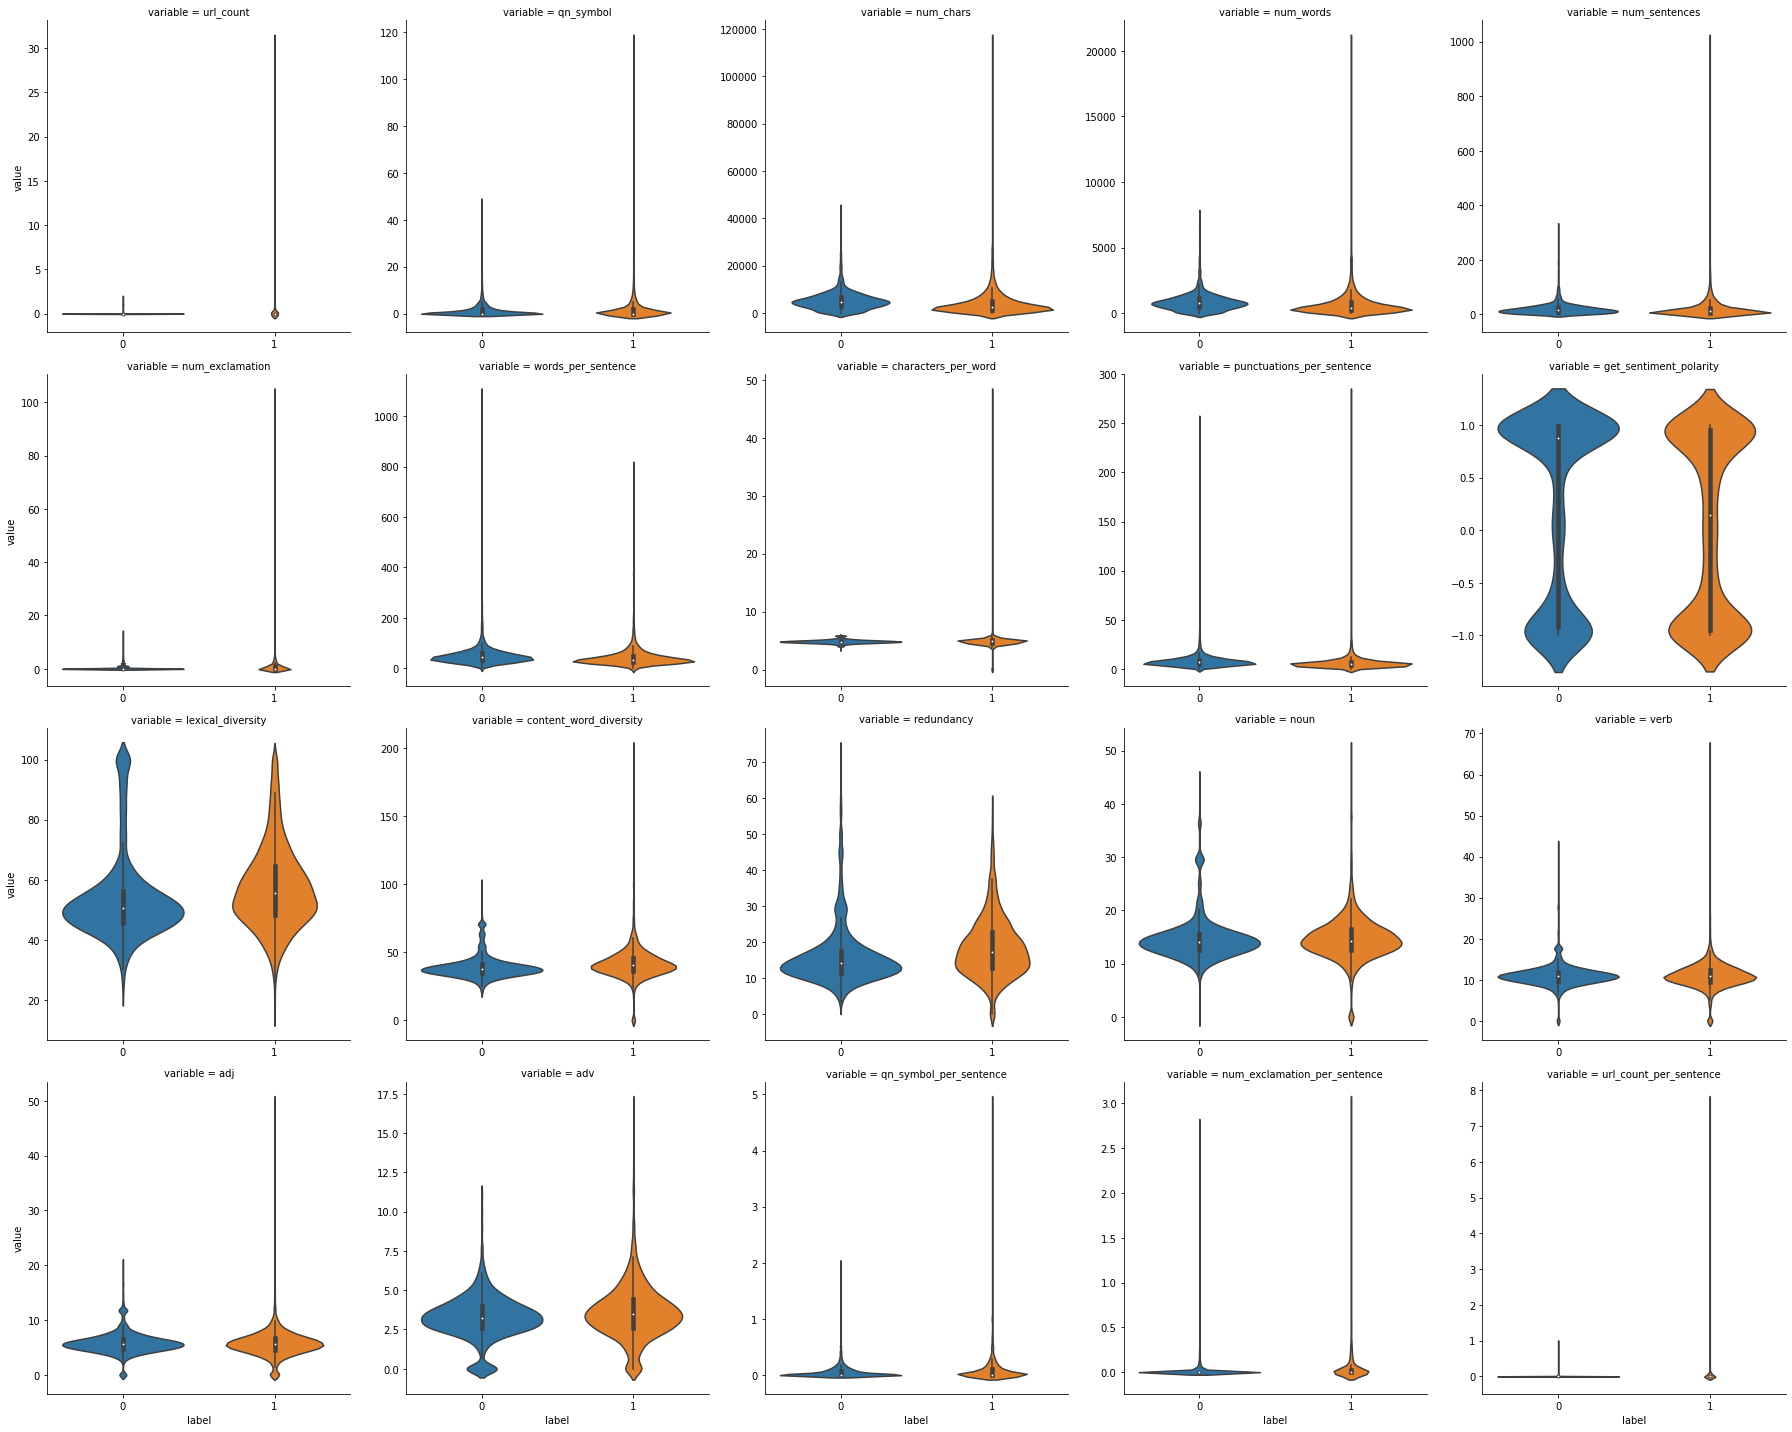

In [22]:
f = pd.melt( all_df["kagglerealfake"], id_vars='label', value_vars=sementic_features)

g = sns.catplot(x="label" ,y="value",
                col="variable",col_wrap=5,
                data=f, kind="violin",sharey=False,sharex=False);

## Codalab

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3806: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)


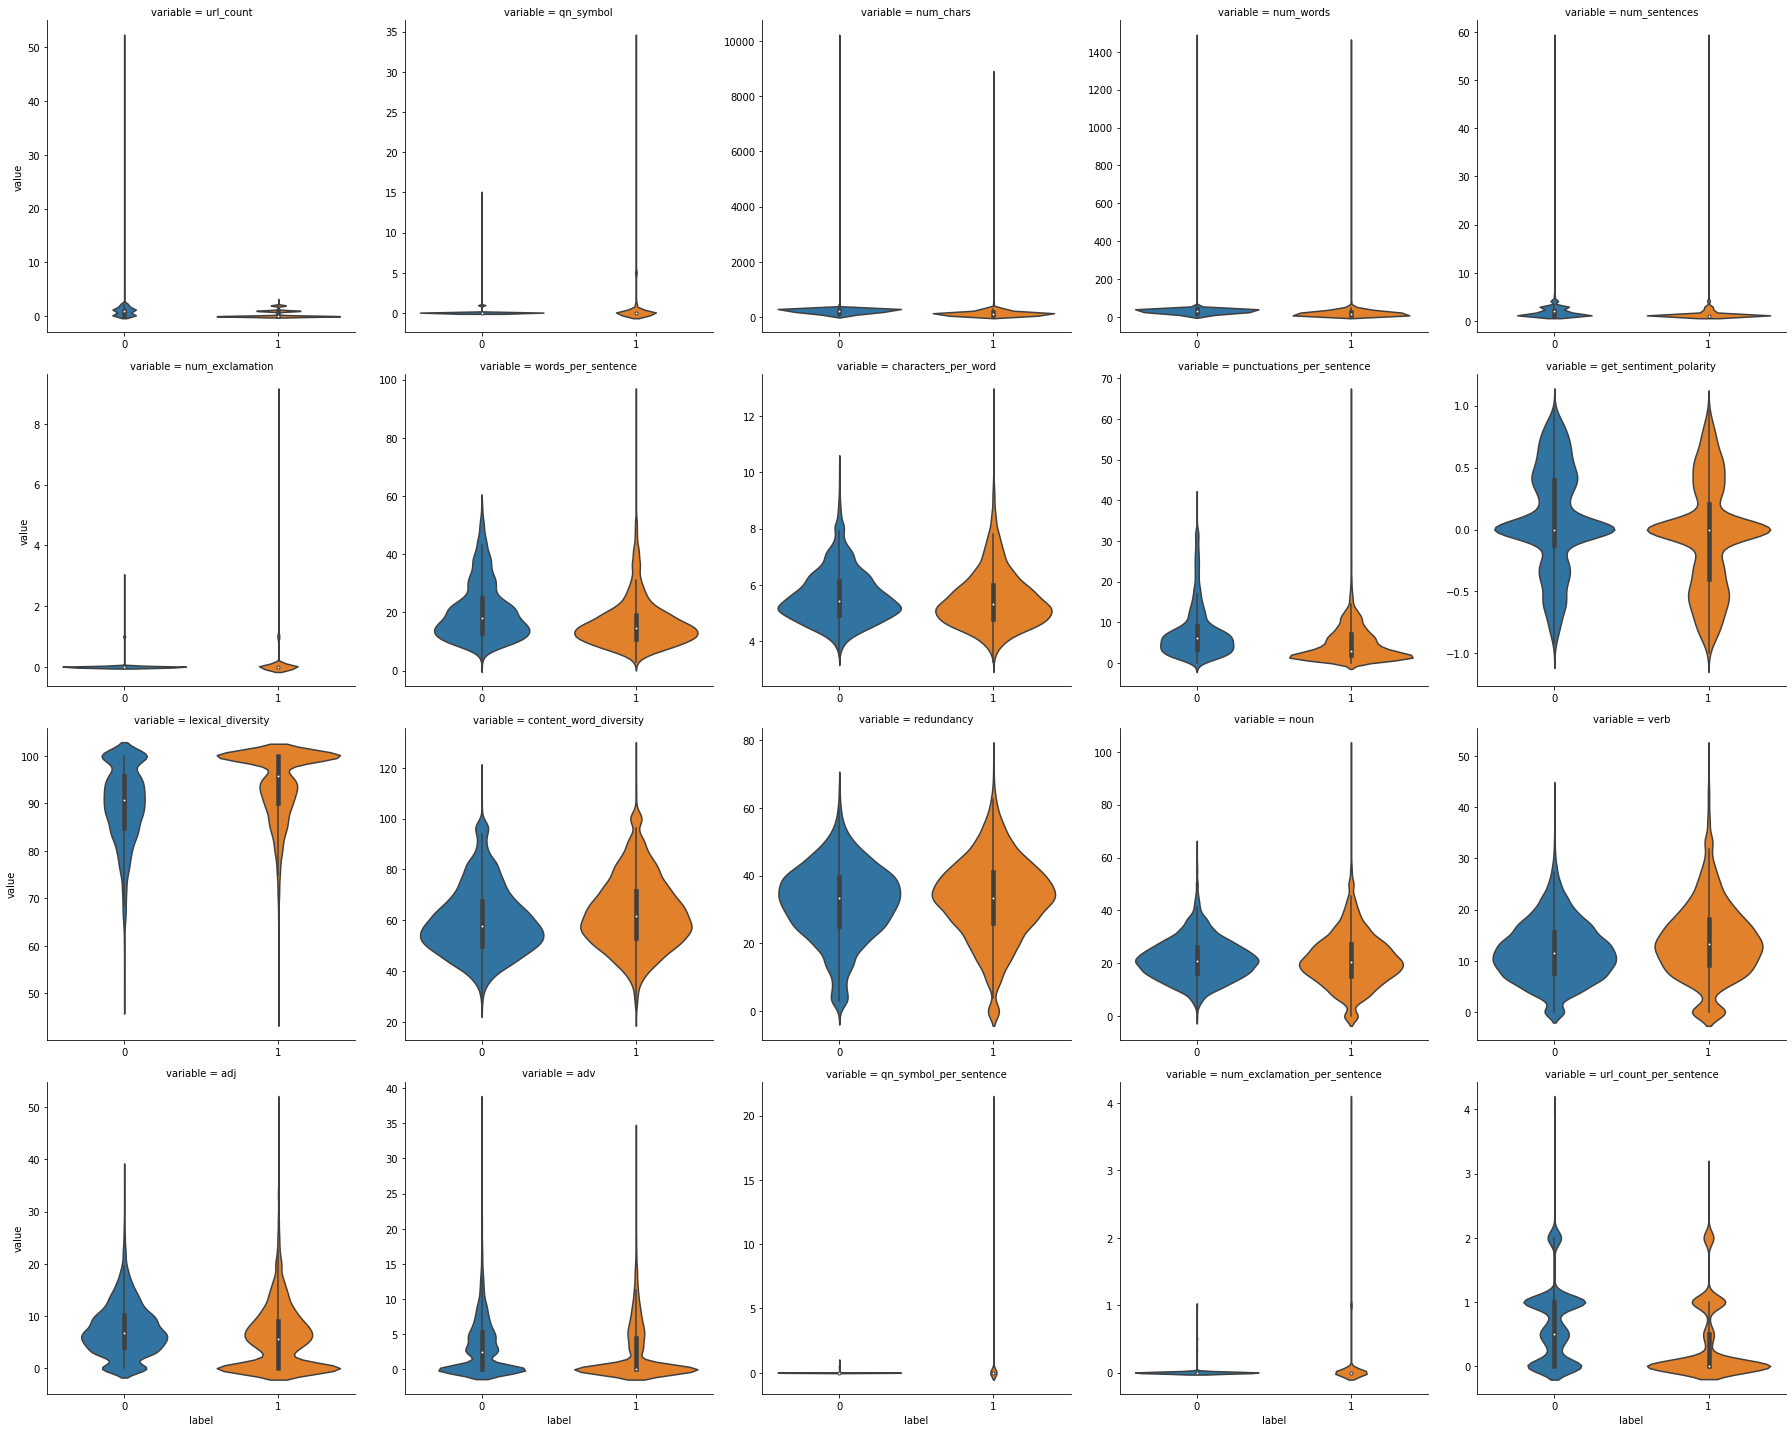

In [23]:
f = pd.melt( all_df["codalab"], id_vars='label', value_vars=sementic_features)

g = sns.catplot(x="label" ,y="value",
                col="variable",col_wrap=5,
                data=f, kind="violin",sharey=False,sharex=False);

## Liar

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3806: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)


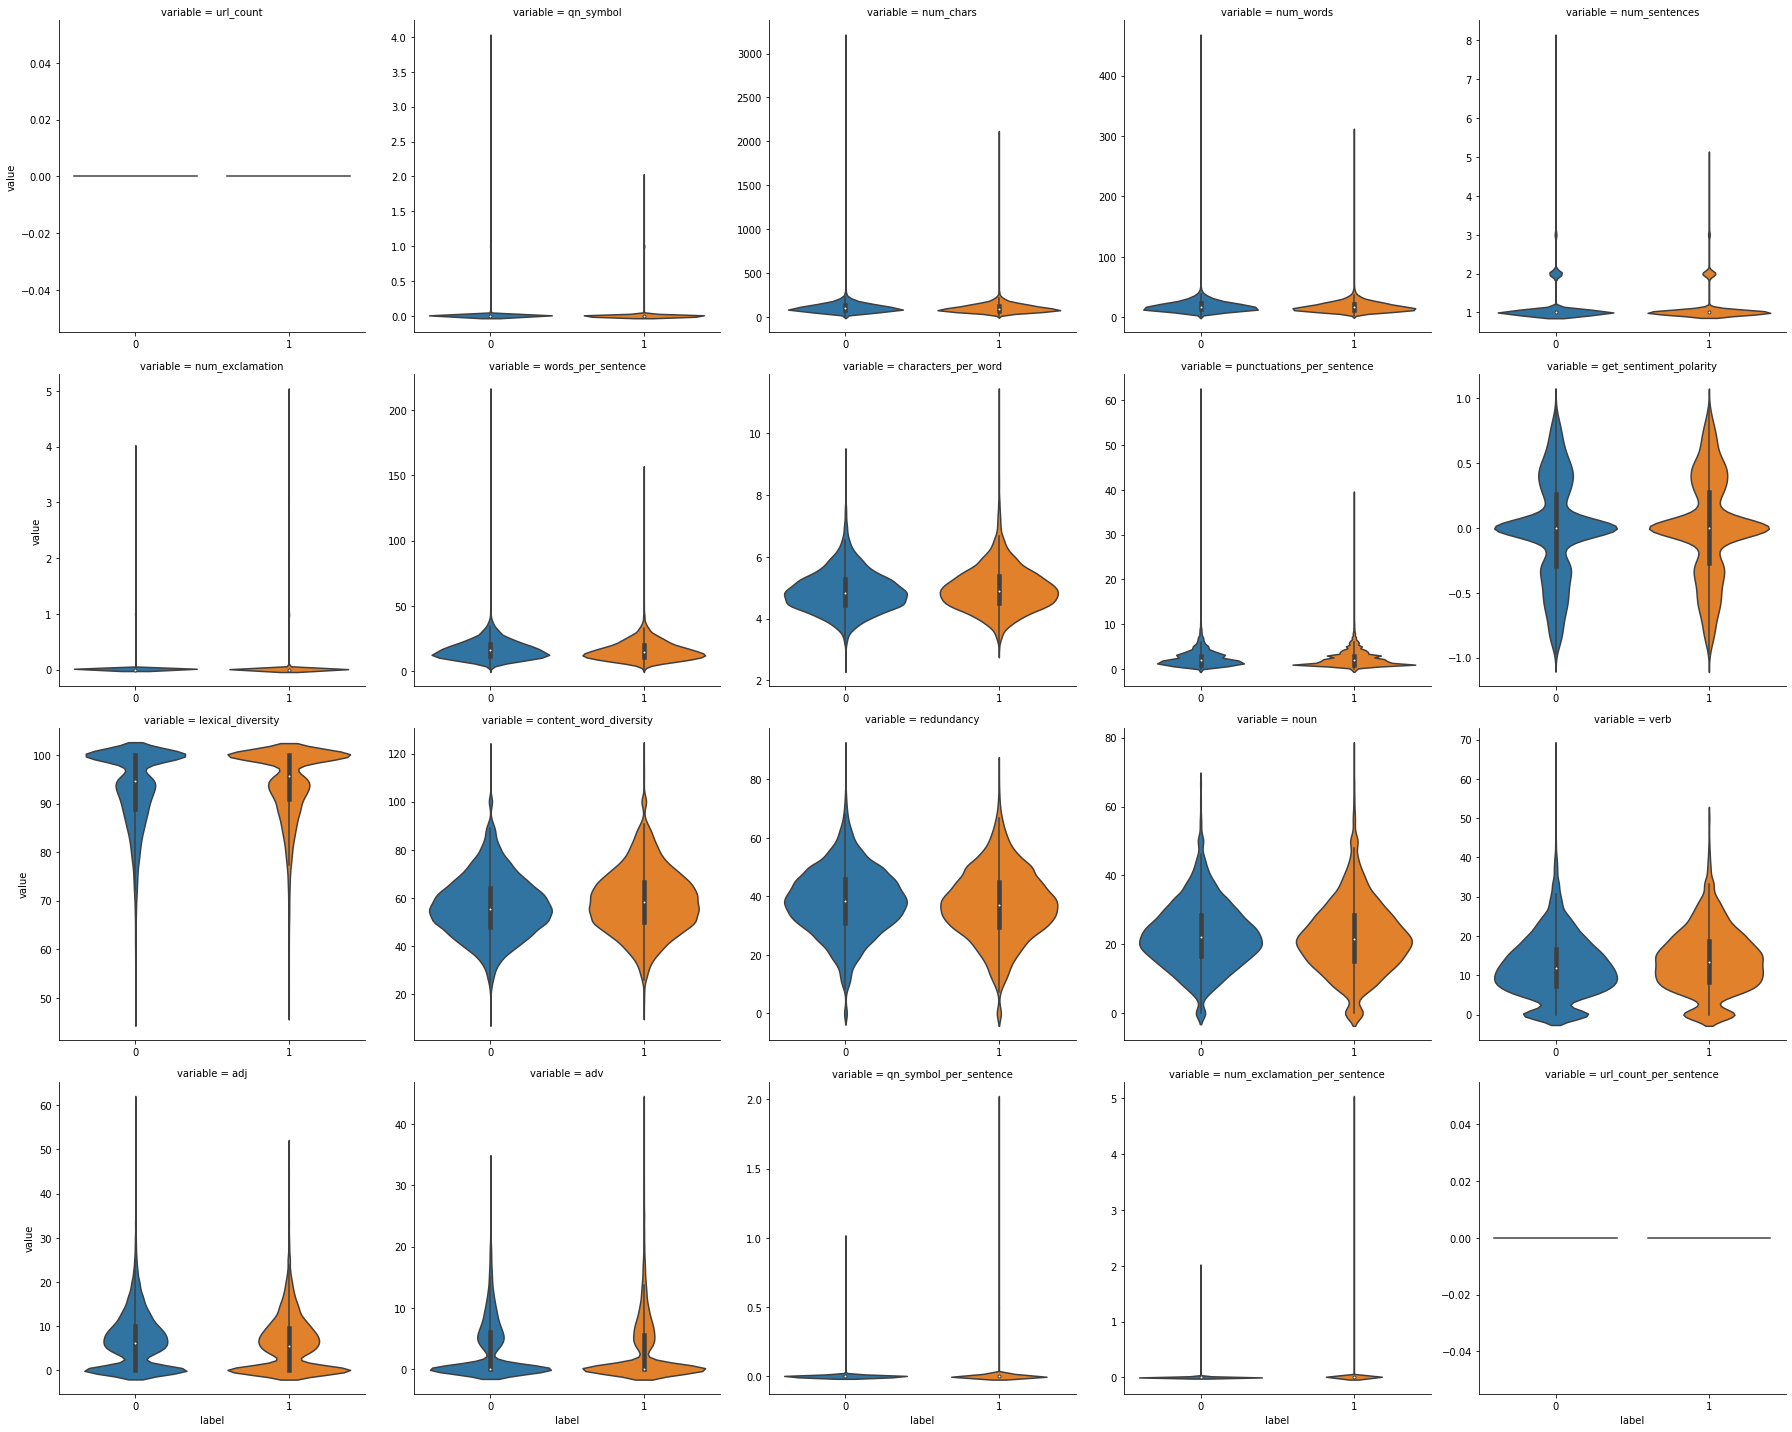

In [24]:
f = pd.melt( all_df["liar"], id_vars='label', value_vars=sementic_features)

g = sns.catplot(x="label" ,y="value",
                col="variable",col_wrap=5,
                data=f, kind="violin",sharey=False,sharex=False);

## Liar 1:5

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3806: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)


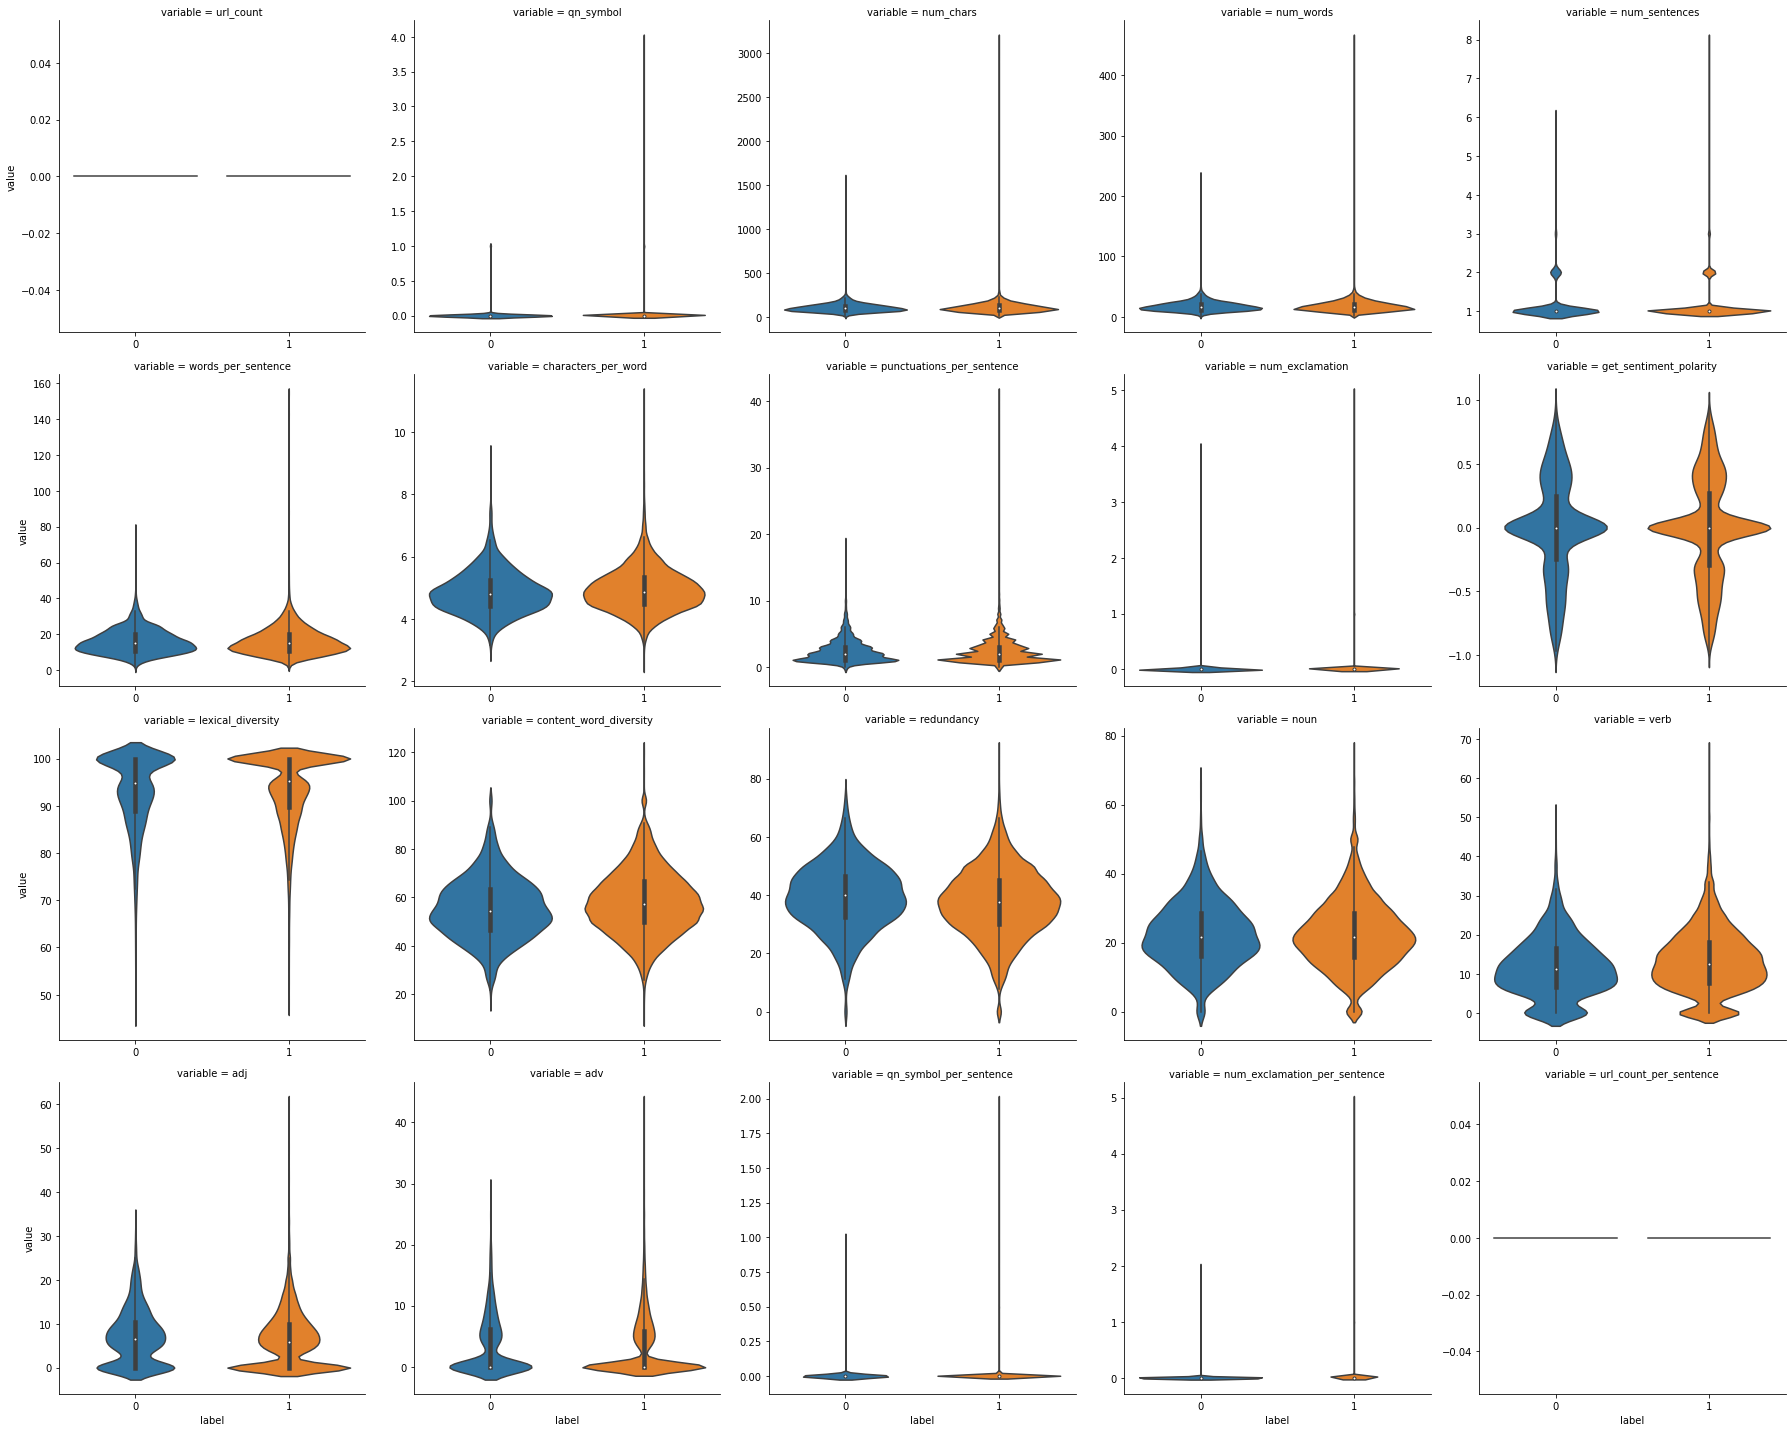

In [ ]:
# f = pd.melt( dfl, id_vars='label', value_vars=sementic_features)

# g = sns.catplot(x="label" ,y="value",
#                 col="variable",col_wrap=5,
#                 data=f, kind="violin",sharey=False,sharex=False);

## Welfake

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3806: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)


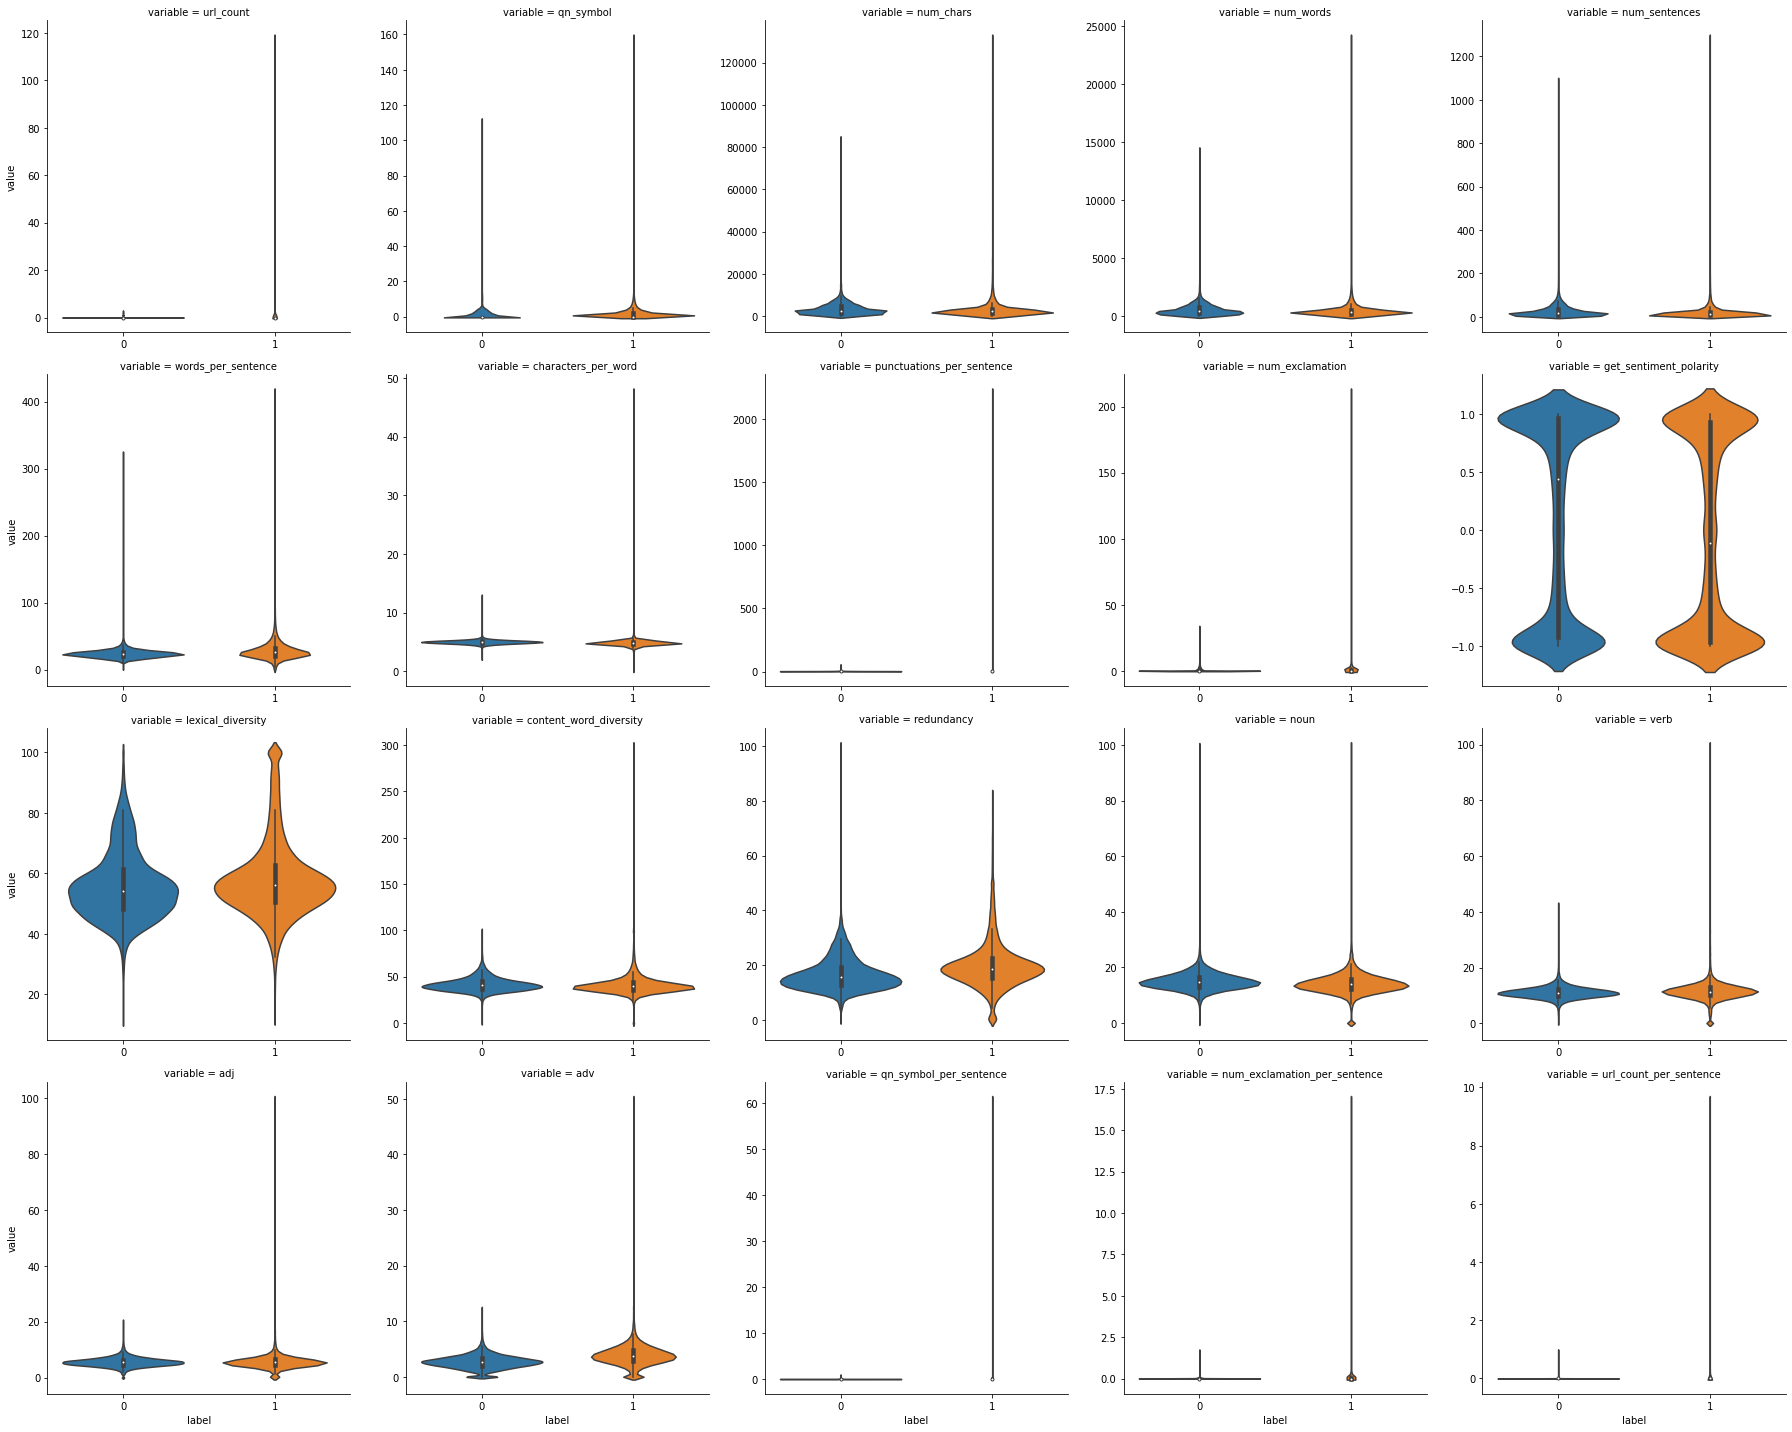

In [ ]:
# f = pd.melt( df["welfake"], id_vars='label', value_vars=sementic_features)

# g = sns.catplot(x="label" ,y="value",
#                 col="variable",col_wrap=5,
#                 data=f, kind="violin",sharey=False,sharex=False);

##  visualize

In [ ]:
# f = pd.melt( data[emot_null+["label"]], id_vars='label', value_vars=emot_null)

# g = sns.catplot(x="label" ,y="value",
#                 col="variable",col_wrap=5,
#                 data=f, kind="violin",sharey=False,sharex=False);

In [25]:
all_df.keys()

dict_keys(['codalab', 'fakenewsnet', 'isot', 'kagglerealfake', 'liar'])

In [ ]:
# f = pd.melt(df, id_vars='label', value_vars=sementic)

# g = sns.catplot(x="label" , y="value",
#                 col="variable",col_wrap=5,
#                 data=f, kind="violin",sharey=False,sharex=False);

In [ ]:
data.loc[data['adj_adv_ratio'] >10].shape

In [ ]:
data=data.loc[data['qn_symbol'] <6]
data=data.loc[data['num_exclamation'] <5]
data=data.loc[data['adv'] <9]
data=data.loc[data['adj'] <16]
data=data.loc[data['verb'] <25]
data=data.loc[df['url_count'] <5]
data=data.loc[df['num_chars'] <6000]
data=data.loc[df['words_per_sentence'] <100]
data=data.loc[df['characters_per_word'] <6]
data=data.loc[df['punctuations_per_sentence'] <20]
data=data.loc[df['negative'] <10]
data=data.loc[df['positive'] <10]
data=data.loc[df['punctuations_per_sentence'] <10]
data=data.loc[data['adj_adv_ratio'] <10]
data=data.loc[data['verb_noun_ratio'] <3]

In [ ]:
f = pd.melt( data[sementic+["label"]], id_vars='label', value_vars=sementic)

g = sns.catplot(x="label" , y="value",
                col="variable",col_wrap=5,
                data=f, kind="violin",sharey=False,sharex=False);

In [ ]:
# for i in features:
#   sns.violinplot(data=data,y=i,x='label' ,orient='v' ,scale="count")
#   plt.show()

In [ ]:
X.hist(figsize=(20,20), xrot=-45 ,)

In [ ]:
import seaborn as sns
# mask out upper triangle
mask = np.zeros_like(data.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(20,20))
sns.heatmap(data.corr(), 
           cmap='RdBu_r', 
           annot = True, 
           mask = mask
            )

In [ ]:
f = pd.melt( data[sementic+["label"]], id_vars='label', value_vars=sementic)
g = sns.FacetGrid( f, hue='label', col="variable", col_wrap=5, sharex=False, sharey=False ,legend_out=True)
g = g.map( sns.histplot, "value").add_legend() #kde=True to trend line

## DFALL

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3806: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)


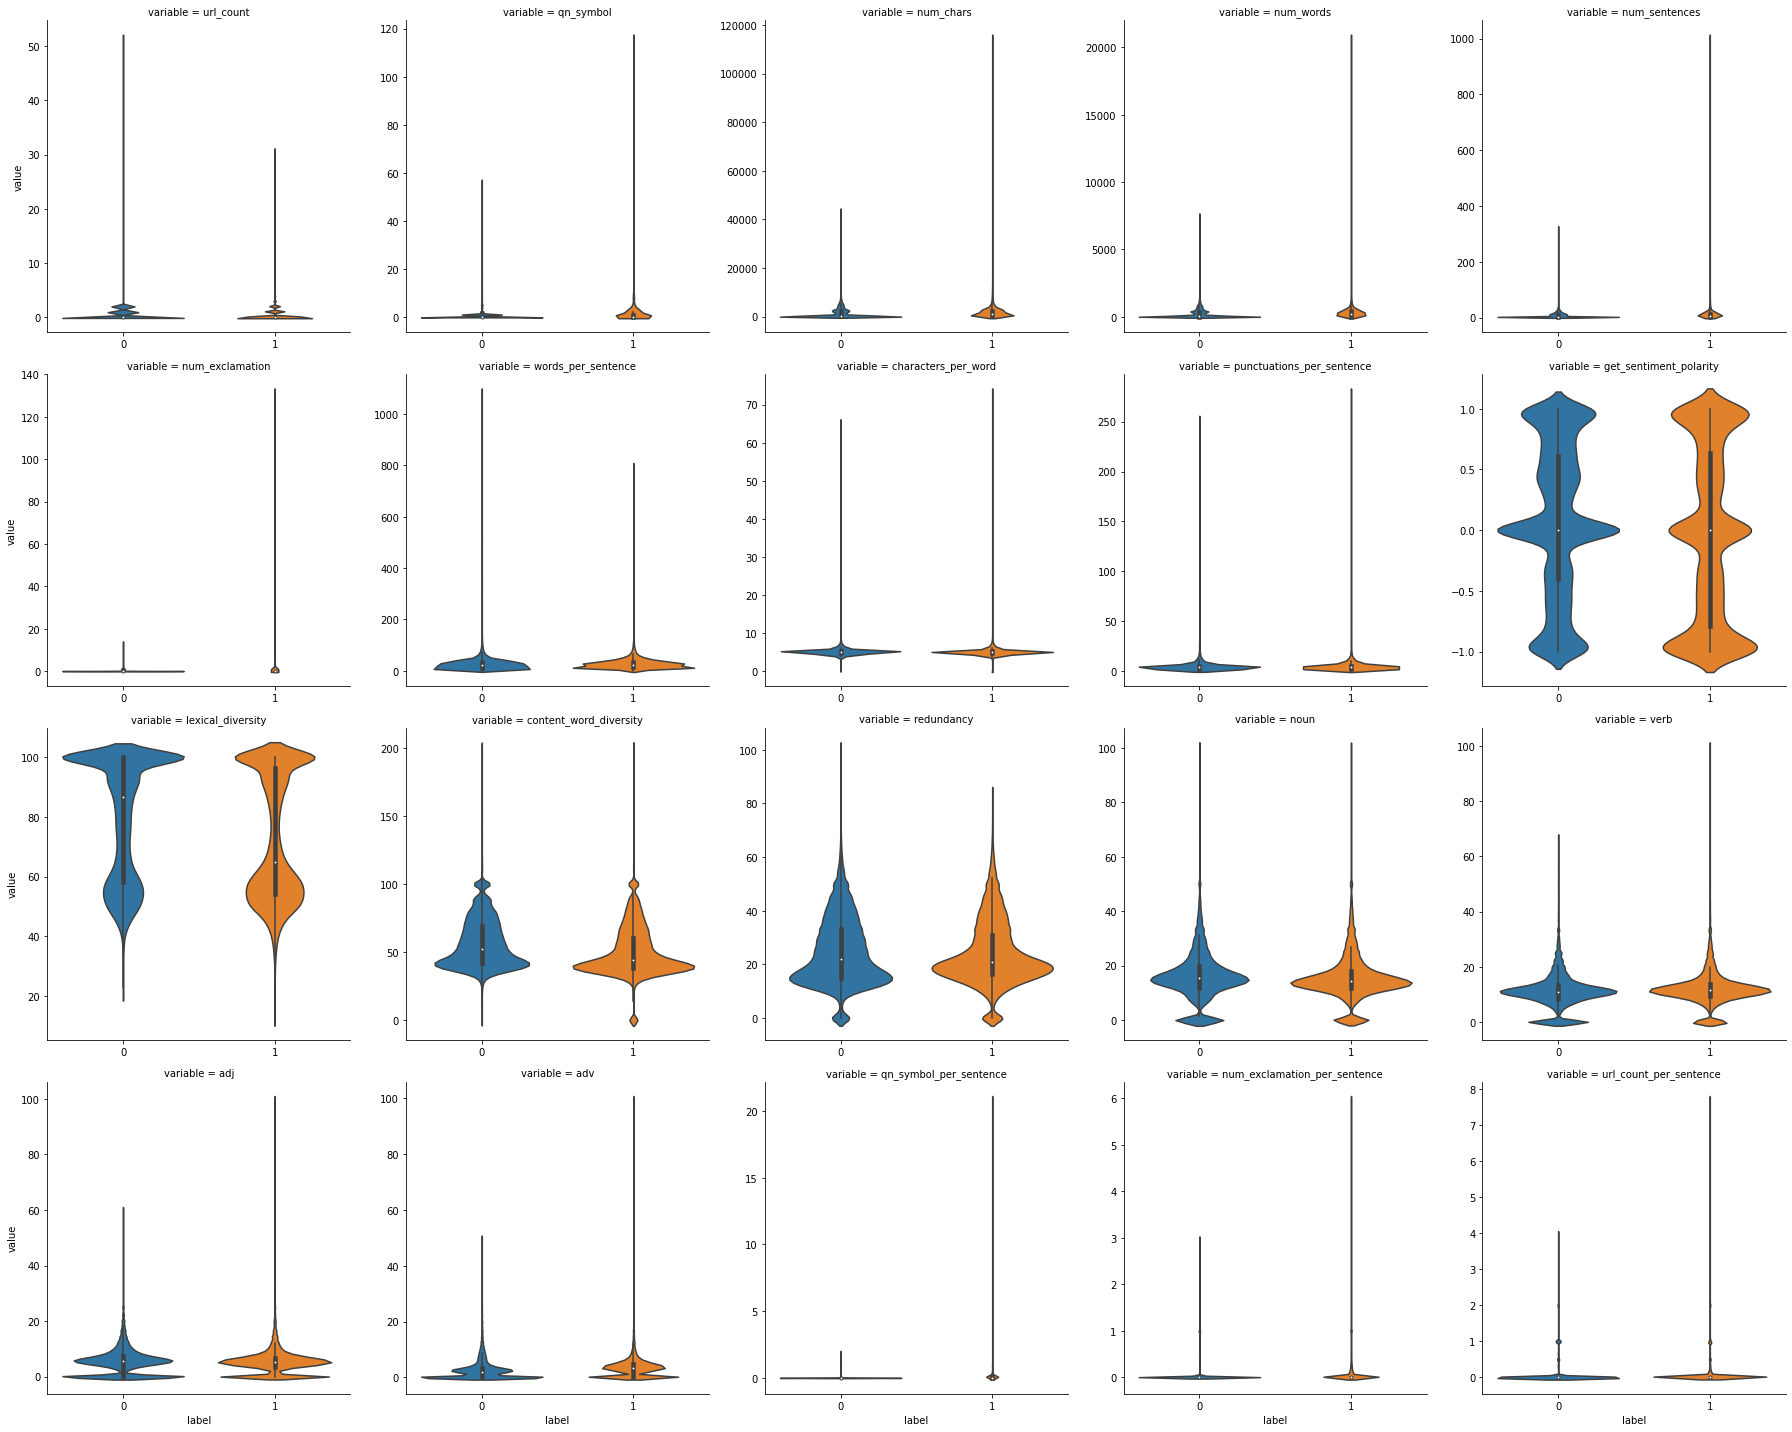

In [129]:
f = pd.melt( dfAll, id_vars='label', value_vars=sementic_features)

g = sns.catplot(x="label" ,y="value",
                col="variable",col_wrap=5,
                data=f, kind="violin",sharey=False,sharex=False);

# feature analysis

## feature analysis fakenewsnet

In [ ]:
# len(df["fakenewsnet"]['text'])-len(df["fakenewsnet"]['text'].drop_duplicates())

In [27]:
X=all_df["fakenewsnet"][sementic_features]
Y=all_df["fakenewsnet"].label

In [28]:
Y.value_counts()

0    17441
1     5755
Name: label, dtype: int64

In [29]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.3, random_state=142,stratify=Y)

In [30]:
X.head()

url_count  qn_symbol  num_chars  num_words  num_sentences  num_exclamation  \
0          0          1         56          9              1                0   
1          0          0         98         14              1                0   
2          0          0         53          9              1                0   
3          0          0         80         13              1                0   
4          0          0         45          8              1                0   

   words_per_sentence  characters_per_word  punctuations_per_sentence  \
0                 9.0             5.222222                        1.0   
1                14.0             5.714286                        2.0   
2                 9.0             5.000000                        0.0   
3                13.0             4.857143                        1.0   
4                 8.0             5.285714                        0.0   

   get_sentiment_polarity  lexical_diversity  content_word_diversity  \
0                  0.0000              100.0               66.666667   
1                  0.4939              100.0               78.571429   
2                  0.0516              100.0               77.777778   
3                  0.0000              100.0               76.923077   
4                  0.0000              100.0               85.714286   

   redundancy       noun       verb        adj        adv  \
0   33.333333   0.000000   0.000000  11.111111  11.111111   
1   28.571429  14.285714   7.142857   7.142857   0.000000   
2   22.222222  11.111111  11.111111   0.000000   0.000000   
3   23.076923  15.384615  15.384615   0.000000   0.000000   
4   28.571429  14.285714   0.000000  14.285714   0.000000   

   qn_symbol_per_sentence  num_exclamation_per_sentence  \
0                     1.0                           0.0   
1                     0.0                           0.0   
2                     0.0                           0.0   
3                     0.0                           0.0   
4                     0.0                           0.0   

   url_count_per_sentence  
0                     0.0  
1                     0.0  
2                     0.0  
3                     0.0  
4                     0.0

In [ ]:
# Feature ranking with recursive feature elimination and cross-validated selection of the best number of features

In [31]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

Optimal number of features : 17


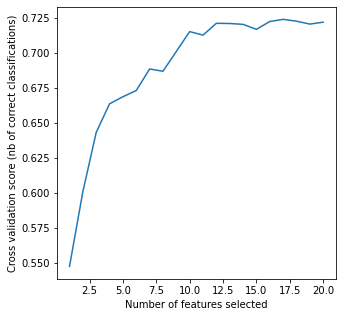

In [40]:
from sklearn.ensemble import RandomForestClassifier
clf=RandomForestClassifier(n_estimators=100,max_features='auto',random_state=0,max_depth=14,class_weight='balanced')
rfecv = RFECV(estimator=clf, step=1, cv=StratifiedKFold(),scoring='accuracy')
rfecv.fit(X_train, y_train)

print("Optimal number of features : %d" % rfecv.n_features_)

plt.figure(figsize=(5,5))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.cv_results_["mean_test_score"]) + 1), rfecv.cv_results_["mean_test_score"])
plt.show()

In [41]:
rfecv.cv_results_["mean_test_score"]

array([0.54763753, 0.60109626, 0.64340788, 0.6638547 , 0.66890451,
       0.67333964, 0.68873595, 0.68713447, 0.7012383 , 0.71546424,
       0.7129387 , 0.72137703, 0.72125355, 0.72063811, 0.71706589,
       0.72267055, 0.72420975, 0.72291687, 0.72082314, 0.72217708])

In [43]:
rfecv.support_

array([False,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False])

In [44]:
rfecv.ranking_

array([4, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3])

In [45]:
print(X_train.columns.values[rfecv.support_])

['qn_symbol' 'num_chars' 'num_words' 'num_exclamation'
 'words_per_sentence' 'characters_per_word' 'punctuations_per_sentence'
 'get_sentiment_polarity' 'lexical_diversity' 'content_word_diversity'
 'redundancy' 'noun' 'verb' 'adj' 'adv' 'qn_symbol_per_sentence'
 'num_exclamation_per_sentence']


In [46]:
rfecv.estimator_

RandomForestClassifier(class_weight='balanced', max_depth=14, random_state=0)

In [47]:
rfecv_features=list(X_train.columns.values[rfecv.support_])

In [48]:
rfecv_features

['qn_symbol',
 'num_chars',
 'num_words',
 'num_exclamation',
 'words_per_sentence',
 'characters_per_word',
 'punctuations_per_sentence',
 'get_sentiment_polarity',
 'lexical_diversity',
 'content_word_diversity',
 'redundancy',
 'noun',
 'verb',
 'adj',
 'adv',
 'qn_symbol_per_sentence',
 'num_exclamation_per_sentence']

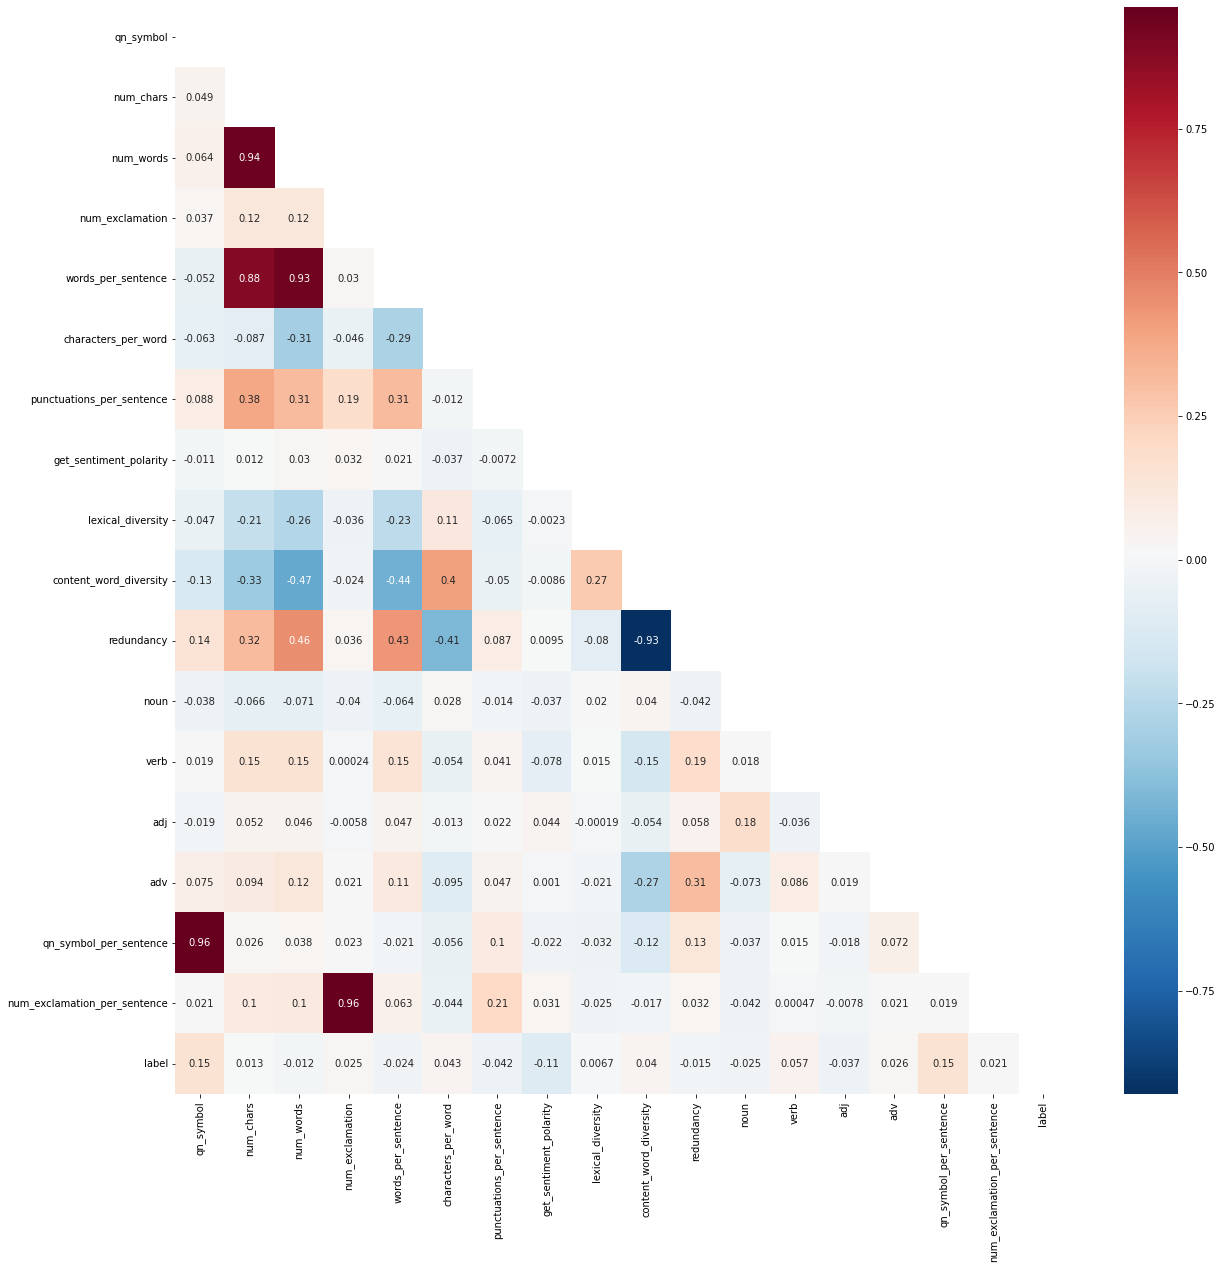

In [52]:
# mask out upper triangle
mask = np.zeros_like(all_df["fakenewsnet"][rfecv_features+["label"]].corr(), dtype=bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(20,20))
sns.heatmap(all_df["fakenewsnet"][rfecv_features+["label"]].corr(), 
           cmap='RdBu_r', 
           annot = True, 
           mask = mask
            )

In [ ]:
from sklearn import metrics
predicted_y = rfecv.predict(X_val)
gg=compute_metrics(predicted_y,y_val)
d=gg
tn, fp, fn, tp = d["confusiton_mat"].ravel()
print("{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}".format('prec-t','prec-f', 'rec-t','rec-f','f1-t','f1-f','accu','tn', 'fp', 'fn', 'tp'))  # correct
print ("{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:}\t{:}\t{:}\t{:}".format(d['precision'][0],d['precision'][1], d['recall'][0],d['recall'][1],d['f1'][0],d['f1'][1],d['accuracy'],tn, fp, fn, tp))

In [ ]:
rfecFakenewsnet=rfecv

In [ ]:
# prec-t	prec-f	rec-t	rec-f	f1-t	f1-f	accu	tn	fp	fn	tp
# 0.804	0.408	0.807	0.403	0.805	0.405	0.707	4222	1010	1031	696

# prec-t	prec-f	rec-t	rec-f	f1-t	f1-f	accu	tn	fp	fn	tp
# 0.788	0.367	0.840	0.291	0.813	0.325	0.707	4151	790	1118	459

# prec-t	prec-f	rec-t	rec-f	f1-t	f1-f	accu	tn	fp	fn	tp
# 0.793	0.360	0.806	0.340	0.800	0.350	0.694	3984	956	1041	537

## feature analysis Codalab

In [ ]:
# len(df["liar"]['text'])-len(df["liar"]['text'].drop_duplicates())

In [64]:
X=all_df["codalab"][sementic_features].copy()
Y=all_df["codalab"].label.copy()

In [58]:
all_df["codalab"].label.value_counts()

0    5600
1    5100
Name: label, dtype: int64

In [65]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.3, random_state=142,stratify=Y)

In [67]:
X.head()

url_count  qn_symbol  num_chars  num_words  num_sentences  num_exclamation  \
0          1          0        185         28              3                0   
1          0          0         38          7              1                0   
2          1          0        124         17              1                0   
3          1          0        264         39              3                0   
4          1          0        176         25              1                0   

   words_per_sentence  characters_per_word  punctuations_per_sentence  \
0            9.333333             5.344828                   2.666667   
1            7.000000             4.428571                   2.000000   
2           17.000000             5.833333                   7.000000   
3           13.000000             5.550000                   2.666667   
4           25.000000             5.555556                   7.000000   

   get_sentiment_polarity  lexical_diversity  content_word_diversity  \
0                  0.0000         100.000000               71.428571   
1                  0.0000         100.000000               42.857143   
2                  0.0000          94.117647               47.058824   
3                 -0.9042          89.743590               66.666667   
4                  0.3182          84.000000               48.000000   

   redundancy       noun       verb        adj       adv  \
0   28.571429  25.000000  14.285714  14.285714  0.000000   
1   57.142857  28.571429   0.000000  14.285714  0.000000   
2   47.058824   5.882353  17.647059   0.000000  0.000000   
3   25.641026  35.897436  12.820513   5.128205  5.128205   
4   40.000000  16.000000   4.000000  12.000000  4.000000   

   qn_symbol_per_sentence  num_exclamation_per_sentence  \
0                     0.0                           0.0   
1                     0.0                           0.0   
2                     0.0                           0.0   
3                     0.0                           0.0   
4                     0.0                           0.0   

   url_count_per_sentence  
0                0.333333  
1                0.000000  
2                1.000000  
3                0.333333  
4                1.000000

In [ ]:
# Feature ranking with recursive feature elimination and cross-validated selection of the best number of features

In [68]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

Optimal number of features : 20


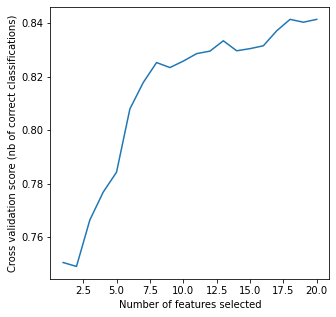

In [69]:
from sklearn.ensemble import RandomForestClassifier
clf=RandomForestClassifier(n_estimators=100,max_features='auto',random_state=0,max_depth=14,class_weight='balanced')
rfecv = RFECV(estimator=clf, step=1, cv=StratifiedKFold(),scoring='accuracy')
rfecv.fit(X_train, y_train)

print("Optimal number of features : %d" % rfecv.n_features_)

plt.figure(figsize=(5,5))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.cv_results_["mean_test_score"]) + 1), rfecv.cv_results_["mean_test_score"])
plt.show()

In [70]:
rfecv.cv_results_["mean_test_score"]

array([0.75046729, 0.74899866, 0.76635514, 0.77676903, 0.78424566,
       0.80787717, 0.81775701, 0.82523364, 0.82336449, 0.82576769,
       0.82857143, 0.82950601, 0.83337784, 0.82963952, 0.83044059,
       0.83150868, 0.83711615, 0.84138852, 0.84032043, 0.84138852])

In [71]:
rfecv.support_

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [72]:
rfecv.ranking_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [73]:
print(X_train.columns.values[rfecv.support_])

['url_count' 'qn_symbol' 'num_chars' 'num_words' 'num_sentences'
 'num_exclamation' 'words_per_sentence' 'characters_per_word'
 'punctuations_per_sentence' 'get_sentiment_polarity' 'lexical_diversity'
 'content_word_diversity' 'redundancy' 'noun' 'verb' 'adj' 'adv'
 'qn_symbol_per_sentence' 'num_exclamation_per_sentence'
 'url_count_per_sentence']


In [74]:
rfecv.estimator_

RandomForestClassifier(class_weight='balanced', max_depth=14, random_state=0)

In [75]:
rfecv_features=list(X_train.columns.values[rfecv.support_])

In [76]:
rfecv_features

['url_count',
 'qn_symbol',
 'num_chars',
 'num_words',
 'num_sentences',
 'num_exclamation',
 'words_per_sentence',
 'characters_per_word',
 'punctuations_per_sentence',
 'get_sentiment_polarity',
 'lexical_diversity',
 'content_word_diversity',
 'redundancy',
 'noun',
 'verb',
 'adj',
 'adv',
 'qn_symbol_per_sentence',
 'num_exclamation_per_sentence',
 'url_count_per_sentence']

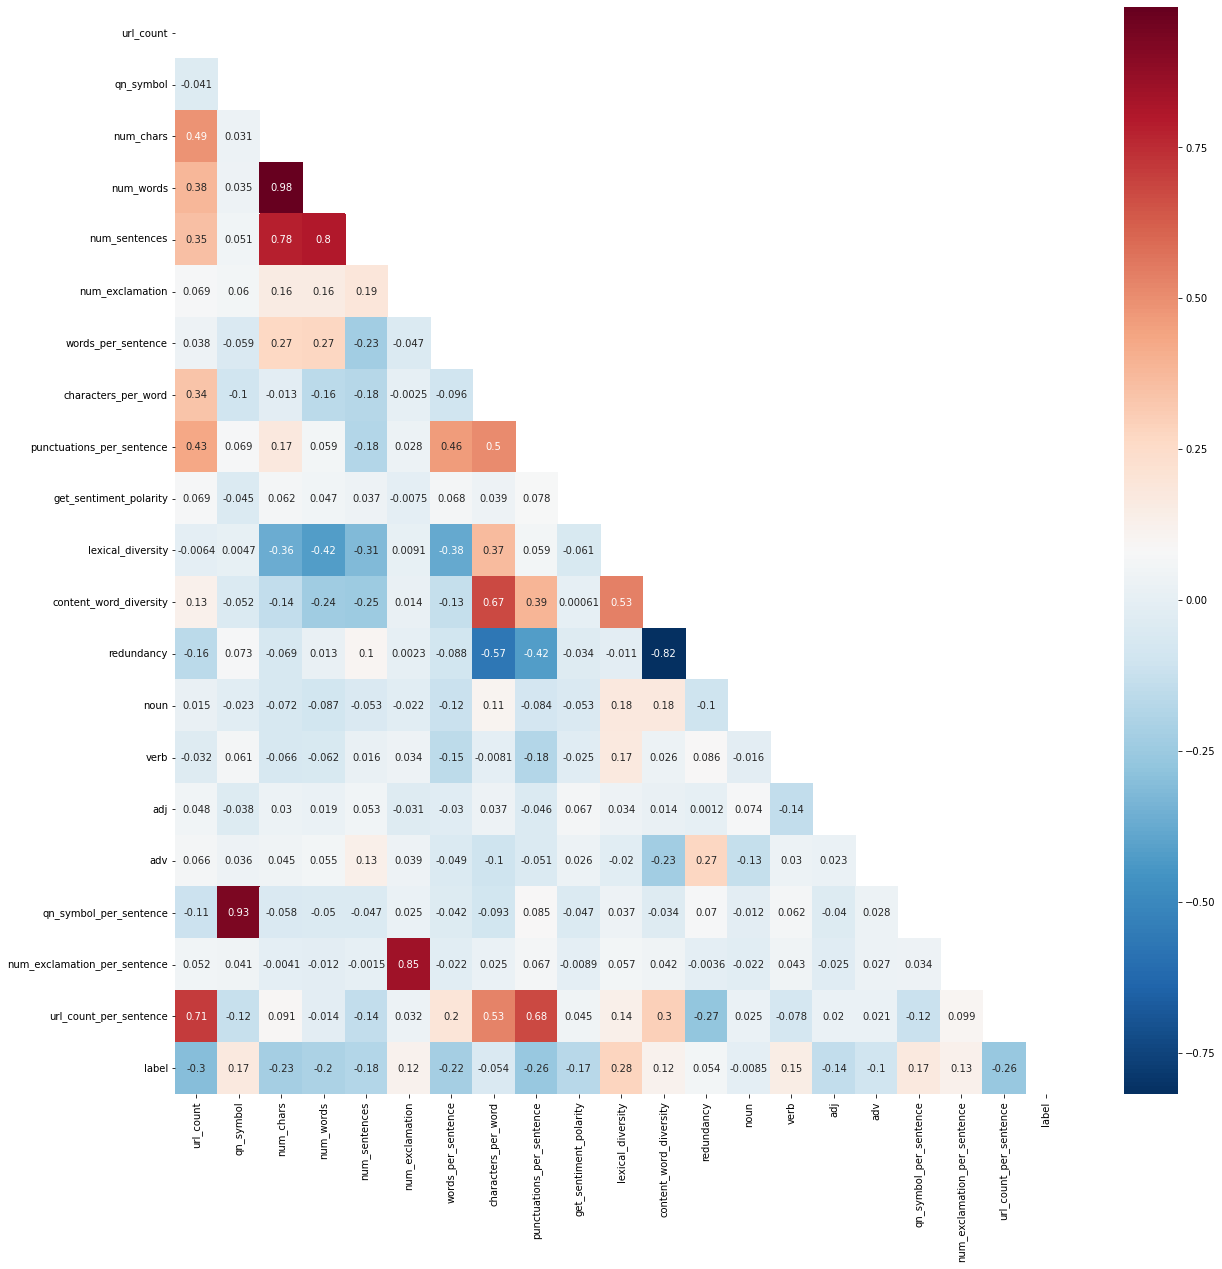

In [78]:
# mask out upper triangle
mask = np.zeros_like(all_df["codalab"][rfecv_features+["label"]].corr(), dtype=bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(20,20))
sns.heatmap(all_df["codalab"][rfecv_features+["label"]].corr(), 
           cmap='RdBu_r', 
           annot = True, 
           mask = mask
            )

In [ ]:
from sklearn import metrics
predicted_y = rfecv.predict(X_val)
gg=compute_metrics(predicted_y,y_val)
d=gg
tn, fp, fn, tp = d["confusiton_mat"].ravel()
# tn,fp,fn,tp=0,0,0,0
print("{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}".format('prec-t','prec-f', 'rec-t','rec-f','f1-t','f1-f','accu','tn', 'fp', 'fn', 'tp'))  # correct
print ("{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:}\t{:}\t{:}\t{:}".format(d['precision'][0],d['precision'][1], d['recall'][0],d['recall'][1],d['f1'][0],d['f1'][1],d['accuracy'],tn, fp, fn, tp))

prec-t	prec-f	rec-t	rec-f	f1-t	f1-f	accu	tn	fp	fn	tp
0.821	0.880	0.903	0.784	0.860	0.829	0.846	1011	109	220	800


In [ ]:
# prec-t	prec-f	rec-t	rec-f	f1-t	f1-f	accu	tn	fp	fn	tp
# 0.210	0.219	0.208	0.193	0.209	0.205	0.212	0	0	0	0    6 label

In [ ]:
codelabrfecv=rfecv

## feature analysis isot

In [79]:
X=df["isot"][sementic_features]
Y=df["isot"].label

In [80]:
Y.value_counts()

1    23481
0    21417
Name: label, dtype: int64

In [81]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.3, random_state=142,stratify=Y)

In [82]:
X.head()

url_count  qn_symbol  num_chars  num_words  num_sentences  num_exclamation  \
0          0          0       4659        745             26                0   
1          0          0       4077        621             21                0   
2          0          0       2789        456             13                0   
3          0          0       2461        375             15                0   
4          0          1       5204        851             30                1   

   words_per_sentence  characters_per_word  punctuations_per_sentence  \
0           28.653846             5.000000                   4.538462   
1           29.571429             5.328594                   3.666667   
2           35.076923             4.881466                   3.615385   
3           25.000000             5.302872                   3.400000   
4           28.366667             4.909091                   4.533333   

   get_sentiment_polarity  lexical_diversity  content_word_diversity  \
0                  0.9847          51.340483               38.926174   
1                 -0.5363          50.321543               38.164251   
2                 -0.6808          50.328228               35.964912   
3                 -0.2201          56.914894               41.600000   
4                  0.6683          46.009390               36.545241   

   redundancy       noun       verb       adj       adv  \
0   12.483221  13.959732  11.946309  6.442953  2.550336   
1   13.204509  13.526570  13.848631  4.347826  1.771337   
2   16.885965  12.500000  10.964912  4.824561  1.535088   
3   17.333333  13.333333  10.133333  7.200000  2.666667   
4   11.515864  14.806110   8.578143  5.757932  3.172738   

   qn_symbol_per_sentence  num_exclamation_per_sentence  \
0                0.000000                      0.000000   
1                0.000000                      0.000000   
2                0.000000                      0.000000   
3                0.000000                      0.000000   
4                0.033333                      0.033333   

   url_count_per_sentence  
0                     0.0  
1                     0.0  
2                     0.0  
3                     0.0  
4                     0.0

In [ ]:
# Feature ranking with recursive feature elimination and cross-validated selection of the best number of features

In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

Optimal number of features : 17


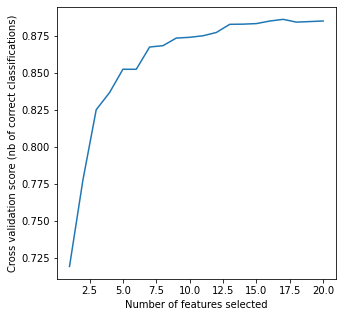

In [83]:
from sklearn.ensemble import RandomForestClassifier
clf=RandomForestClassifier(n_estimators=100,max_features='auto',random_state=0,max_depth=14,class_weight='balanced')
rfecv = RFECV(estimator=clf, step=1, cv=StratifiedKFold(),scoring='accuracy')
rfecv.fit(X_train, y_train)

print("Optimal number of features : %d" % rfecv.n_features_)

plt.figure(figsize=(5,5))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.cv_results_["mean_test_score"]) + 1), rfecv.cv_results_["mean_test_score"])
plt.show()

In [ ]:
rfecv.cv_results_["mean_test_score"]

array([0.92447271, 0.95755627, 0.96236464, 0.96749383, 0.97377702,
       0.97422588, 0.97435414, 0.97518764, 0.97640571, 0.97679051,
       0.97755981, 0.97832918, 0.97800853, 0.97852151, 0.97858563,
       0.97858561, 0.97794448, 0.97794455, 0.97768809, 0.97800857])

In [ ]:
rfecv.support_

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True, False, False, False,  True,  True,
        True, False])

In [ ]:
rfecv.ranking_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 5, 2, 4, 1, 1, 1, 6])

In [ ]:
print(X_train.columns.values[rfecv.support_])

['url_count' 'qn_symbol' 'num_chars' 'num_words' 'num_sentences'
 'words_per_sentence' 'characters_per_word' 'punctuations_per_sentence'
 'num_exclamation' 'get_sentiment_polarity' 'lexical_diversity'
 'redundancy' 'adv' 'qn_symbol_per_sentence'
 'num_exclamation_per_sentence']


In [ ]:
rfecv.estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=14, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [ ]:
rfecv_features=list(X_train.columns.values[rfecv.support_])

In [ ]:
rfecv_features

['url_count',
 'qn_symbol',
 'num_chars',
 'num_words',
 'num_sentences',
 'words_per_sentence',
 'characters_per_word',
 'punctuations_per_sentence',
 'num_exclamation',
 'get_sentiment_polarity',
 'lexical_diversity',
 'redundancy',
 'adv',
 'qn_symbol_per_sentence',
 'num_exclamation_per_sentence']

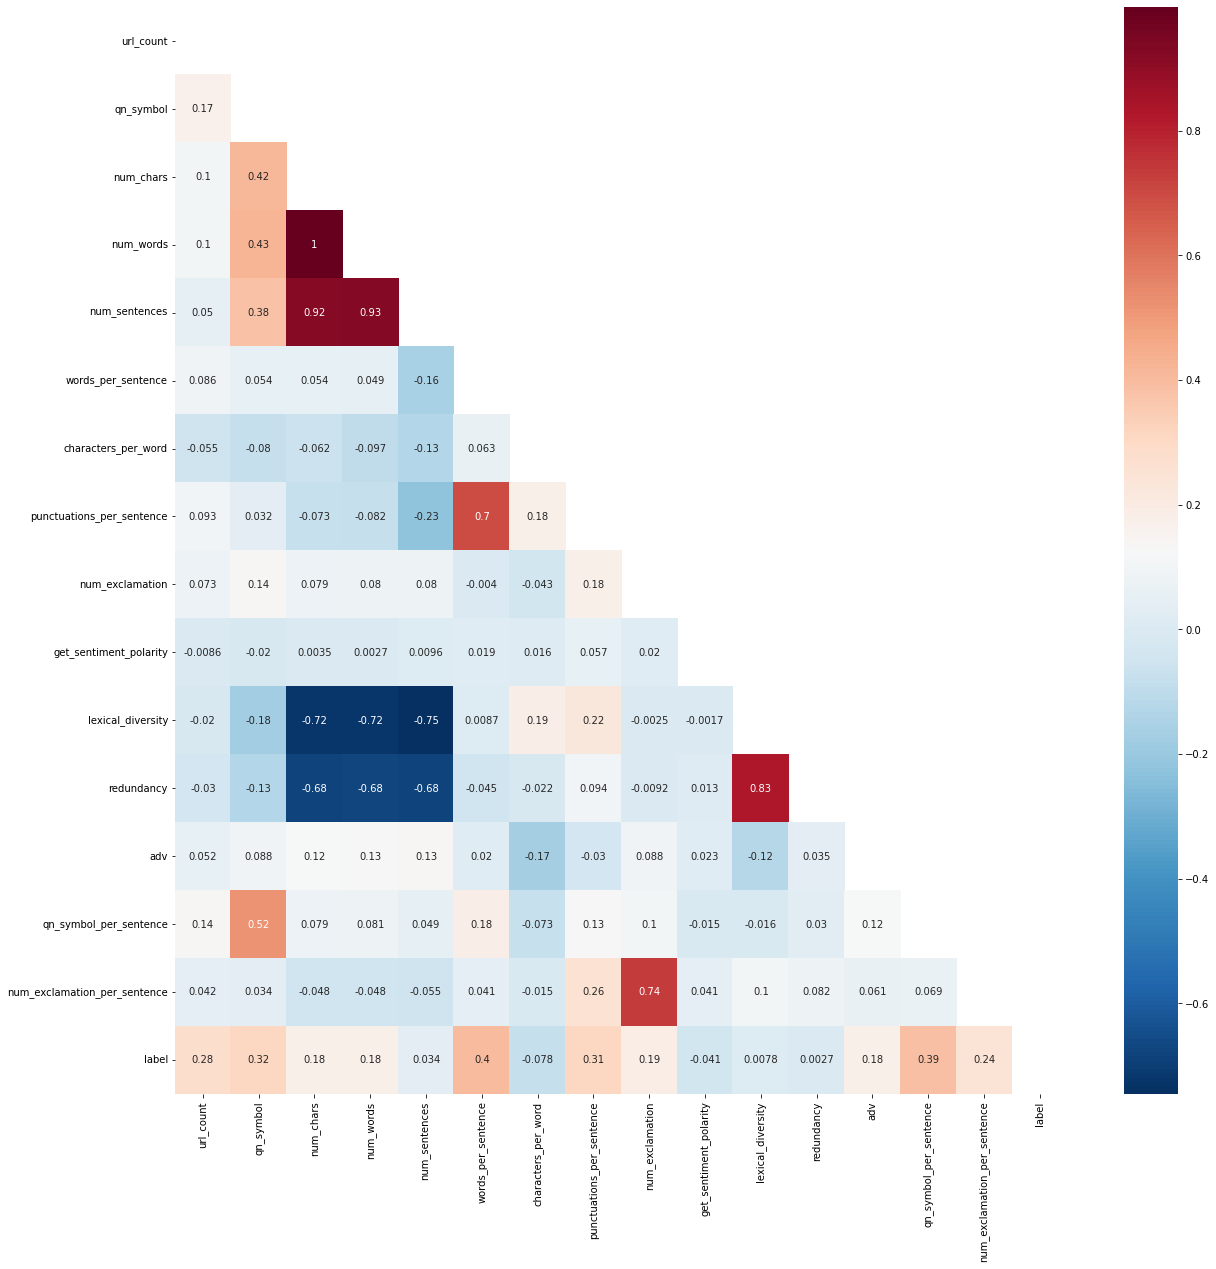

In [ ]:
# mask out upper triangle
mask = np.zeros_like(all_df["isot"][rfecv_features+["label"]].corr(), dtype=bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(20,20))
sns.heatmap(all_df["isot"][rfecv_features+["label"]].corr(), 
           cmap='RdBu_r', 
           annot = True, 
           mask = mask
            )

In [ ]:
from sklearn import metrics
predicted_y = rfecv.predict(X_val)
gg=compute_metrics(predicted_y,y_val)
d=gg
tn, fp, fn, tp = d["confusiton_mat"].ravel()
print("{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}".format('prec-t','prec-f', 'rec-t','rec-f','f1-t','f1-f','accu','tn', 'fp', 'fn', 'tp'))  # correct
print ("{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:}\t{:}\t{:}\t{:}".format(d['precision'][0],d['precision'][1], d['recall'][0],d['recall'][1],d['f1'][0],d['f1'][1],d['accuracy'],tn, fp, fn, tp))

prec-t	prec-f	rec-t	rec-f	f1-t	f1-f	accu	tn	fp	fn	tp
0.982	0.897	0.996	0.636	0.989	0.744	0.979	6334	24	119	208


In [ ]:
rfecisot=rfecv

In [ ]:
# prec-t	prec-f	rec-t	rec-f	f1-t	f1-f	accu	tn	fp	fn	tp  (f1 )
# 0.936	0.920	0.926	0.931	0.931	0.925	0.928	6523	522	446	5979

# prec-t	prec-f	rec-t	rec-f	f1-t	f1-f	accu	tn	fp	fn	tp (acc without removing counts)
# 0.923	0.926	0.909	0.938	0.916	0.932	0.925	4742	477	396	5957

# prec-t	prec-f	rec-t	rec-f	f1-t	f1-f	accu	tn	fp	fn	tp(acc after remov acc)
# 0.918	0.925	0.908	0.934	0.913	0.929	0.922	4740	479	421	5932

## feature analysis kaggle :NO

In [ ]:
# len(df["welfake"]['text'])-len(df["welfake"]['text'].drop_duplicates())

0

In [ ]:
X=df["kaggle"][sementic_features].copy()
Y=df["kaggle"].label.copy()

In [ ]:
df["kaggle"].label.value_counts()

T    21191
F    17455
Name: label, dtype: int64

In [ ]:
Y=Y.replace(to_replace={"T":0,"F":1})

In [ ]:
Y.value_counts()

0    21191
1    17455
Name: label, dtype: int64

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.3, random_state=142,stratify=Y)

In [ ]:
X.head()

url_count  qn_symbol  ...  num_exclamation_per_sentence  url_count_per_sentence
0          0          9  ...                      0.315789                0.000000
1          0          0  ...                      0.000000                0.000000
2          1          4  ...                      0.080000                0.040000
3          4          1  ...                      0.000000                0.307692
4          0          0  ...                      0.000000                0.000000

[5 rows x 20 columns]

In [ ]:
# Feature ranking with recursive feature elimination and cross-validated selection of the best number of features

In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

Optimal number of features : 18


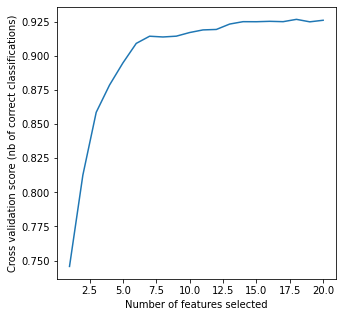

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf=RandomForestClassifier(n_estimators=100,max_features='auto',random_state=0,max_depth=14,class_weight='balanced')
rfecv = RFECV(estimator=clf, step=1, cv=StratifiedKFold(),scoring='accuracy')
rfecv.fit(X_train, y_train)

print("Optimal number of features : %d" % rfecv.n_features_)

plt.figure(figsize=(5,5))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.cv_results_["mean_test_score"]) + 1), rfecv.cv_results_["mean_test_score"])
plt.show()

In [ ]:
rfecv.grid_scores_

array([0.74574888, 0.81258334, 0.85856882, 0.87856716, 0.89472121,
       0.90902708, 0.91427629, 0.91372176, 0.91431315, 0.91697477,
       0.91889702, 0.91922967, 0.92318495, 0.9249225 , 0.92488548,
       0.92518122, 0.92492247, 0.92662288, 0.92481151, 0.92595755])

In [ ]:
rfecv.support_

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True])

In [ ]:
rfecv.ranking_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1])

In [ ]:
print(X_train.columns.values[rfecv.support_])

['url_count' 'qn_symbol' 'num_chars' 'num_words' 'num_sentences'
 'words_per_sentence' 'characters_per_word' 'punctuations_per_sentence'
 'num_exclamation' 'lexical_diversity' 'content_word_diversity'
 'redundancy' 'noun' 'verb' 'adv' 'qn_symbol_per_sentence'
 'num_exclamation_per_sentence' 'url_count_per_sentence']


In [ ]:
rfecv.estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=14, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [ ]:
rfecv_features=list(X_train.columns.values[rfecv.support_])

In [ ]:
rfecv_features

['url_count',
 'qn_symbol',
 'num_chars',
 'num_words',
 'num_sentences',
 'words_per_sentence',
 'characters_per_word',
 'punctuations_per_sentence',
 'num_exclamation',
 'lexical_diversity',
 'content_word_diversity',
 'redundancy',
 'noun',
 'verb',
 'adv',
 'qn_symbol_per_sentence',
 'num_exclamation_per_sentence',
 'url_count_per_sentence']

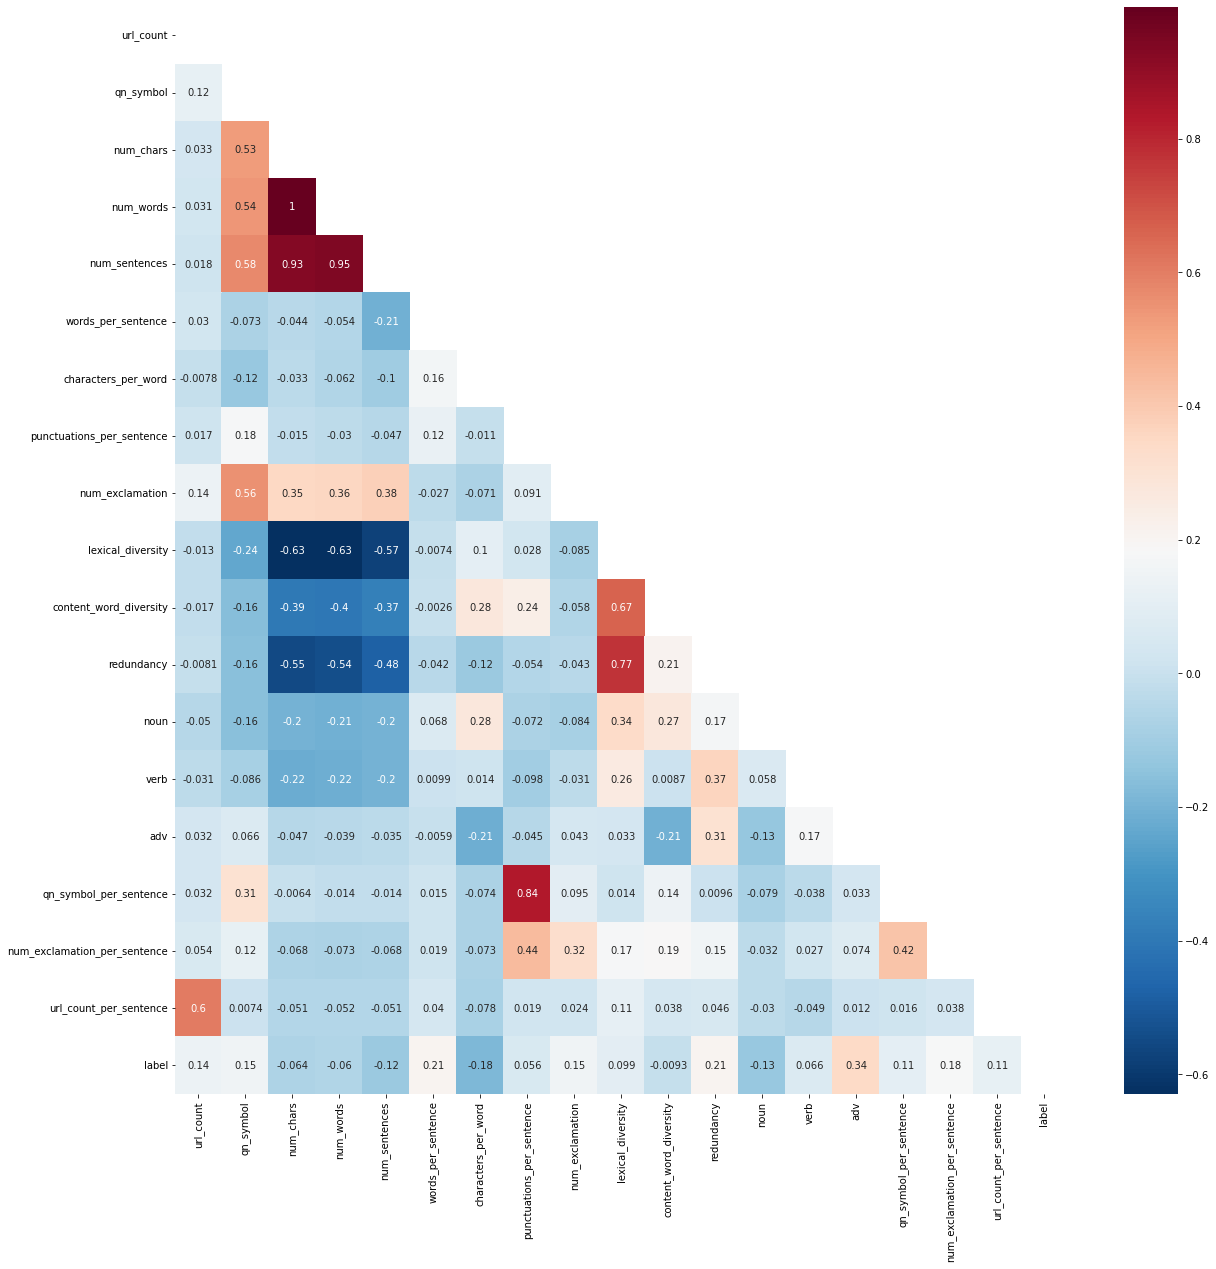

In [ ]:
# mask out upper triangle
mask = np.zeros_like(df["welfake"][rfecv_features+["label"]].corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(20,20))
sns.heatmap(df["welfake"][rfecv_features+["label"]].corr(), 
           cmap='RdBu_r', 
           annot = True, 
           mask = mask
            )

In [ ]:
from sklearn import metrics
predicted_y = rfecv.predict(X_val)
gg=compute_metrics(predicted_y,y_val)
d=gg
tn, fp, fn, tp = d["confusiton_mat"].ravel()
print("{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}".format('prec-t','prec-f', 'rec-t','rec-f','f1-t','f1-f','accu','tn', 'fp', 'fn', 'tp'))  # correct
print ("{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:}\t{:}\t{:}\t{:}".format(d['precision'][0],d['precision'][1], d['recall'][0],d['recall'][1],d['f1'][0],d['f1'][1],d['accuracy'],tn, fp, fn, tp))

prec-t	prec-f	rec-t	rec-f	f1-t	f1-f	accu	tn	fp	fn	tp
0.927	0.927	0.941	0.910	0.934	0.918	0.927	5979	378	472	4765


In [ ]:
kagglerfecv=rfecv

In [ ]:
# prec-t	prec-f	rec-t	rec-f	f1-t	f1-f	accu	tn	fp	fn	tp
# 0.862	0.852	0.876	0.835	0.869	0.843	0.857	7724	1091	1236	6256


# prec-t	prec-f	rec-t	rec-f	f1-t	f1-f	accu	tn	fp	fn	tp
# 0.859	0.855	0.881	0.830	0.870	0.842	0.857	7763	1052	1275	6217

# prec-t	prec-f	rec-t	rec-f	f1-t	f1-f	accu	tn	fp	fn	tp
# 0.854	0.850	0.877	0.823	0.865	0.837	0.852	7730	1085	1324	6168

## feature analysis kagglerealfake

In [ ]:
# len(df["welfake"]['text'])-len(df["welfake"]['text'].drop_duplicates())

0

In [84]:
X=df["kagglerealfake"][sementic_features]
Y=df["kagglerealfake"].label

In [85]:
Y.value_counts()

0    3171
1    3164
Name: label, dtype: int64

In [86]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.3, random_state=142,stratify=Y)

In [87]:
X.head()

url_count  qn_symbol  num_chars  num_words  num_sentences  num_exclamation  \
0          0          3       7518       1296             56                0   
1          1          0       2646        444             19                0   
2          0          0       2543        431             10                0   
3          1          0       2660        404             11                1   
4          0          0       1840        317              9                2   

   words_per_sentence  characters_per_word  punctuations_per_sentence  \
0           23.142857             4.551958                   1.910714   
1           23.368421             4.724444                   3.315789   
2           43.100000             4.709382                   4.300000   
3           36.727273             5.237864                   7.272727   
4           35.222222             4.448485                   7.222222   

   get_sentiment_polarity  lexical_diversity  content_word_diversity  \
0                 -0.9997          41.711642               32.175926   
1                  0.7723          61.486486               43.990930   
2                  0.9590          54.756381               41.067285   
3                  0.1705          61.633663               46.867168   
4                  0.9937          55.520505               36.908517   

   redundancy       noun       verb       adj       adv  \
0   10.956790  11.496914   9.876543  6.172840  4.166667   
1   21.541950  14.512472  14.058957  5.442177  5.895692   
2   15.777262  13.689095  10.208817  6.496520  3.016241   
3   16.541353  14.786967  11.528822  6.265664  3.007519   
4   20.504732  11.356467  13.249211  4.731861  3.470032   

   qn_symbol_per_sentence  num_exclamation_per_sentence  \
0                0.053571                      0.000000   
1                0.000000                      0.000000   
2                0.000000                      0.000000   
3                0.000000                      0.090909   
4                0.000000                      0.222222   

   url_count_per_sentence  
0                0.000000  
1                0.052632  
2                0.000000  
3                0.090909  
4                0.000000

In [ ]:
# Feature ranking with recursive feature elimination and cross-validated selection of the best number of features

In [88]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

Optimal number of features : 18


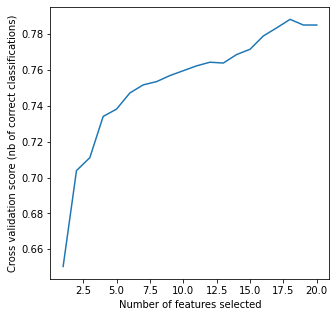

In [89]:
from sklearn.ensemble import RandomForestClassifier
clf=RandomForestClassifier(n_estimators=100,max_features='auto',random_state=0,max_depth=14,class_weight='balanced')
rfecv = RFECV(estimator=clf, step=1, cv=StratifiedKFold(),scoring='accuracy')
rfecv.fit(X_train, y_train)

print("Optimal number of features : %d" % rfecv.n_features_)

plt.figure(figsize=(5,5))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.cv_results_["mean_test_score"]) + 1), rfecv.cv_results_["mean_test_score"])
plt.show()

In [90]:
rfecv.cv_results_["mean_test_score"]

array([0.65043149, 0.70388074, 0.7110948 , 0.73409901, 0.73815535,
       0.74717858, 0.75169046, 0.7534976 , 0.75687877, 0.75958528,
       0.76229205, 0.76432034, 0.76387091, 0.76860496, 0.77153593,
       0.77897598, 0.78348836, 0.78822444, 0.7850657 , 0.78506544])

In [91]:
rfecv.support_

array([ True, False,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [92]:
rfecv.ranking_

array([1, 2, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [93]:
print(X_train.columns.values[rfecv.support_])

['url_count' 'num_chars' 'num_words' 'num_sentences' 'words_per_sentence'
 'characters_per_word' 'punctuations_per_sentence'
 'get_sentiment_polarity' 'lexical_diversity' 'content_word_diversity'
 'redundancy' 'noun' 'verb' 'adj' 'adv' 'qn_symbol_per_sentence'
 'num_exclamation_per_sentence' 'url_count_per_sentence']


In [94]:
rfecv.estimator_

RandomForestClassifier(class_weight='balanced', max_depth=14, random_state=0)

In [95]:
rfecv_features=list(X_train.columns.values[rfecv.support_])

In [96]:
rfecv_features

['url_count',
 'num_chars',
 'num_words',
 'num_sentences',
 'words_per_sentence',
 'characters_per_word',
 'punctuations_per_sentence',
 'get_sentiment_polarity',
 'lexical_diversity',
 'content_word_diversity',
 'redundancy',
 'noun',
 'verb',
 'adj',
 'adv',
 'qn_symbol_per_sentence',
 'num_exclamation_per_sentence',
 'url_count_per_sentence']

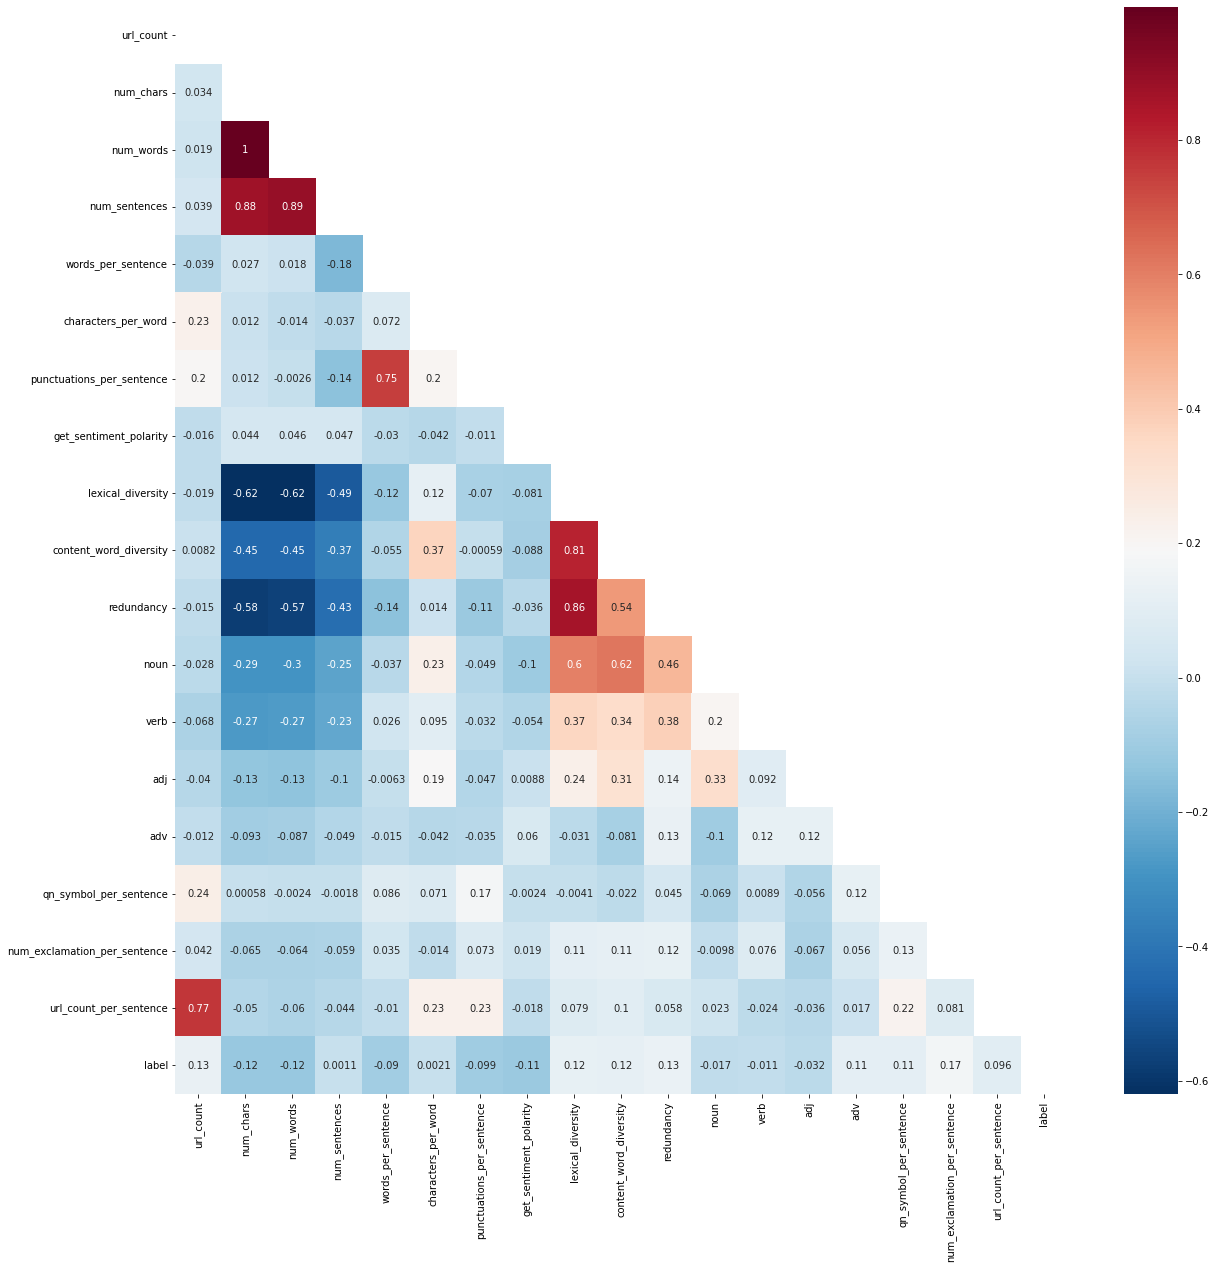

In [97]:
# mask out upper triangle
mask = np.zeros_like(all_df["kagglerealfake"][rfecv_features+["label"]].corr(), dtype=bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(20,20))
sns.heatmap(all_df["kagglerealfake"][rfecv_features+["label"]].corr(), 
           cmap='RdBu_r', 
           annot = True, 
           mask = mask
            ) 

In [ ]:
from sklearn import metrics
predicted_y = rfecv.predict(X_val)
gg=compute_metrics(predicted_y,y_val)
d=gg
tn, fp, fn, tp = d["confusiton_mat"].ravel()
print("{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}".format('prec-t','prec-f', 'rec-t','rec-f','f1-t','f1-f','accu','tn', 'fp', 'fn', 'tp'))  # correct
print ("{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:}\t{:}\t{:}\t{:}".format(d['precision'][0],d['precision'][1], d['recall'][0],d['recall'][1],d['f1'][0],d['f1'][1],d['accuracy'],tn, fp, fn, tp))

In [ ]:
kagglerealfakerfecv=rfecv

In [ ]:
# prec-t	prec-f	rec-t	rec-f	f1-t	f1-f	accu	tn	fp	fn	tp
# 0.862	0.852	0.876	0.835	0.869	0.843	0.857	7724	1091	1236	6256


# prec-t	prec-f	rec-t	rec-f	f1-t	f1-f	accu	tn	fp	fn	tp
# 0.859	0.855	0.881	0.830	0.870	0.842	0.857	7763	1052	1275	6217

# prec-t	prec-f	rec-t	rec-f	f1-t	f1-f	accu	tn	fp	fn	tp
# 0.854	0.850	0.877	0.823	0.865	0.837	0.852	7730	1085	1324	6168

## feature analysis liar  2label

In [ ]:
# len(df["liar"]['text'])-len(df["liar"]['text'].drop_duplicates())

In [98]:
X=df["liar"][sementic_features]
Y=df["liar"].label

In [99]:
df["liar"].label.value_counts()

0    7134
1    5657
Name: label, dtype: int64

In [100]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.3, random_state=142,stratify=Y)

In [101]:
X.head()

url_count  qn_symbol  num_chars  num_words  num_sentences  num_exclamation  \
0          0          0         68         11              1                0   
1          0          0         63         12              1                0   
2          0          0         51         10              1                0   
3          0          0         85         13              1                0   
4          0          0        127         23              2                0   

   words_per_sentence  characters_per_word  punctuations_per_sentence  \
0                11.0             5.181818                        4.0   
1                12.0             4.250000                        1.0   
2                10.0             4.100000                        1.0   
3                13.0             5.538462                        1.0   
4                11.5             4.434783                        1.5   

   get_sentiment_polarity  lexical_diversity  content_word_diversity  \
0                  0.0000         100.000000               54.545455   
1                  0.0772         100.000000               50.000000   
2                 -0.3089         100.000000               50.000000   
3                  0.3400         100.000000               69.230769   
4                 -0.5994          95.652174               60.869565   

   redundancy       noun       verb       adj       adv  \
0   45.454545  27.272727  27.272727  0.000000  9.090909   
1   50.000000  33.333333   8.333333  0.000000  0.000000   
2   50.000000  10.000000  30.000000  0.000000  0.000000   
3   30.769231  23.076923  23.076923  0.000000  0.000000   
4   39.130435  21.739130  17.391304  4.347826  4.347826   

   qn_symbol_per_sentence  num_exclamation_per_sentence  \
0                     0.0                           0.0   
1                     0.0                           0.0   
2                     0.0                           0.0   
3                     0.0                           0.0   
4                     0.0                           0.0   

   url_count_per_sentence  
0                     0.0  
1                     0.0  
2                     0.0  
3                     0.0  
4                     0.0

In [ ]:
# Feature ranking with recursive feature elimination and cross-validated selection of the best number of features

In [102]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

Optimal number of features : 20


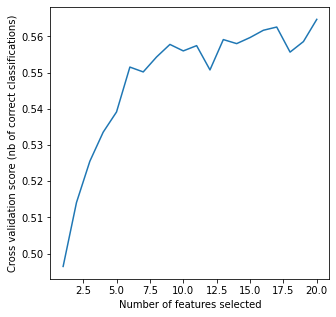

In [104]:
from sklearn.ensemble import RandomForestClassifier
clf=RandomForestClassifier(n_estimators=100,max_features='auto',random_state=0,max_depth=14,class_weight='balanced')
rfecv = RFECV(estimator=clf, step=1, cv=StratifiedKFold(),scoring='accuracy')
rfecv.fit(X_train, y_train)

print("Optimal number of features : %d" % rfecv.n_features_)

plt.figure(figsize=(5,5))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.cv_results_["mean_test_score"]) + 1), rfecv.cv_results_["mean_test_score"])
plt.show()

In [105]:
rfecv.cv_results_["mean_test_score"]

array([0.49648073, 0.51412987, 0.52552433, 0.53356547, 0.53915081,
       0.55154718, 0.55020709, 0.55433936, 0.5578041 , 0.5560144 ,
       0.55746704, 0.55076444, 0.5591432 , 0.55802682, 0.55970161,
       0.56171316, 0.56260583, 0.55568126, 0.55858648, 0.56472724])

In [106]:
rfecv.support_

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [107]:
rfecv.ranking_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [108]:
print(X_train.columns.values[rfecv.support_])

['url_count' 'qn_symbol' 'num_chars' 'num_words' 'num_sentences'
 'num_exclamation' 'words_per_sentence' 'characters_per_word'
 'punctuations_per_sentence' 'get_sentiment_polarity' 'lexical_diversity'
 'content_word_diversity' 'redundancy' 'noun' 'verb' 'adj' 'adv'
 'qn_symbol_per_sentence' 'num_exclamation_per_sentence'
 'url_count_per_sentence']


In [109]:
rfecv.estimator_

RandomForestClassifier(class_weight='balanced', max_depth=14, random_state=0)

In [110]:
rfecv_features=list(X_train.columns.values[rfecv.support_])

In [111]:
rfecv_features

['url_count',
 'qn_symbol',
 'num_chars',
 'num_words',
 'num_sentences',
 'num_exclamation',
 'words_per_sentence',
 'characters_per_word',
 'punctuations_per_sentence',
 'get_sentiment_polarity',
 'lexical_diversity',
 'content_word_diversity',
 'redundancy',
 'noun',
 'verb',
 'adj',
 'adv',
 'qn_symbol_per_sentence',
 'num_exclamation_per_sentence',
 'url_count_per_sentence']

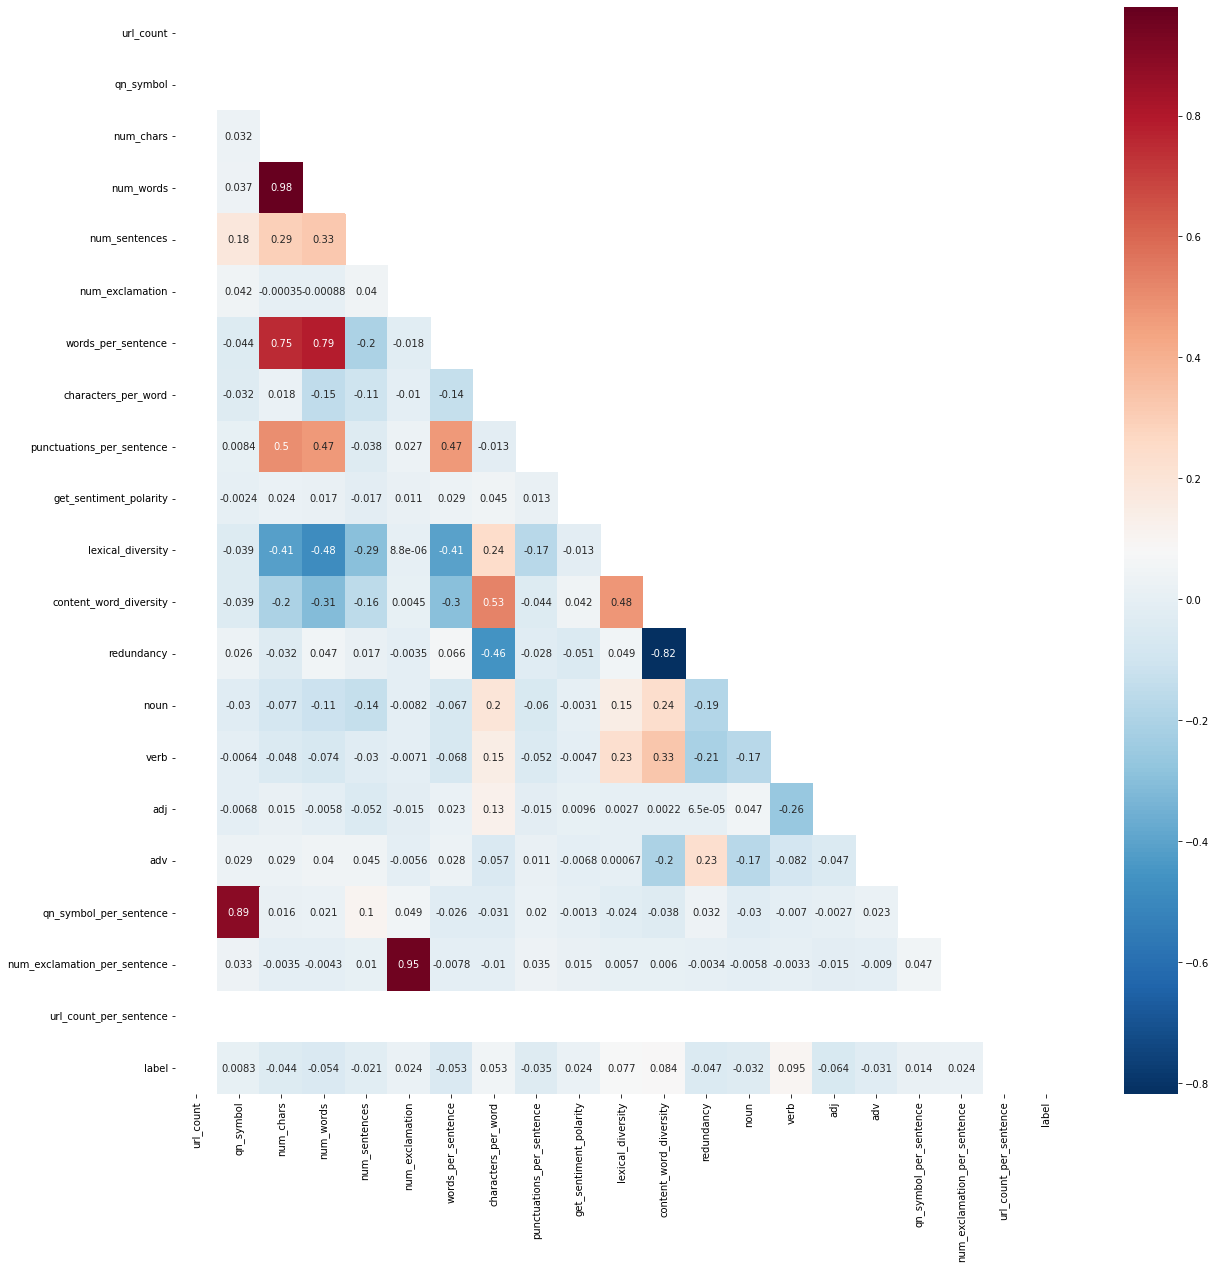

In [112]:
# mask out upper triangle
mask = np.zeros_like(all_df["liar"][rfecv_features+["label"]].corr(), dtype=bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(20,20))
sns.heatmap(all_df["liar"][rfecv_features+["label"]].corr(), 
           cmap='RdBu_r', 
           annot = True, 
           mask = mask
            )

In [ ]:
from sklearn import metrics
predicted_y = rfecv.predict(X_val)
gg=compute_metrics(predicted_y,y_val)
d=gg
# tn, fp, fn, tp = d["confusiton_mat"].ravel()
tn,fp,fn,tp=0,0,0,0
print("{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}".format('prec-t','prec-f', 'rec-t','rec-f','f1-t','f1-f','accu','tn', 'fp', 'fn', 'tp'))  # correct
print ("{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:}\t{:}\t{:}\t{:}".format(d['precision'][0],d['precision'][1], d['recall'][0],d['recall'][1],d['f1'][0],d['f1'][1],d['accuracy'],tn, fp, fn, tp))

In [ ]:
# prec-t	prec-f	rec-t	rec-f	f1-t	f1-f	accu	tn	fp	fn	tp
# 0.210	0.219	0.208	0.193	0.209	0.205	0.212	0	0	0	0    6 label

In [ ]:
liar6rfecv=rfecv

## feature analysis liar 2:4

In [ ]:
# len(df["liar"]['text'])-len(df["liar"]['text'].drop_duplicates())

0

In [ ]:
dfl24=df["liar"][sementic_features+["split","label"]].copy()

In [ ]:
dfl24.split.value_counts()

train    10219
valid     1279
test      1267
Name: split, dtype: int64

In [ ]:
df["liar"].label.value_counts()

half-true      2621
false          2493
mostly-true    2452
barely-true    2102
true           2050
pants-fire     1047
Name: label, dtype: int64

In [ ]:
dfl24.label.value_counts()

1    8263
0    4502
Name: label, dtype: int64

In [ ]:
dfl24["label"]=dfl24["label"].replace(["half-true","false","barely-true","pants-fire"],1).replace(["true","mostly-true"],0)

In [ ]:
train=dfl24.loc[dfl24["split"]!="test"]
test=dfl24.loc[dfl24["split"]=="test"]

In [ ]:
X_train = train[sementic_features]
X_val  = test[sementic_features]

y_train = train.label
y_val =   test.label

In [ ]:
X.head()

url_count  qn_symbol  ...  num_exclamation_per_sentence  url_count_per_sentence
0          0          9  ...                      0.315789                0.000000
1          0          0  ...                      0.000000                0.000000
2          1          4  ...                      0.080000                0.040000
3          4          1  ...                      0.000000                0.307692
4          0          0  ...                      0.000000                0.000000

[5 rows x 20 columns]

In [ ]:
# Feature ranking with recursive feature elimination and cross-validated selection of the best number of features

In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

Optimal number of features : 16


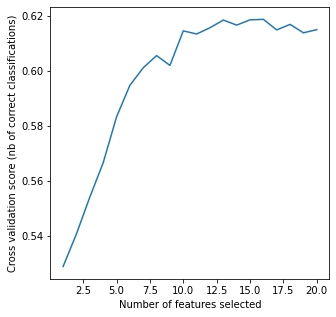

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf=RandomForestClassifier(n_estimators=100,max_features='auto',random_state=0,max_depth=14,class_weight='balanced')
rfecv = RFECV(estimator=clf, step=1, cv=StratifiedKFold(),scoring='accuracy')
rfecv.fit(X_train, y_train)

print("Optimal number of features : %d" % rfecv.n_features_)

plt.figure(figsize=(5,5))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [ ]:
rfecv.grid_scores_

array([0.52904654, 0.54087618, 0.5541831 , 0.56662038, 0.58323176,
       0.5947118 , 0.60106167, 0.60549615, 0.60193101, 0.61445351,
       0.61332273, 0.61558436, 0.61836825, 0.61654179, 0.61845513,
       0.61862886, 0.61480186, 0.616803  , 0.61375755, 0.61488886])

In [ ]:
rfecv.support_

array([False, False,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False])

In [ ]:
rfecv.ranking_

array([5, 2, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4])

In [ ]:
print(X_train.columns.values[rfecv.support_])

['num_chars' 'num_words' 'num_sentences' 'words_per_sentence'
 'characters_per_word' 'punctuations_per_sentence'
 'get_sentiment_polarity' 'lexical_diversity' 'content_word_diversity'
 'redundancy' 'noun' 'verb' 'adj' 'adv' 'qn_symbol_per_sentence'
 'num_exclamation_per_sentence']


In [ ]:
rfecv.estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=14, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [ ]:
rfecv_features=list(X_train.columns.values[rfecv.support_])

In [ ]:
rfecv_features

['num_chars',
 'num_words',
 'num_sentences',
 'words_per_sentence',
 'characters_per_word',
 'punctuations_per_sentence',
 'get_sentiment_polarity',
 'lexical_diversity',
 'content_word_diversity',
 'redundancy',
 'noun',
 'verb',
 'adj',
 'adv',
 'qn_symbol_per_sentence',
 'num_exclamation_per_sentence']

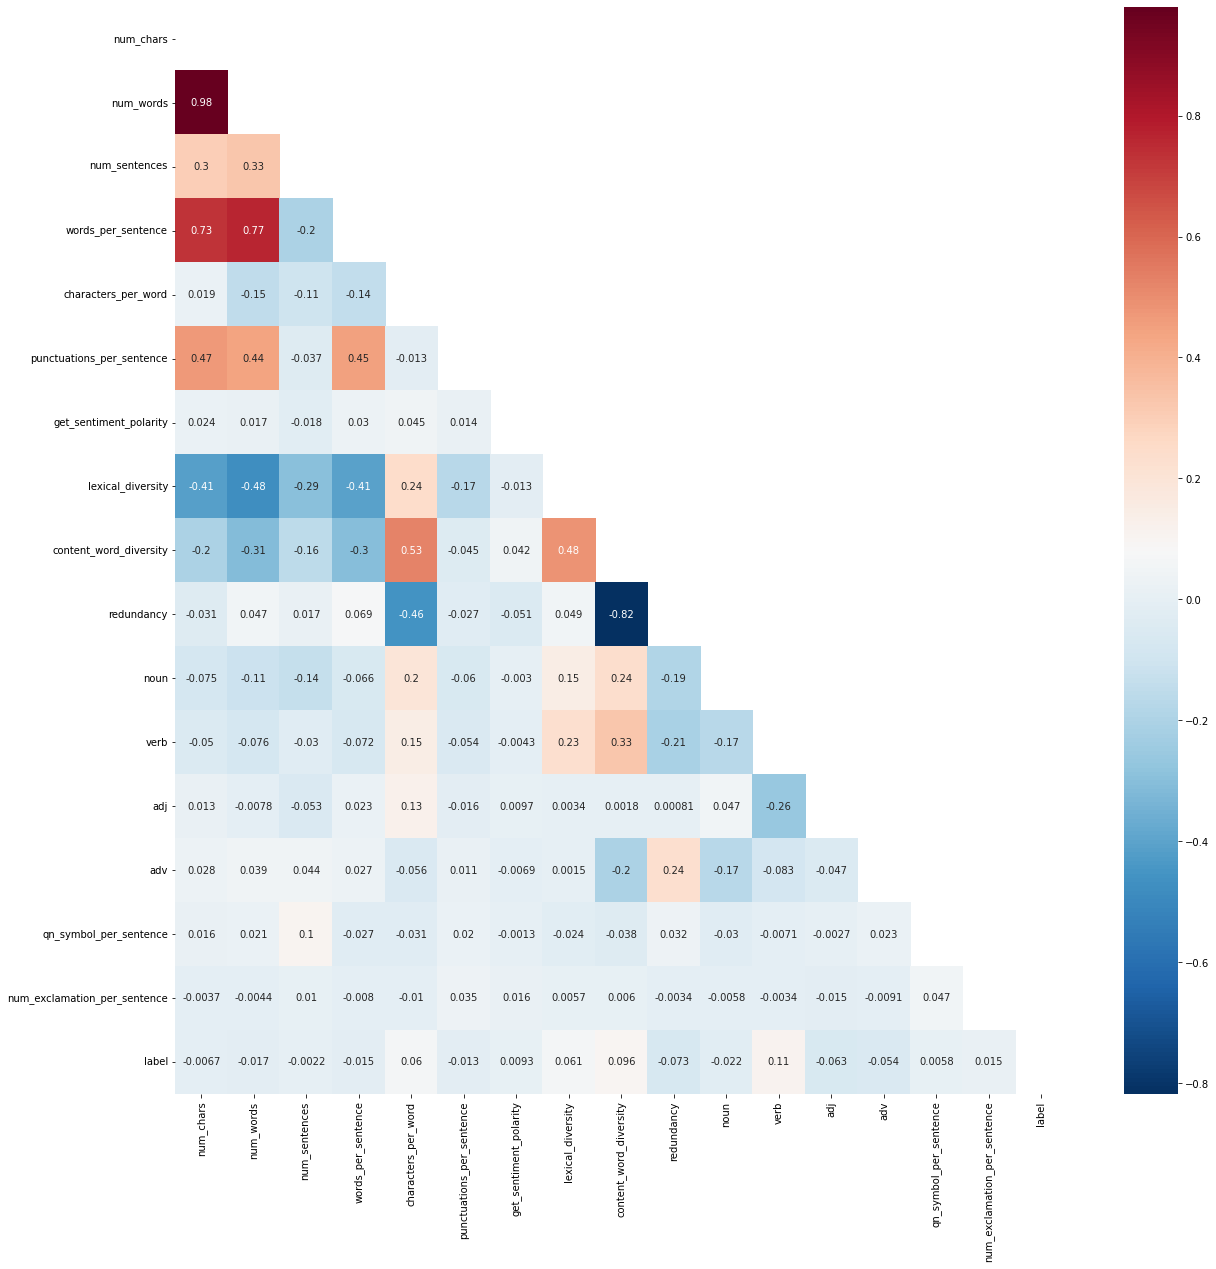

In [ ]:
# mask out upper triangle
mask = np.zeros_like(dfl24[rfecv_features+["label"]].corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(20,20))
sns.heatmap(dfl24[rfecv_features+["label"]].corr(), 
           cmap='RdBu_r', 
           annot = True, 
           mask = mask
            )

In [ ]:
from sklearn import metrics
predicted_y = rfecv.predict(X_val)
gg=compute_metrics(predicted_y,y_val)
d=gg
tn, fp, fn, tp = d["confusiton_mat"].ravel()
# tn,fp,fn,tp=0,0,0,0
print("{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}".format('prec-t','prec-f', 'rec-t','rec-f','f1-t','f1-f','accu','tn', 'fp', 'fn', 'tp'))  # correct
print ("{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:}\t{:}\t{:}\t{:}".format(d['precision'][0],d['precision'][1], d['recall'][0],d['recall'][1],d['f1'][0],d['f1'][1],d['accuracy'],tn, fp, fn, tp))

prec-t	prec-f	rec-t	rec-f	f1-t	f1-f	accu	tn	fp	fn	tp
0.476	0.689	0.352	0.787	0.405	0.735	0.633	158	291	174	644


In [ ]:
liar24rfecv=rfecv

In [ ]:
# prec-t	prec-f	rec-t	rec-f	f1-t	f1-f	accu	tn	fp	fn	tp
# 0.936	0.920	0.926	0.931	0.931	0.925	0.928	6523	522	446	5979  f1

# prec-t	prec-f	rec-t	rec-f	f1-t	f1-f	accu	tn	fp	fn	tp
# 0.446	0.678	0.315	0.787	0.369	0.729	0.621	425	926	527	1952   with count

# prec-t	prec-f	rec-t	rec-f	f1-t	f1-f	accu	tn	fp	fn	tp
# 0.443	0.677	0.315	0.784	0.368	0.727	0.619	425	926	535	1944  without count 

# prec-t	prec-f	rec-t	rec-f	f1-t	f1-f	accu	tn	fp	fn	tp
# 0.476	0.689	0.352	0.787	0.405	0.735	0.633	158	291	174	644    with count

## feature analysis liar 1:5

In [ ]:
# len(df["liar"]['text'])-len(df["liar"]['text'].drop_duplicates())

0

In [ ]:
dfl=df["liar"][sementic_features+["split","label"]].copy()

In [ ]:
dfl.split.value_counts()

train    10219
valid     1279
test      1267
Name: split, dtype: int64

In [ ]:
dfl.label.value_counts()

1    10715
0     2050
Name: label, dtype: int64

In [ ]:
dfl["label"]=dfl["label"].replace(["half-true","false","barely-true","pants-fire","mostly-true"],1).replace(["true"],0)

In [ ]:
train=dfl.loc[dfl["split"]!="test"]
test=dfl.loc[dfl["split"]=="test"]

In [ ]:
X_train = train[sementic_features]
X_val  = test[sementic_features]

y_train = train.label
y_val =   test.label

In [ ]:
X_train.head()

url_count  ...  url_count_per_sentence
1267          0  ...                     0.0
1268          0  ...                     0.0
1269          0  ...                     0.0
1270          0  ...                     0.0
1271          0  ...                     0.0

[5 rows x 20 columns]

In [ ]:
# Feature ranking with recursive feature elimination and cross-validated selection of the best number of features

In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

Optimal number of features : 13


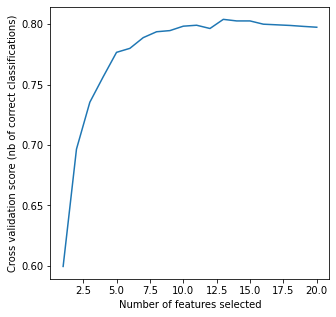

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf=RandomForestClassifier(n_estimators=100,max_features='auto',random_state=0,max_depth=14,class_weight='balanced')
rfecv = RFECV(estimator=clf, step=1, cv=StratifiedKFold(),scoring='accuracy')
rfecv.fit(X_train, y_train)

print("Optimal number of features : %d" % rfecv.n_features_)

plt.figure(figsize=(5,5))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [ ]:
rfecv.grid_scores_

array([0.59941014, 0.69655559, 0.73534675, 0.75639431, 0.7766587 ,
       0.77996305, 0.78883325, 0.79370176, 0.79465998, 0.79831276,
       0.79909575, 0.79639968, 0.80396653, 0.80266108, 0.80266184,
       0.7999646 , 0.7994438 , 0.79892157, 0.79813862, 0.79744278])

In [ ]:
rfecv.support_

array([False, False,  True,  True, False,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True, False,
       False, False])

In [ ]:
rfecv.ranking_

array([8, 5, 1, 1, 2, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 3, 6, 7])

In [ ]:
print(X_train.columns.values[rfecv.support_])

['num_chars' 'num_words' 'words_per_sentence' 'characters_per_word'
 'punctuations_per_sentence' 'get_sentiment_polarity' 'lexical_diversity'
 'content_word_diversity' 'redundancy' 'noun' 'verb' 'adj' 'adv']


In [ ]:
rfecv.estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=14, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [ ]:
rfecv_features=list(X_train.columns.values[rfecv.support_])

In [ ]:
rfecv_features

['num_chars',
 'num_words',
 'words_per_sentence',
 'characters_per_word',
 'punctuations_per_sentence',
 'get_sentiment_polarity',
 'lexical_diversity',
 'content_word_diversity',
 'redundancy',
 'noun',
 'verb',
 'adj',
 'adv']

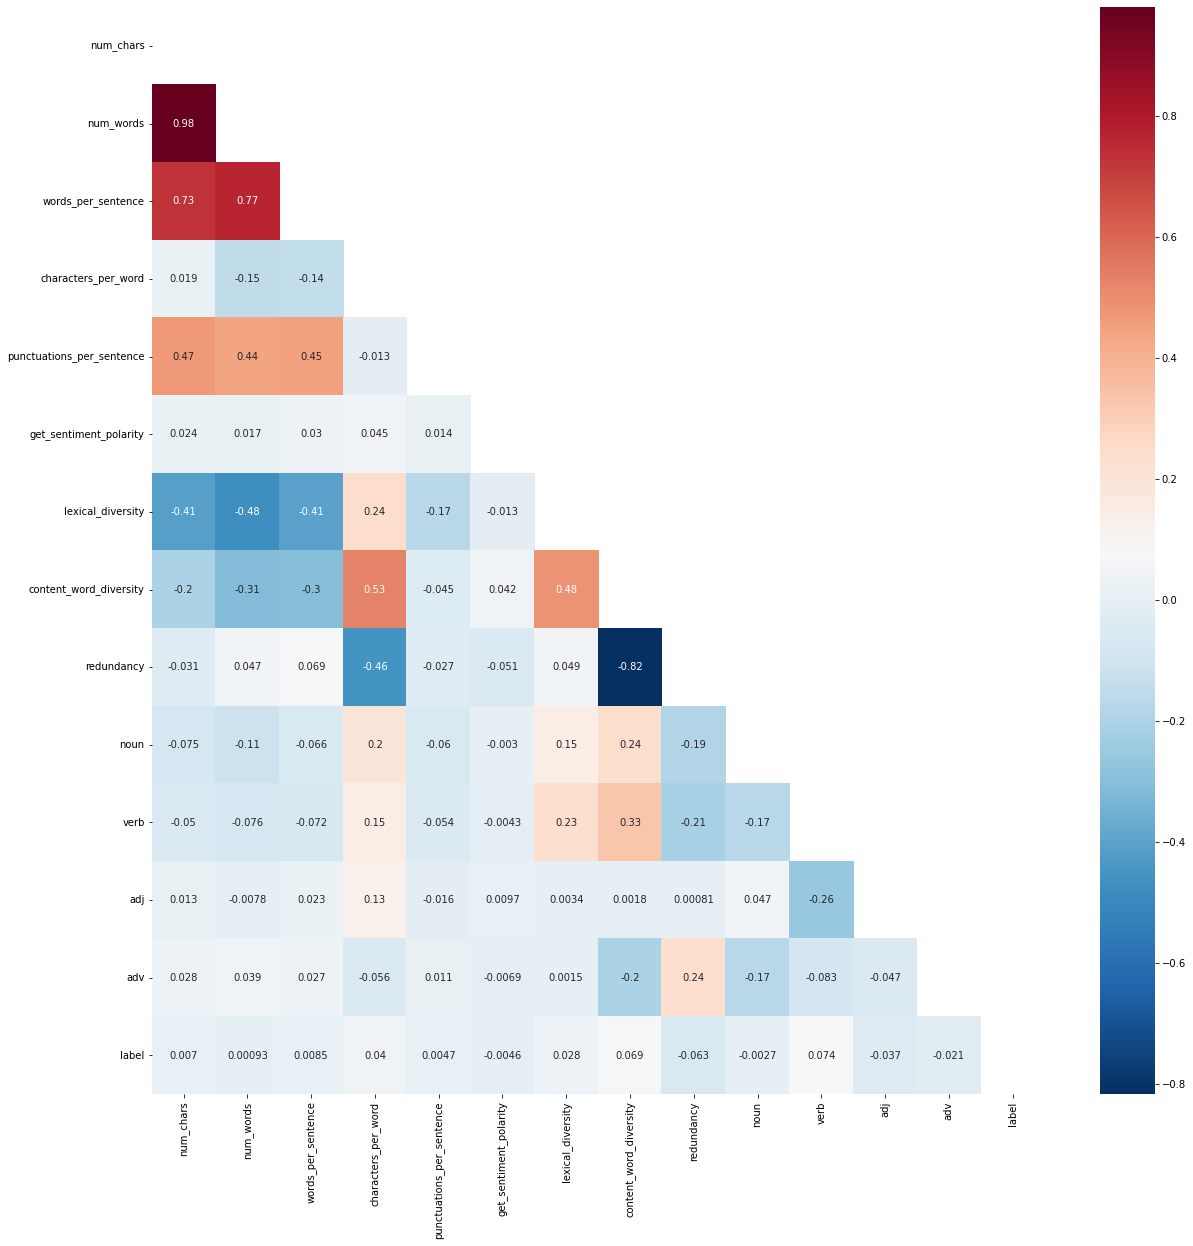

In [ ]:
# mask out upper triangle
mask = np.zeros_like(dfl[rfecv_features+["label"]].corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(20,20))
sns.heatmap(dfl[rfecv_features+["label"]].corr(), 
           cmap='RdBu_r', 
           annot = True, 
           mask = mask
            )

In [ ]:
from sklearn import metrics
predicted_y = rfecv.predict(X_val)
gg=compute_metrics(predicted_y,y_val)
d=gg
tn, fp, fn, tp = d["confusiton_mat"].ravel()
# tn,fp,fn,tp=0,0,0,0
print("{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}".format('prec-t','prec-f', 'rec-t','rec-f','f1-t','f1-f','accu','tn', 'fp', 'fn', 'tp'))  # correct
print ("{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:}\t{:}\t{:}\t{:}".format(d['precision'][0],d['precision'][1], d['recall'][0],d['recall'][1],d['f1'][0],d['f1'][1],d['accuracy'],tn, fp, fn, tp))

prec-t	prec-f	rec-t	rec-f	f1-t	f1-f	accu	tn	fp	fn	tp
0.213	0.840	0.091	0.934	0.128	0.884	0.796	19	189	70	989


## feature analysis welfake : NO

In [ ]:
# len(df["welfake"]['text'])-len(df["welfake"]['text'].drop_duplicates())

0

In [ ]:
X=df["welfake"][sementic_features]
Y=df["welfake"].label

In [ ]:
Y.value_counts()

0    34620
1    28098
Name: label, dtype: int64

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.3, random_state=142,stratify=Y)

In [ ]:
X.head()

url_count  qn_symbol  ...  num_exclamation_per_sentence  url_count_per_sentence
0          0          7  ...                      0.045455                     0.0
1          0          1  ...                      0.000000                     0.0
2          0          0  ...                      0.000000                     0.0
3          0          1  ...                      0.000000                     0.0
4          0          0  ...                      0.000000                     0.0

[5 rows x 20 columns]

In [ ]:
# Feature ranking with recursive feature elimination and cross-validated selection of the best number of features

In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

Optimal number of features : 19


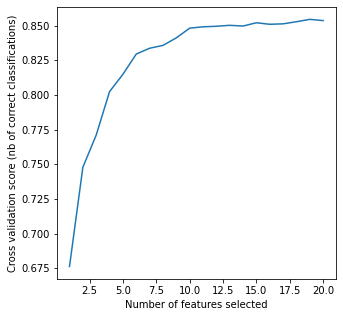

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf=RandomForestClassifier(n_estimators=100,max_features='auto',random_state=0,max_depth=14,class_weight='balanced')
rfecv = RFECV(estimator=clf, step=1, cv=StratifiedKFold(),scoring='accuracy')
rfecv.fit(X_train, y_train)

print("Optimal number of features : %d" % rfecv.n_features_)

plt.figure(figsize=(5,5))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [ ]:
rfecv.grid_scores_

array([0.67625621, 0.7477791 , 0.77103526, 0.80237811, 0.81486028,
       0.82946097, 0.83365217, 0.83570216, 0.84112337, 0.84813894,
       0.84911839, 0.84950562, 0.8501889 , 0.84966501, 0.85203398,
       0.85094063, 0.85125945, 0.8527856 , 0.85449403, 0.85360563])

In [ ]:
rfecv.support_

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True])

In [ ]:
rfecv.ranking_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1])

In [ ]:
print(X_train.columns.values[rfecv.support_])

['url_count' 'qn_symbol' 'num_chars' 'num_words' 'num_sentences'
 'words_per_sentence' 'characters_per_word' 'punctuations_per_sentence'
 'num_exclamation' 'get_sentiment_polarity' 'lexical_diversity'
 'content_word_diversity' 'redundancy' 'noun' 'verb' 'adv'
 'qn_symbol_per_sentence' 'num_exclamation_per_sentence'
 'url_count_per_sentence']


In [ ]:
rfecv.estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=14, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [ ]:
rfecv_features=list(X_train.columns.values[rfecv.support_])

In [ ]:
rfecv_features

['url_count',
 'qn_symbol',
 'num_chars',
 'num_words',
 'num_sentences',
 'words_per_sentence',
 'characters_per_word',
 'punctuations_per_sentence',
 'num_exclamation',
 'get_sentiment_polarity',
 'lexical_diversity',
 'content_word_diversity',
 'redundancy',
 'noun',
 'verb',
 'adv',
 'qn_symbol_per_sentence',
 'num_exclamation_per_sentence',
 'url_count_per_sentence']

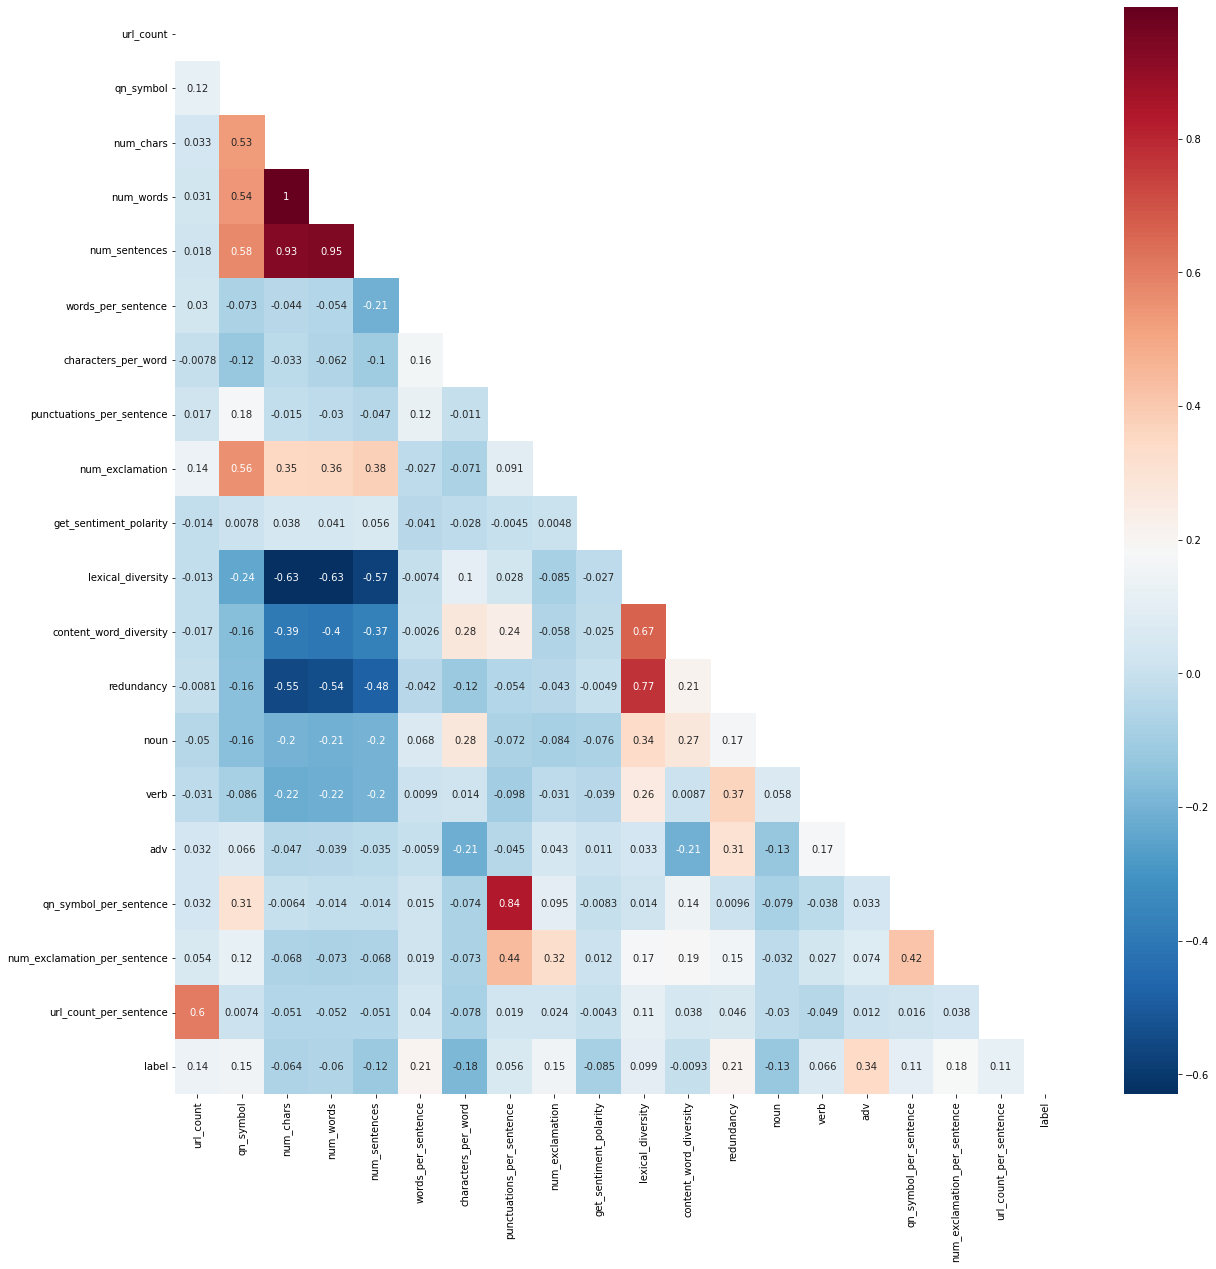

In [ ]:
# mask out upper triangle
mask = np.zeros_like(df["welfake"][rfecv_features+["label"]].corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(20,20))
sns.heatmap(df["welfake"][rfecv_features+["label"]].corr(), 
           cmap='RdBu_r', 
           annot = True, 
           mask = mask
            )

In [ ]:
from sklearn import metrics
predicted_y = rfecv.predict(X_val)
gg=compute_metrics(predicted_y,y_val)
d=gg
tn, fp, fn, tp = d["confusiton_mat"].ravel()
print("{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}".format('prec-t','prec-f', 'rec-t','rec-f','f1-t','f1-f','accu','tn', 'fp', 'fn', 'tp'))  # correct
print ("{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:}\t{:}\t{:}\t{:}".format(d['precision'][0],d['precision'][1], d['recall'][0],d['recall'][1],d['f1'][0],d['f1'][1],d['accuracy'],tn, fp, fn, tp))

prec-t	prec-f	rec-t	rec-f	f1-t	f1-f	accu	tn	fp	fn	tp
0.856	0.855	0.888	0.815	0.871	0.835	0.855	9220	1166	1556	6874


In [ ]:
welfakerfecv=rfecv

In [ ]:
# prec-t	prec-f	rec-t	rec-f	f1-t	f1-f	accu	tn	fp	fn	tp
# 0.862	0.852	0.876	0.835	0.869	0.843	0.857	7724	1091	1236	6256


# prec-t	prec-f	rec-t	rec-f	f1-t	f1-f	accu	tn	fp	fn	tp
# 0.859	0.855	0.881	0.830	0.870	0.842	0.857	7763	1052	1275	6217

# prec-t	prec-f	rec-t	rec-f	f1-t	f1-f	accu	tn	fp	fn	tp
# 0.854	0.850	0.877	0.823	0.865	0.837	0.852	7730	1085	1324	6168

## feature analysis dfAll

In [113]:
dfAllcopy=dfAll.copy()

In [114]:
dfAllcopy.drop(columns=["split"],inplace=True)

In [115]:
X=dfAllcopy[sementic_features]
Y=dfAllcopy.label
stratify=dfAllcopy[["source","label"]]

In [116]:
dfAllcopy.label.value_counts()

0    54763
1    43157
Name: label, dtype: int64

In [117]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.3, random_state=142,stratify=stratify)

In [118]:
stratify.groupby(["source","label"]).size()

source          label
codalab         0         5600
                1         5100
fakenewsnet     0        17441
                1         5755
isot            0        21417
                1        23481
kagglerealfake  0         3171
                1         3164
liar            0         7134
                1         5657
dtype: int64

In [ ]:
# y_train.groupby(["source","label"]).size()

In [ ]:
X.head()

url_count  qn_symbol  ...  num_exclamation_per_sentence  url_count_per_sentence
0          0          1  ...                           0.0                     0.0
1          0          0  ...                           0.0                     0.0
2          0          0  ...                           0.0                     0.0
3          0          0  ...                           0.0                     0.0
4          0          0  ...                           0.0                     0.0

[5 rows x 20 columns]

Feature ranking with recursive feature elimination and cross-validated selection of the best number of features

In [119]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

Optimal number of features : 20


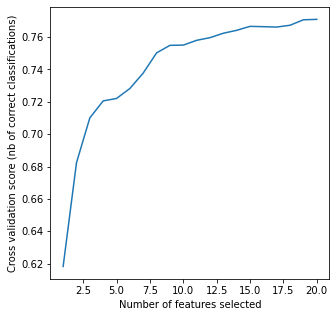

In [120]:
from sklearn.ensemble import RandomForestClassifier
clf=RandomForestClassifier(n_estimators=100,max_features='auto',random_state=0,max_depth=14,class_weight='balanced')
rfecv = RFECV(estimator=clf, step=1, cv=StratifiedKFold(),scoring='accuracy')
rfecv.fit(X_train, y_train)

print("Optimal number of features : %d" % rfecv.n_features_)

plt.figure(figsize=(5,5))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.cv_results_["mean_test_score"]) + 1), rfecv.cv_results_["mean_test_score"])
plt.show()

In [130]:
rfecv.cv_results_["mean_test_score"]

array([0.61827441, 0.68232082, 0.71002566, 0.72051527, 0.72201792,
       0.72817469, 0.73773058, 0.75016049, 0.75482903, 0.75497488,
       0.75792193, 0.75957049, 0.76229871, 0.76410773, 0.76654414,
       0.76635451, 0.76612108, 0.76724443, 0.77061453, 0.77087713])

In [122]:
rfecv.support_

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [123]:
rfecv.ranking_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [124]:
print(X_train.columns.values[rfecv.support_])

['url_count' 'qn_symbol' 'num_chars' 'num_words' 'num_sentences'
 'num_exclamation' 'words_per_sentence' 'characters_per_word'
 'punctuations_per_sentence' 'get_sentiment_polarity' 'lexical_diversity'
 'content_word_diversity' 'redundancy' 'noun' 'verb' 'adj' 'adv'
 'qn_symbol_per_sentence' 'num_exclamation_per_sentence'
 'url_count_per_sentence']


In [125]:
rfecv.estimator_

RandomForestClassifier(class_weight='balanced', max_depth=14, random_state=0)

In [126]:
rfecv_features=list(X_train.columns.values[rfecv.support_])

In [127]:
rfecv_features

['url_count',
 'qn_symbol',
 'num_chars',
 'num_words',
 'num_sentences',
 'num_exclamation',
 'words_per_sentence',
 'characters_per_word',
 'punctuations_per_sentence',
 'get_sentiment_polarity',
 'lexical_diversity',
 'content_word_diversity',
 'redundancy',
 'noun',
 'verb',
 'adj',
 'adv',
 'qn_symbol_per_sentence',
 'num_exclamation_per_sentence',
 'url_count_per_sentence']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


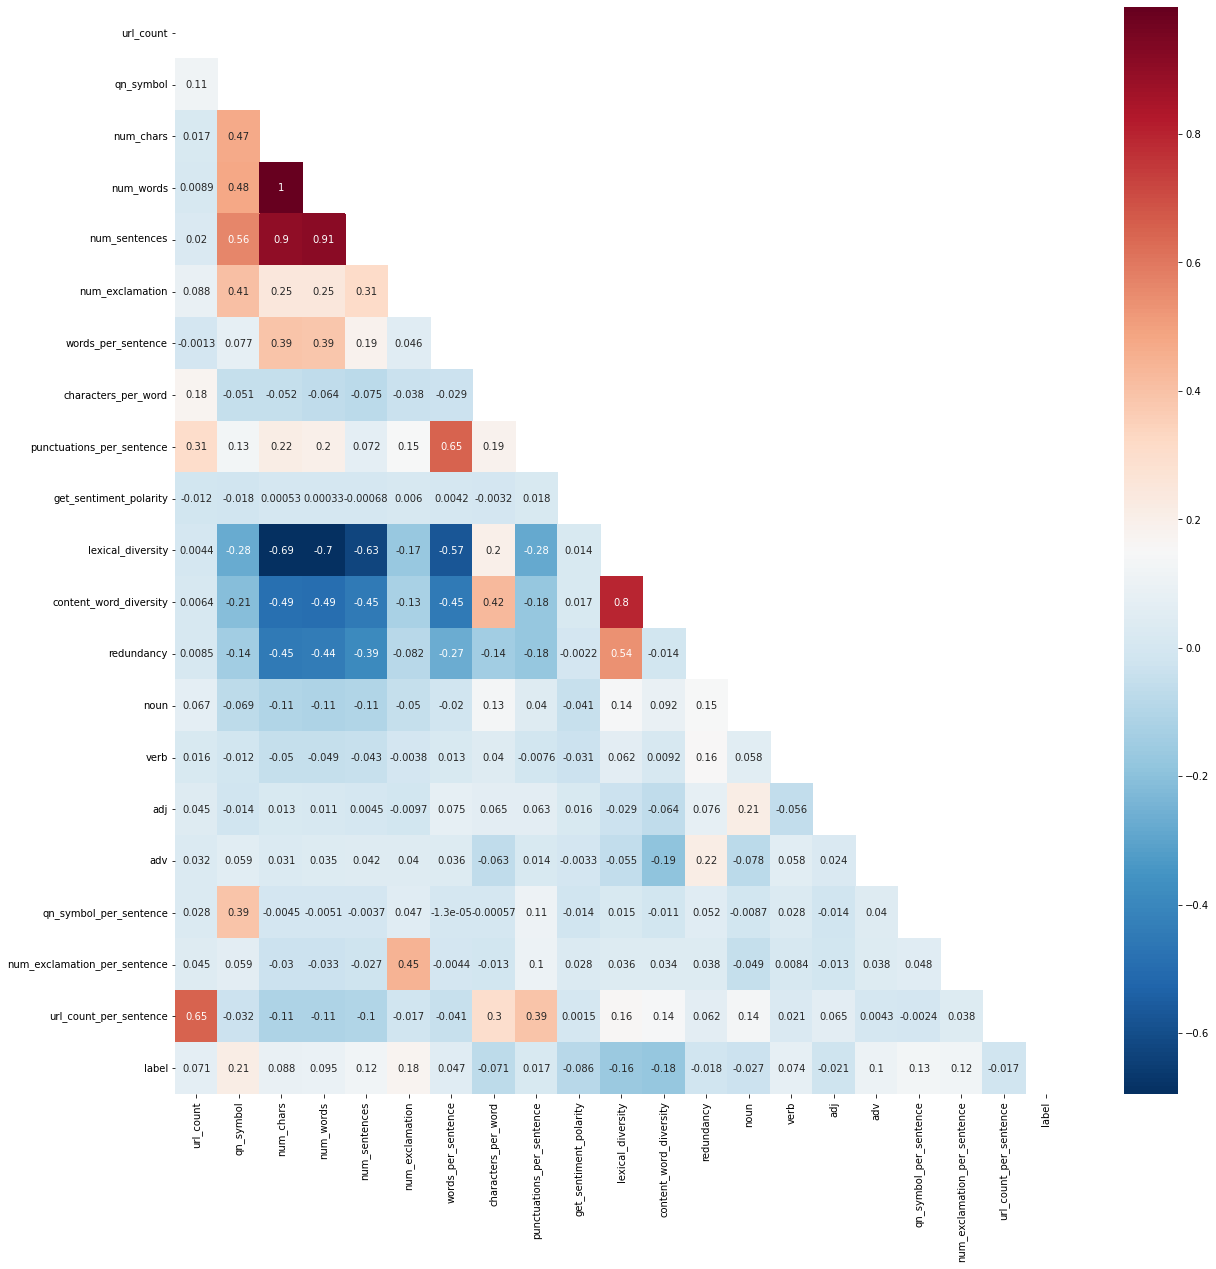

In [128]:
# mask out upper triangle
mask = np.zeros_like(dfAllcopy[rfecv_features+["label"]].corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(20,20))
sns.heatmap(dfAllcopy[rfecv_features+["label"]].corr(), 
           cmap='RdBu_r', 
           annot = True, 
           mask = mask
            )

In [ ]:
from sklearn import metrics
predicted_y = rfecv.predict(X_val)
gg=compute_metrics(predicted_y,y_val)
d=gg
tn, fp, fn, tp = d["confusiton_mat"].ravel()
print("{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}".format('prec-t','prec-f', 'rec-t','rec-f','f1-t','f1-f','accu','tn', 'fp', 'fn', 'tp'))  # correct
print ("{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:}\t{:}\t{:}\t{:}".format(d['precision'][0],d['precision'][1], d['recall'][0],d['recall'][1],d['f1'][0],d['f1'][1],d['accuracy'],tn, fp, fn, tp))

prec-t	prec-f	rec-t	rec-f	f1-t	f1-f	accu	tn	fp	fn	tp
0.886	0.840	0.894	0.828	0.890	0.834	0.868	26414	3120	3388	16337


In [ ]:
# prec-t	prec-f	rec-t	rec-f	f1-t	f1-f	accu	tn	fp	fn	tp
# 0.798	0.757	0.821	0.729	0.809	0.743	0.781	12549	2741	3168	8542

# prec-t	prec-f	rec-t	rec-f	f1-t	f1-f	accu	tn	fp	fn	tp
# 0.797	0.756	0.821	0.727	0.809	0.741	0.780	12553	2740	3197	8510

# prec-t	prec-f	rec-t	rec-f	f1-t	f1-f	accu	tn	fp	fn	tp
# 0.790	0.742	0.808	0.719	0.799	0.730	0.769	12361	2931	3293	8415

In [ ]:
# len(dfAll['text'])-len(dfAll['text'].drop_duplicates())

In [ ]:
# dfU=dfAll['text'].drop_duplicates()

In [ ]:
# dfF=dfAll.drop(dfU.index, axis=0)

In [ ]:
# dfF["text"][54683]

In [ ]:
# dfF["source"].value_counts()

In [ ]:
# ff=df["welfake"].append(df["isot"],ignore_index = True)

In [ ]:
# len(ff['text'])-len(ff['text'].drop_duplicates())

## Hyperparameter tuning

In [ ]:
!pip install TPOT -q

     |████████████████████████████████| 87 kB 2.7 MB/s 
     |████████████████████████████████| 173.6 MB 8.7 kB/s 
     |████████████████████████████████| 160 kB 54.1 MB/s 


In [ ]:
# from sklearn.ensemble import ExtraTreesClassifier

# model = ExtraTreesClassifier()

from tpot import TPOTClassifier

parameters = {'criterion': ['entropy', 'gini'],
               'max_depth': list(np.linspace(10, 1200, 10, dtype = int)) + [None],
               'max_features': ['auto', 'sqrt','log2', None],
               'min_samples_leaf': [4, 12],
               'min_samples_split': [5, 10],
               'n_estimators': list(np.linspace(151, 1200, 10, dtype = int))}
               
tpot_classifier = TPOTClassifier(generations= 5, population_size= 24, offspring_size= 12,
                                 verbosity= 2, early_stop= 12,
                                 config_dict=
                                 {'sklearn.ensemble.ExtraTreesClassifier': parameters}, 
                                 cv = 4, scoring = 'accuracy')
tpot_classifier.fit(X_train,y_train) 

Optimization Progress:   0%|          | 0/84 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.8585029752219795

Generation 2 - Current best internal CV score: 0.8595507448016628

Generation 3 - Current best internal CV score: 0.8603024075722056

Generation 4 - Current best internal CV score: 0.8603024075722056

Generation 5 - Current best internal CV score: 0.8603024075722056

Best pipeline: ExtraTreesClassifier(ExtraTreesClassifier(input_matrix, criterion=gini, max_depth=935, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=850), criterion=gini, max_depth=671, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=1200)


TPOTClassifier(config_dict={'sklearn.ensemble.ExtraTreesClassifier': {'criterion': ['entropy',
                                                                                    'gini'],
                                                                      'max_depth': [10,
                                                                                    142,
                                                                                    274,
                                                                                    406,
                                                                                    538,
                                                                                    671,
                                                                                    803,
                                                                                    935,
                                                                                    1067,
           

In [ ]:
Best pipeline: ExtraTreesClassifier(ExtraTreesClassifier(input_matrix, criterion=gini, max_depth=935, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=850), criterion=gini, max_depth=671, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=1200)

In [ ]:
import numpy as np 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import ExtraTreesClassifier

random_search = {'criterion': ['entropy', 'gini'],
               'max_depth': list(np.linspace(10, 1200, 10, dtype = int)) + [None],
               'max_features': ['auto', 'sqrt','log2', None],
               'min_samples_leaf': [4, 12],
               'min_samples_split': [5, 10],
               'n_estimators': list(np.linspace(151, 1200, 10, dtype = int))}

clf = ExtraTreesClassifier()
model = RandomizedSearchCV(estimator = clf, param_distributions = random_search, n_iter = 80, 
                               cv = 4, verbose= 5, random_state= 101, n_jobs = -1)
model.fit(X_train,y_train) 

Fitting 4 folds for each of 80 candidates, totalling 320 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


RandomizedSearchCV(cv=4, estimator=ExtraTreesClassifier(), n_iter=80, n_jobs=-1,
                   param_distributions={'criterion': ['entropy', 'gini'],
                                        'max_depth': [10, 142, 274, 406, 538,
                                                      671, 803, 935, 1067, 1200,
                                                      None],
                                        'max_features': ['auto', 'sqrt', 'log2',
                                                         None],
                                        'min_samples_leaf': [4, 12],
                                        'min_samples_split': [5, 10],
                                        'n_estimators': [151, 267, 384, 500,
                                                         617, 733, 850, 966,
                                                         1083, 1200]},
                   random_state=101, verbose=5)

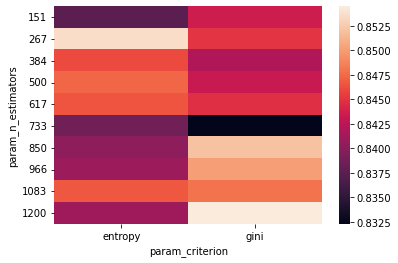

In [ ]:
import seaborn as sns

table = pd.pivot_table(pd.DataFrame(model.cv_results_),
    values='mean_test_score', index='param_n_estimators', 
                       columns='param_criterion')
     
sns.heatmap(table)

In [ ]:
from sklearn.metrics import classification_report

predictionforest = model.best_estimator_.predict(X_val)
print(confusion_matrix(y_val,predictionforest))
print(classification_report(y_val,predictionforest))
acc3 = accuracy_score(y_val,predictionforest)

[[9299 1087]
 [1546 6884]]
              precision    recall  f1-score   support

           0       0.86      0.90      0.88     10386
           1       0.86      0.82      0.84      8430

    accuracy                           0.86     18816
   macro avg       0.86      0.86      0.86     18816
weighted avg       0.86      0.86      0.86     18816



In [ ]:
model.best_estimator_

ExtraTreesClassifier(criterion='entropy', max_depth=935, max_features=None,
                     min_samples_leaf=4, min_samples_split=5, n_estimators=151)

In [ ]:
# AllDF
import numpy as np 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import ExtraTreesClassifier

random_search = {'criterion': ['entropy', 'gini'],
               'max_depth': list(np.linspace(10, 1200, 10, dtype = int)) + [None],
               'max_features': ['auto', 'sqrt','log2', None],
               'min_samples_leaf': [4, 12],
               'min_samples_split': [5, 10],
               'n_estimators': list(np.linspace(151, 1200, 10, dtype = int))}

clf = ExtraTreesClassifier()
model = RandomizedSearchCV(estimator = clf, param_distributions = random_search, n_iter = 80, 
                               cv = 4, verbose= 5, random_state= 101, n_jobs = -1)
model.fit(X_train,y_train) 


In [ ]:
# ExtraTreesClassifier( ExtraTreesClassifier(
#     criterion="gini", 
#     max_depth=935, 
#     max_features="log2",
#     min_samples_leaf=4, 
#     min_samples_split=10, 
#     n_estimators=850
#     ), 
#     criterion="gini", 
#     max_depth=671, 
#     max_features="auto", 
#     min_samples_leaf=4, 
#     min_samples_split=10, 
#     # n_estimators=1200
# ) 

ExtraTreesClassifier(max_depth=671, min_samples_leaf=4, min_samples_split=10,
                     n_estimators=ExtraTreesClassifier(max_depth=935,
                                                       max_features='log2',
                                                       min_samples_leaf=4,
                                                       min_samples_split=10,
                                                       n_estimators=850))

In [ ]:
import seaborn as sns

table = pd.pivot_table(pd.DataFrame(model.cv_results_),
    values='mean_test_score', index='param_n_estimators', 
                       columns='param_criterion')
     
sns.heatmap(table)

In [ ]:
from sklearn.metrics import classification_report

predictionforest = model.best_estimator_.predict(X_val)
print(confusion_matrix(y_val,predictionforest))
print(classification_report(y_val,predictionforest))
acc3 = accuracy_score(y_val,predictionforest)

In [ ]:
model.best_estimator_

# compare different models

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

In [ ]:
classifiers=[['Logistic Regression :',LogisticRegression()],
       ['Decision Tree Classification :',DecisionTreeClassifier()],
       ['Gradient Boosting Classification :', GradientBoostingClassifier()],
       ['Ada Boosting Classification :',AdaBoostClassifier()],
       ['Extra Tree Classification :', ExtraTreesClassifier()],
       ['K-Neighbors Classification :',KNeighborsClassifier()],
       ['Support Vector Classification :',SVC()],
       ['Gaussian Naive Bayes :',GaussianNB()]]
cla_pred=[]

In [ ]:
# ~ 4-5 min run 
for name,model1 in classifiers:
    print("-----------"+name+"-------------")
    model1.fit(X_train,y_train)
    predicted_y = model1.predict(X_val)
    score=compute_metrics(predicted_y,y_val)
    cla_pred.append(score)

-----------Logistic Regression :-------------


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


-----------Decision Tree Classification :-------------
-----------Gradient Boosting Classification :-------------
-----------Ada Boosting Classification :-------------
-----------Extra Tree Classification :-------------
-----------K-Neighbors Classification :-------------
-----------Support Vector Classification :-------------
-----------Gaussian Naive Bayes :-------------


In [ ]:
Y.value_counts()

0    50974
1    39025
Name: label, dtype: int64

In [ ]:
#Prining the evaluation matrix to the console
print("Summary\n Class 0- True news \n Class 1 - False news\n")
print("{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}".format('prec-t','prec-f', 'rec-t','rec-f','f1-t','f1-f','accu','tn', 'fp', 'fn', 'tp'))  # correct
for i in range(len(classifiers)):
  # print("-----------"+classifiers[i][0]+"-------------")
  d=cla_pred[i]
  tn, fp, fn, tp = cla_pred[i]["confusiton_mat"].ravel() #correct
  print ("{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:}\t{:}\t{:}\t{:}".format(d['precision'][0],d['precision'][1], d['recall'][0],d['recall'][1],d['f1'][0],d['f1'][1],d['accuracy'],tn, fp, fn, tp))

Summary
 Class 0- True news 
 Class 1 - False news

prec-t	prec-f	rec-t	rec-f	f1-t	f1-f	accu	tn	fp	fn	tp
0.670	0.672	0.825	0.468	0.739	0.552	0.670	12620	2672	6226	5482
0.726	0.642	0.725	0.643	0.726	0.642	0.689	11088	4204	4184	7524
0.743	0.778	0.867	0.608	0.800	0.683	0.755	13259	2033	4589	7119
0.729	0.739	0.840	0.591	0.781	0.657	0.732	12852	2440	4788	6920
0.765	0.751	0.830	0.666	0.796	0.706	0.759	12699	2593	3905	7803
0.712	0.675	0.784	0.585	0.746	0.627	0.698	11994	3298	4853	6855
0.699	0.753	0.872	0.510	0.776	0.608	0.715	13332	1960	5741	5967
0.610	0.784	0.958	0.201	0.745	0.320	0.629	14643	649	9358	2350


In [ ]:
# -----------Decision Tree Classification :-------------
# -----------Gradient Boosting Classification :-------------
# -----------Ada Boosting Classification :-------------
# -----------Extra Tree Classification :-------------
# -----------K-Neighbors Classification :-------------
# -----------Support Vector Classification :-------------
# -----------Gaussian Naive Bayes :-------------

In [ ]:
# prec-t	prec-f	rec-t	rec-f	f1-t	f1-f	accu	tn	fp	fn	tp  (acc with counts)
  # 0.693	0.693	0.823	0.523	0.752	0.596	0.693	12581	2712	5586	6121
  # 0.742	0.666	0.746	0.660	0.744	0.663	0.709	11414	3879	3978	7729
  # 0.755	0.793	0.874	0.629	0.810	0.702	0.768	13371	1922	4344	7363
  # 0.731	0.752	0.850	0.592	0.786	0.662	0.738	13002	2291	4778	6929
  # 0.776	0.765	0.839	0.683	0.806	0.722	0.772	12835	2458	3707	8000
  # 0.692	0.665	0.792	0.540	0.739	0.596	0.683	12114	3179	5386	6321
  # 0.627	0.686	0.892	0.307	0.737	0.424	0.639	13649	1644	8113	3594
  # 0.623	0.792	0.950	0.249	0.752	0.378	0.646	14528	765	8796	2911

# SVc classifier

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
start = time.time()

svm_classifier = SVC(probability=True)
svm_classifier.fit(X_train,y_train)

end = time.time()
process = round(end-start,2)
print("Support Vector Machine Classifier has fitted, this process took {} seconds".format(process))

# print(svm_classifier.score(X_val,y_val))

In [ ]:
predicted_y = svm_classifier.predict(X_val)
print(predicted_y)

['false' 'false' 'false' ... 'half-true' 'half-true' 'half-true']


In [ ]:
gg=compute_metrics(predicted_y,y_val)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
gg

{'accuracy': 0.2249408050513023,
 'confusiton_mat': array([[  0,  74, 105,  33,   0,   0],
        [  0,  97, 105,  47,   0,   0],
        [  0,  93, 130,  42,   0,   0],
        [  0,  69, 114,  58,   0,   0],
        [  0,  35,  45,  12,   0,   0],
        [  0,  62,  90,  56,   0,   0]]),
 'f1': array([0.        , 0.28571429, 0.30444965, 0.23721881, 0.        ,
        0.        ]),
 'precision': array([0.        , 0.2255814 , 0.22071307, 0.23387097, 0.        ,
        0.        ]),
 'recall': array([0.        , 0.38955823, 0.49056604, 0.2406639 , 0.        ,
        0.        ])}

In [ ]:
d=gg
# tn, fp, fn, tp = d["confusiton_mat"].ravel()
tn,fp,fn,tp=0,0,0,0
print("{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}".format('prec-f','prec-t', 'rec-f','rec-t','f1-f','f1-t','accu','tn', 'fp', 'fn', 'tp'))
print ("{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:}\t{:}\t{:}\t{:}".format(d['precision'][0],d['precision'][1], d['recall'][0],d['recall'][1],d['f1'][0],d['f1'][1],d['accuracy'],tn, fp, fn, tp))

prec-f	prec-t	rec-f	rec-t	f1-f	f1-t	accu	tn	fp	fn	tp
0.000	0.226	0.000	0.390	0.000	0.286	0.225	0	0	0	0


In [ ]:
d=gg
tn, fp, fn, tp = d["confusiton_mat"].ravel()
# tn,fp,fn,tp=0,0,0,0
print("{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}".format('prec-f','prec-t', 'rec-f','rec-t','f1-f','f1-t','accu','tn', 'fp', 'fn', 'tp'))
print ("{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:}\t{:}\t{:}\t{:}".format(d['precision'][0],d['precision'][1], d['recall'][0],d['recall'][1],d['f1'][0],d['f1'][1],d['accuracy'],tn, fp, fn, tp))

In [ ]:
# prec-f	prec-t	rec-f	rec-t	f1-f	f1-t	accu	tn	fp	fn	tp
# 0.000	0.226	0.000	0.390	0.000	0.286	0.225	0	0	0	0             6 label

# K- Means

In [ ]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
 
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [ ]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 9)
# Building the clustering model and calculating the values of the Distortion and Inertia:
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
 
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) /len(X))
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / len(X)
    mapping2[k] = kmeanModel.inertia_

1 : 1135.97095129364
2 : 709.2842635049233
3 : 447.13501113776147
4 : 341.07547495980725
5 : 269.0041357751784
6 : 227.1199560981886
7 : 193.2792975681858
8 : 172.30746046629457


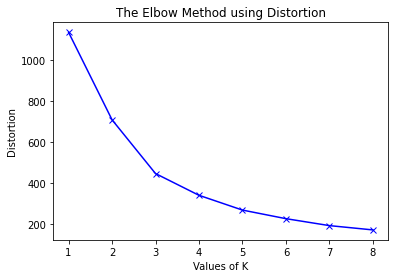

In [ ]:
# Using the different values of Distortion:
for key, val in mapping1.items():
    print(f'{key} : {val}')

plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

1 : 101492237544.3723
2 : 33967243320.674633
3 : 14096182325.003077
4 : 8062431771.224383
5 : 5089620603.075904
6 : 3599006546.9642
7 : 2643418747.7247386
8 : 2054024795.7770631


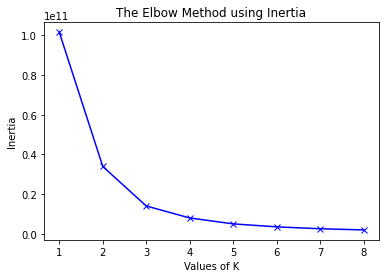

In [ ]:
# Using the different values of Inertia:
for key, val in mapping2.items():
    print(f'{key} : {val}')
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

In [ ]:
no_of_cluster= 2

In [ ]:
k_means_model=KMeans(n_clusters=no_of_cluster).fit(X)
# k_means_model=KMeans(n_clusters=no_of_cluster,random_state=0).fit(X)

In [ ]:
y_kmeans = list(k_means_model.predict(X))

In [ ]:
print("Number of predictions:",len(k_means_model.labels_))

Number of predictions: 50439


In [ ]:
pca = PCA(n_components=2).fit(X)

In [ ]:
datapoint = pca.transform(X).tolist()

In [ ]:
datapoints = pca.transform(X)

In [ ]:
len(datapoint)

50439

K-clustering


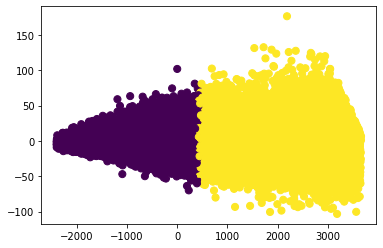

In [ ]:
print("K-clustering")
plt.scatter(datapoints[:, 0], datapoints[:, 1], c=y_kmeans, s=50, cmap='viridis')

True-Flase


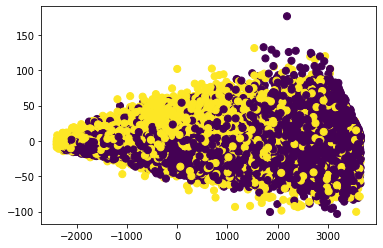

In [ ]:
print("True-Flase")
plt.scatter(datapoints[:, 0], datapoints[:, 1], c=Y, s=50, cmap='viridis')

In [ ]:
k0=[datapoint[i] for i in range(len(y_kmeans)) if y_kmeans[i]==0]
k1=[datapoint[i] for i in range(len(y_kmeans)) if y_kmeans[i]==1]

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(16, 16) )
label1 = ["green", "red"]
color = [label1[Y[i]] for i in range(len(Y)) if  y_kmeans[i]==0 ]
plt.scatter([i[0] for i in k0], [i[1] for i in k0], c=color , marker=">" ,s=20*4  )  #cluster 1

color = [label1[Y[i]] for i in range(len(Y)) if  y_kmeans[i]==1 ]
plt.scatter([i[0] for i in k1], [i[1] for i in k1], c=color , marker="o" ,s=20*4)  #cluster 2
centroids = k_means_model.cluster_centers_
centroidpoint = pca.transform(centroids)
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='^', s=150, c='#000000')
print("True-Flase")
plt.show()

# TensorBoard

In [ ]:
import tensorboard as tb
import tensorflow as tf

tf.io.gfile = tb.compat.tensorflow_stub.io.gfile
from torch.utils.tensorboard import SummaryWriter

In [ ]:
vectors = np.array(df["liar"][sementic_features])
metadata = df["liar"].label # labels
writer = SummaryWriter()
writer.add_embedding(vectors, metadata)
writer.close()

In [ ]:
!rm -fr runs

In [ ]:
# X

In [ ]:
# X.describe()

In [ ]:
# X.head()

In [ ]:
# vectors[0]

In [ ]:
metadata

In [ ]:
%reload_ext tensorboard
# %load_ext tensorboard
%tensorboard --logdir=/content/runs